In [1]:
import warnings
warnings.simplefilter("ignore")

import os
from pathlib import Path
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter
import seaborn as sns
from tqdm import tqdm
from datetime import datetime, timezone

from sklearn.cluster import MiniBatchKMeans

from sentence_transformers import SentenceTransformer

In [2]:
FILENAME = 'Mayo_28_2025_merged_route-views_ALL_ipv4_AW.parquet'

current_dir = Path.cwd()
parent_dir = current_dir.parent
raw_dir = parent_dir / 'data' / 'raw'

PATH = raw_dir / FILENAME

df = pd.read_parquet(PATH, engine="pyarrow")
print("Shape: ", df.shape)
print("Columnas:", list(df.columns))
display(df.head(5))

Shape:  (17565303, 13)
Columnas: ['time', 'project', 'collector', 'peer_asn', 'peer_ip', 'type', 'prefix', 'next_hop', 'as_path', 'origin', 'local_pref', 'med', 'communities']


,time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,local_pref,med,communities
0,1.748398e+09,routeviews,route-views2.saopaulo,264409,187.16.215.63,A,23.138.24.0/24,187.16.215.63,264409 174 1299 6939 6939 399619,None,None,None,"[174:22013, 174:21000, 54510:1, 54510:174]"
1,1.748398e+09,routeviews,route-views.eqix,398465,206.126.236.209,A,103.68.200.0/24,206.126.236.209,398465 7029 6939 40747,None,None,None,[]
2,1.748398e+09,routeviews,route-views.eqix,398465,206.126.236.209,A,103.68.201.0/24,206.126.236.209,398465 7029 6939 40747,None,None,None,[]
3,1.748398e+09,routeviews,route-views.eqix,398465,206.126.236.209,A,103.163.77.0/24,206.126.236.209,398465 7029 6939 40747,None,None,None,[]
4,1.748398e+09,routeviews,route-views2.saopaulo,52468,187.16.208.180,W,76.9.40.0/22,None,None,None,None,None,None


In [3]:
df.loc[:, 'origin'] = (
    df['as_path']
    .where(df["as_path"].notna(), None)
    .apply(lambda x: str(x).split()[-1])
    )
display(df.head(5))

,time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,local_pref,med,communities
0,1.748398e+09,routeviews,route-views2.saopaulo,264409,187.16.215.63,A,23.138.24.0/24,187.16.215.63,264409 174 1299 6939 6939 399619,399619,None,None,"[174:22013, 174:21000, 54510:1, 54510:174]"
1,1.748398e+09,routeviews,route-views.eqix,398465,206.126.236.209,A,103.68.200.0/24,206.126.236.209,398465 7029 6939 40747,40747,None,None,[]
2,1.748398e+09,routeviews,route-views.eqix,398465,206.126.236.209,A,103.68.201.0/24,206.126.236.209,398465 7029 6939 40747,40747,None,None,[]
3,1.748398e+09,routeviews,route-views.eqix,398465,206.126.236.209,A,103.163.77.0/24,206.126.236.209,398465 7029 6939 40747,40747,None,None,[]
4,1.748398e+09,routeviews,route-views2.saopaulo,52468,187.16.208.180,W,76.9.40.0/22,None,None,None,None,None,None


In [4]:
df.drop(columns=['project','local_pref','med','communities'], inplace=True)

In [5]:
df['origin'].nunique()

54454

In [37]:
df['prefix'].nunique()

645941

In [6]:
affected_prefixes = [
    "2.56.242.0/24",
    "2.58.66.0/24",
    "2.58.67.0/24",
    "5.8.69.0/24",
    "5.56.30.0/24",
    "5.180.78.0/24",
    "12.2.176.0/24",
    "12.17.138.0/23",
    "12.17.176.0/20",
    "12.43.88.0/22",
    "12.45.225.0/24",
    "12.46.122.0/24",
    "12.111.223.0/24",
    "12.146.36.0/24",
    "12.146.42.0/24",
    "12.175.119.0/24",
    "12.182.174.0/24",
    "12.220.96.0/24",
    "14.137.132.0/22",
    "14.137.152.0/24",
    "14.137.153.0/24",
    "14.137.155.0/24",
    "14.137.161.0/24",
    "14.137.172.0/22",
    "23.94.88.0/24",
    "23.138.208.0/24",
    "23.147.112.0/24",
    "23.175.1.0/24",
    "23.186.64.0/24",
    "23.230.239.0/24",
    "23.231.132.0/24",
    "23.235.16.0/20",
    "23.235.20.0/22",
    "23.235.20.0/24",
    "24.206.87.0/24",
    "24.206.96.0/24",
    "24.239.134.0/24",
    "24.239.140.0/24",
    "24.239.142.0/24",
    "24.239.146.0/24",
    "27.50.2.0/24",
    "27.123.196.0/23",
    "31.6.43.0/24",
    "31.13.191.0/24",
    "31.14.252.0/24",
    "31.22.110.0/24",
    "37.148.128.0/22",
    "37.148.132.0/22",
    "38.76.16.0/24",
    "38.76.17.0/24",
    "38.95.108.0/22",
    "38.95.108.0/24",
    "38.95.109.0/24",
    "38.95.110.0/24",
    "38.95.111.0/24",
    "38.97.91.0/24",
    "38.107.141.0/24",
    "38.108.68.0/24",
    "38.132.104.0/24",
    "38.132.115.0/24",
    "38.132.120.0/24",
    "41.203.8.0/22",
    "41.203.12.0/22",
    "41.203.16.0/20",
    "41.204.208.0/21",
    "41.204.216.0/22",
    "41.204.220.0/23",
    "41.204.222.0/23",
    "42.200.61.0/24",
    "43.128.0.0/18",
    "43.128.52.0/24",
    "43.128.64.0/24",
    "43.128.82.0/24",
    "43.128.124.0/24",
    "43.128.128.0/19",
    "43.128.128.0/24",
    "43.128.192.0/19",
    "43.129.32.0/19",
    "43.129.154.0/23",
    "43.132.83.0/24",
    "43.133.64.0/19",
    "43.133.96.0/19",
    "43.133.128.0/19",
    "43.133.224.0/19",
    "43.134.138.0/24",
    "43.134.139.0/24",
    "43.134.192.0/24",
    "43.134.243.0/24",
    "43.134.252.0/24",
    "43.134.253.0/24",
    "43.134.254.0/24",
    "43.134.255.0/24",
    "43.135.54.0/24",
    "43.135.56.0/24",
    "43.135.103.0/24",
    "43.135.104.0/24",
    "43.224.30.0/24",
    "43.224.31.0/24",
    "43.225.140.0/22",
    "43.229.4.0/22",
    "43.229.4.0/24",
    "43.229.5.0/24",
    "43.229.6.0/24",
    "43.229.7.0/24",
    "43.251.64.0/24",
    "43.251.65.0/24",
    "43.251.100.0/22",
    "43.251.100.0/24",
    "43.251.101.0/24",
    "43.251.102.0/24",
    "43.251.103.0/24",
    "43.255.104.0/22",
    "45.8.158.0/23",
    "45.12.185.0/24",
    "45.13.8.0/24",
    "45.40.192.0/22",
    "45.40.196.0/22",
    "45.40.200.0/22",
    "45.40.204.0/22",
    "45.42.214.0/24",
    "45.42.215.0/24",
    "45.43.2.0/24",
    "45.43.3.0/24",
    "45.43.10.0/24",
    "45.43.11.0/24",
    "45.64.64.0/24",
    "45.64.65.0/24",
    "45.64.66.0/24",
    "45.64.67.0/24",
    "45.74.19.0/24",
    "45.74.26.0/24",
    "45.81.25.0/24",
    "45.89.228.0/23",
    "45.113.32.0/24",
    "45.114.220.0/22",
    "45.119.52.0/22",
    "45.126.245.0/24",
    "45.130.146.0/23",
    "45.132.131.0/24",
    "45.135.134.0/23",
    "45.136.244.0/23",
    "45.140.168.0/23",
    "45.145.212.0/22",
    "45.145.232.0/23",
    "45.145.234.0/23",
    "45.147.200.0/23",
    "45.149.62.0/24",
    "45.150.20.0/23",
    "45.152.199.0/24",
    "45.152.209.0/24",
    "45.152.210.0/24",
    "45.152.211.0/24",
    "45.153.20.0/24",
    "45.154.245.0/24",
    "45.154.246.0/24",
    "45.155.128.0/23",
    "45.166.94.0/24",
    "45.178.38.0/24",
    "45.192.132.0/22",
    "45.192.136.0/22",
    "45.192.140.0/24",
    "45.192.141.0/24",
    "45.192.142.0/24",
    "45.192.143.0/24",
    "45.192.144.0/24",
    "45.192.145.0/24",
    "45.192.146.0/24",
    "45.192.148.0/22",
    "45.192.152.0/22",
    "45.195.78.0/24",
    "45.195.112.0/20",
    "45.195.156.0/22",
    "45.195.200.0/24",
    "45.195.250.0/24",
    "45.196.14.0/23",
    "45.197.141.0/24",
    "45.199.158.0/24",
    "45.199.159.0/24",
    "45.204.21.0/24",
    "45.226.108.0/24",
    "45.226.109.0/24",
    "45.226.110.0/24",
    "45.226.111.0/24",
    "45.238.140.0/24",
    "45.238.141.0/24",
    "45.238.142.0/24",
    "45.238.143.0/24",
    "45.244.24.0/22",
    "46.8.200.0/24",
    "46.236.196.0/23",
    "46.236.198.0/24",
    "46.236.200.0/23",
    "46.236.204.0/24",
    "46.236.206.0/24",
    "49.0.192.0/21",
    "50.114.38.0/23",
    "59.151.0.0/18",
    "59.151.1.0/24",
    "59.151.113.0/24",
    "62.3.20.0/24",
    "62.112.144.0/20",
    "62.133.46.0/24",
    "62.141.62.0/24",
    "62.141.63.0/24",
    "62.171.248.0/24",
    "62.171.251.0/24",
    "62.213.115.0/24",
    "63.91.176.0/24",
    "63.96.221.0/24",
    "63.118.87.0/24",
    "63.175.156.0/22",
    "63.175.156.0/23",
    "63.175.156.0/24",
    "63.175.157.0/24",
    "63.175.158.0/23",
    "63.175.158.0/24",
    "63.175.159.0/24",
    "64.6.172.0/22",
    "64.6.176.0/21",
    "64.64.97.0/24",
    "64.64.121.0/24",
    "64.72.112.0/20",
    "64.72.116.0/24",
    "64.72.119.0/24",
    "64.74.163.0/24",
    "64.187.217.0/24",
    "65.206.88.0/24",
    "65.223.140.0/24",
    "65.241.160.0/24",
    "65.243.172.0/23",
    "65.244.97.0/24",
    "66.23.216.0/24",
    "66.23.217.0/24",
    "66.78.62.0/24",
    "66.81.81.0/24",
    "66.90.90.0/23",
    "66.90.92.0/23",
    "66.90.95.0/24",
    "66.90.96.0/24",
    "66.90.108.0/24",
    "66.90.109.0/24",
    "66.114.55.0/24",
    "66.114.57.0/24",
    "66.133.0.0/23",
    "66.133.0.0/24",
    "66.178.0.0/17",
    "66.178.0.0/24",
    "66.178.5.0/24",
    "66.178.6.0/23",
    "66.178.14.0/24",
    "66.178.17.0/24",
    "66.178.18.0/24",
    "66.178.19.0/24",
    "66.178.22.0/23",
    "66.178.38.0/24",
    "66.178.49.0/24",
    "66.178.53.0/24",
    "66.178.88.0/24",
    "66.178.94.0/24",
    "66.178.100.0/23",
    "66.178.100.0/24",
    "66.178.101.0/24",
    "66.178.102.0/23",
    "66.178.102.0/24",
    "66.178.103.0/24",
    "66.178.114.0/23",
    "66.207.160.0/20",
    "67.43.48.0/20",
    "67.43.50.0/24",
    "67.207.190.0/24",
    "67.213.184.0/24",
    "67.213.185.0/24",
    "68.70.205.0/24",
    "69.3.131.0/24",
    "69.4.176.0/20",
    "69.6.32.0/19",
    "69.6.32.0/21",
    "69.6.32.0/24",
    "69.6.40.0/21",
    "69.6.48.0/21",
    "69.6.56.0/21",
    "69.63.176.0/20",
    "69.63.176.0/21",
    "69.63.184.0/21",
    "69.67.131.0/24",
    "69.89.32.0/24",
    "69.89.33.0/24",
    "69.89.34.0/23",
    "69.89.37.0/24",
    "69.89.39.0/24",
    "69.89.40.0/23",
    "69.89.40.0/24",
    "69.89.43.0/24",
    "69.89.44.0/24",
    "69.89.46.0/23",
    "69.89.46.0/24",
    "69.89.47.0/24",
    "71.97.192.0/19",
    "72.35.224.0/21",
    "72.35.232.0/21",
    "74.63.0.0/21",
    "74.63.8.0/21",
    "74.91.53.0/24",
    "74.91.54.0/23",
    "74.119.96.0/23",
    "74.119.99.0/24",
    "74.220.110.0/24",
    "77.111.104.0/24",
    "77.238.168.0/22",
    "77.238.172.0/23",
    "77.238.174.0/24",
    "77.238.183.0/24",
    "77.243.176.0/20",
    "77.243.176.0/24",
    "77.243.187.0/24",
    "77.243.188.0/24",
    "77.243.190.0/24",
    "78.41.42.0/24",
    "79.110.48.0/24",
    "79.172.214.0/24",
    "79.172.219.0/24",
    "79.172.250.0/23",
    "80.66.64.0/24",
    "80.180.53.0/24",
    "80.243.229.0/24",
    "81.17.160.0/21",
    "81.17.168.0/21",
    "81.90.188.0/24",
    "81.90.189.0/24",
    "81.92.200.0/22",
    "81.92.204.0/22",
    "82.102.18.0/24",
    "82.102.19.0/24",
    "82.102.22.0/24",
    "82.102.25.0/24",
    "82.102.27.0/24",
    "82.102.30.0/24",
    "82.102.31.0/24",
    "82.163.248.0/24",
    "82.163.250.0/24",
    "83.143.240.0/21",
    "83.143.240.0/24",
    "83.143.241.0/24",
    "83.143.242.0/24",
    "83.143.243.0/24",
    "83.143.247.0/24",
    "83.151.198.0/24",
    "84.21.189.0/24",
    "84.21.190.0/24",
    "84.39.112.0/21",
    "84.39.113.0/24",
    "84.39.114.0/23",
    "84.39.115.0/24",
    "84.39.119.0/24",
    "85.237.202.0/24",
    "87.229.124.0/23",
    "87.248.107.0/24",
    "87.252.224.0/24",
    "87.252.225.0/24",
    "87.252.226.0/24",
    "87.252.227.0/24",
    "87.252.228.0/24",
    "87.252.229.0/24",
    "87.252.230.0/24",
    "87.252.233.0/24",
    "87.252.235.0/24",
    "87.252.236.0/24",
    "87.252.242.0/24",
    "87.252.243.0/24",
    "87.252.244.0/24",
    "87.252.245.0/24",
    "87.252.249.0/24",
    "87.252.250.0/24",
    "87.252.253.0/24",
    "87.253.240.0/21",
    "88.218.236.0/23",
    "88.218.238.0/24",
    "89.19.56.0/24",
    "89.23.76.0/24",
    "89.31.124.0/24",
    "89.31.125.0/24",
    "89.31.127.0/24",
    "89.40.40.0/24",
    "89.46.63.0/24",
    "89.106.16.0/24",
    "89.106.18.0/24",
    "89.106.21.0/24",
    "89.106.22.0/23",
    "89.106.25.0/24",
    "89.106.26.0/23",
    "89.116.250.0/24",
    "89.185.77.0/24",
    "89.185.78.0/24",
    "89.185.79.0/24",
    "89.238.128.0/23",
    "89.238.130.0/24",
    "89.238.131.0/24",
    "89.238.132.0/22",
    "89.238.136.0/22",
    "89.238.140.0/22",
    "89.238.143.0/24",
    "89.238.144.0/24",
    "89.238.145.0/24",
    "89.238.146.0/24",
    "89.238.147.0/24",
    "89.238.148.0/24",
    "89.238.149.0/24",
    "89.238.150.0/24",
    "89.238.151.0/24",
    "89.238.152.0/24",
    "89.238.153.0/24",
    "89.238.154.0/24",
    "89.238.156.0/24",
    "89.238.157.0/24",
    "89.238.158.0/24",
    "89.238.159.0/24",
    "89.238.160.0/24",
    "89.238.161.0/24",
    "89.238.163.0/24",
    "89.238.164.0/24",
    "89.238.165.0/24",
    "89.238.166.0/24",
    "89.238.167.0/24",
    "89.238.168.0/24",
    "89.238.169.0/24",
    "89.238.170.0/24",
    "89.238.171.0/24",
    "89.238.173.0/24",
    "89.238.175.0/24",
    "89.238.176.0/24",
    "89.238.180.0/24",
    "89.238.181.0/24",
    "89.238.182.0/24",
    "89.238.183.0/24",
    "89.238.184.0/24",
    "89.238.187.0/24",
    "89.238.188.0/23",
    "89.238.190.0/24",
    "89.238.191.0/24",
    "89.249.64.0/20",
    "89.249.66.0/23",
    "89.249.67.0/24",
    "89.249.73.0/24",
    "89.249.74.0/24",
    "89.251.29.0/24",
    "91.102.64.0/21",
    "91.102.64.0/23",
    "91.102.167.0/24",
    "91.146.124.0/24",
    "91.186.214.0/23",
    "91.194.204.0/24",
    "91.206.2.0/24",
    "91.206.92.0/23",
    "91.207.56.0/23",
    "91.207.57.0/24",
    "91.207.173.0/24",
    "91.207.174.0/24",
    "91.207.175.0/24",
    "91.207.188.0/23",
    "91.213.81.0/24",
    "91.216.116.0/24",
    "91.228.189.0/24",
    "91.238.92.0/24",
    "91.245.253.0/24",
    "92.240.204.0/24",
    "93.88.152.0/22",
    "93.88.156.0/23",
    "93.89.218.0/24",
    "93.115.7.0/24",
    "93.157.186.0/24",
    "93.188.128.0/24",
    "93.188.129.0/24",
    "93.188.130.0/24",
    "93.188.131.0/24",
    "93.188.133.0/24",
    "94.16.127.0/24",
    "94.74.112.0/21",
    "94.142.129.0/24",
    "94.142.130.0/24",
    "94.229.222.0/23",
    "94.241.136.0/23",
    "95.85.224.0/19",
    "95.130.226.0/24",
    "95.130.227.0/24",
    "95.130.229.0/24",
    "95.131.184.0/22",
    "95.131.184.0/24",
    "95.131.185.0/24",
    "95.131.186.0/24",
    "95.131.187.0/24",
    "95.131.190.0/23",
    "95.131.190.0/24",
    "95.131.191.0/24",
    "95.174.66.0/24",
    "95.181.234.0/24",
    "95.181.235.0/24",
    "95.183.1.0/24",
    "95.183.2.0/23",
    "95.183.5.0/24",
    "98.159.42.0/24",
    "98.159.98.0/24",
    "101.32.0.0/20",
    "101.32.13.0/24",
    "101.32.17.0/24",
    "101.32.32.0/20",
    "101.32.64.0/20",
    "101.32.112.0/24",
    "101.32.132.0/24",
    "101.32.224.0/22",
    "101.33.32.0/21",
    "101.33.56.0/22",
    "101.33.64.0/19",
    "101.33.64.0/23",
    "101.33.96.0/22",
    "101.33.116.0/22",
    "101.33.120.0/21",
    "102.38.225.0/24",
    "102.38.236.0/24",
    "102.38.239.0/24",
    "102.38.240.0/24",
    "102.67.164.0/23",
    "102.67.165.0/24",
    "102.67.166.0/23",
    "102.67.166.0/24",
    "102.67.167.0/24",
    "102.128.167.0/24",
    "102.130.48.0/23",
    "102.130.48.0/24",
    "102.130.49.0/24",
    "102.130.50.0/24",
    "102.130.51.0/24",
    "102.132.115.0/24",
    "102.134.60.0/22",
    "102.177.136.0/22",
    "102.177.140.0/24",
    "102.177.146.0/23",
    "102.177.148.0/24",
    "102.177.160.0/24",
    "102.177.164.0/24",
    "102.177.166.0/24",
    "102.177.167.0/24",
    "102.177.168.0/24",
    "102.177.171.0/24",
    "102.177.174.0/24",
    "102.223.85.0/24",
    "103.7.29.0/24",
    "103.7.31.0/24",
    "103.19.244.0/22",
    "103.28.248.0/24",
    "103.28.249.0/24",
    "103.43.69.0/24",
    "103.46.226.0/24",
    "103.46.227.0/24",
    "103.47.185.0/24",
    "103.48.4.0/22",
    "103.48.4.0/24",
    "103.48.5.0/24",
    "103.48.6.0/24",
    "103.48.7.0/24",
    "103.49.42.0/24",
    "103.49.43.0/24",
    "103.52.188.0/23",
    "103.52.188.0/24",
    "103.52.189.0/24",
    "103.69.3.0/24",
    "103.71.49.0/24",
    "103.86.44.0/24",
    "103.86.45.0/24",
    "103.86.46.0/24",
    "103.86.47.0/24",
    "103.89.23.0/24",
    "103.94.144.0/24",
    "103.97.128.0/22",
    "103.99.87.0/24",
    "103.116.159.0/24",
    "103.125.147.0/24",
    "103.147.14.0/24",
    "103.149.132.0/24",
    "103.149.133.0/24",
    "103.151.178.0/23",
    "103.168.50.0/24",
    "103.195.150.0/24",
    "103.199.100.0/24",
    "103.199.101.0/24",
    "103.199.103.0/24",
    "103.208.3.0/24",
    "103.209.77.0/24",
    "103.219.20.0/23",
    "103.219.20.0/24",
    "103.230.224.0/24",
    "103.230.225.0/24",
    "103.237.100.0/24",
    "103.246.228.0/24",
    "103.251.132.0/24",
    "103.251.133.0/24",
    "104.234.92.0/22",
    "104.243.240.0/24",
    "104.243.250.0/24",
    "104.253.68.0/24",
    "104.254.152.0/21",
    "104.255.224.0/24",
    "104.255.226.0/24",
    "107.148.178.0/24",
    "107.163.129.0/24",
    "107.163.160.0/19",
    "107.182.141.0/24",
    "107.182.142.0/24",
    "107.182.143.0/24",
    "109.70.238.0/24",
    "109.72.23.0/24",
    "109.94.99.0/24",
    "109.107.48.0/20",
    "110.238.112.0/21",
    "110.238.124.0/22",
    "115.127.224.0/24",
    "115.127.225.0/24",
    "115.127.227.0/24",
    "115.127.228.0/24",
    "115.127.232.0/24",
    "115.127.240.0/22",
    "115.127.244.0/23",
    "116.204.168.0/24",
    "116.204.169.0/24",
    "116.204.170.0/24",
    "116.204.171.0/24",
    "117.133.77.0/24",
    "117.160.253.0/24",
    "117.160.254.0/24",
    "117.161.200.0/24",
    "117.168.170.0/24",
    "117.168.171.0/24",
    "117.168.176.0/24",
    "117.168.177.0/24",
    "117.168.178.0/24",
    "117.168.179.0/24",
    "117.168.180.0/24",
    "117.168.181.0/24",
    "117.168.182.0/24",
    "117.168.183.0/24",
    "117.168.184.0/24",
    "117.168.185.0/24",
    "117.168.186.0/24",
    "117.169.115.0/24",
    "117.175.131.0/24",
    "117.176.118.0/24",
    "117.176.182.0/24",
    "117.187.202.0/24",
    "117.190.12.0/24",
    "117.190.13.0/24",
    "117.190.225.0/24",
    "117.190.238.0/24",
    "117.190.239.0/24",
    "117.190.245.0/24",
    "117.191.14.0/24",
    "118.82.7.0/24",
    "118.82.8.0/24",
    "119.8.192.0/20",
    "119.13.68.0/22",
    "119.13.72.0/22",
    "119.13.169.0/24",
    "119.13.170.0/24",
    "119.13.172.0/24",
    "119.13.173.0/24",
    "119.28.0.0/18",
    "119.28.0.0/21",
    "119.28.0.0/23",
    "119.28.8.0/23",
    "119.28.12.0/23",
    "119.28.16.0/23",
    "119.28.20.0/23",
    "119.28.24.0/23",
    "119.28.28.0/23",
    "119.28.32.0/23",
    "119.28.36.0/23",
    "119.28.40.0/23",
    "119.28.44.0/23",
    "119.28.48.0/23",
    "119.28.52.0/23",
    "119.28.56.0/23",
    "119.28.60.0/23",
    "119.28.64.0/19",
    "119.28.64.0/23",
    "119.28.68.0/23",
    "119.28.72.0/23",
    "119.28.76.0/23",
    "119.28.80.0/23",
    "119.28.84.0/23",
    "119.28.88.0/23",
    "119.28.92.0/23",
    "119.28.124.0/23",
    "119.28.128.0/20",
    "119.28.130.0/23",
    "119.28.134.0/23",
    "119.28.138.0/23",
    "119.28.142.0/23",
    "119.28.144.0/20",
    "119.28.144.0/23",
    "119.28.146.0/23",
    "119.28.148.0/23",
    "119.28.150.0/23",
    "119.28.152.0/23",
    "119.28.154.0/23",
    "119.28.156.0/23",
    "119.28.158.0/23",
    "119.28.160.0/22",
    "119.28.160.0/23",
    "119.28.162.0/23",
    "119.28.166.0/23",
    "119.28.172.0/23",
    "119.28.176.0/23",
    "119.28.180.0/23",
    "119.28.184.0/23",
    "119.28.188.0/23",
    "119.28.192.0/23",
    "119.28.198.0/23",
    "119.28.202.0/23",
    "119.28.206.0/23",
    "119.28.210.0/23",
    "119.28.214.0/23",
    "119.28.217.0/24",
    "119.28.218.0/23",
    "119.28.220.0/23",
    "119.28.224.0/23",
    "119.28.228.0/23",
    "119.28.232.0/21",
    "119.28.232.0/23",
    "119.28.234.0/23",
    "119.28.236.0/23",
    "119.28.238.0/23",
    "120.92.192.0/23",
    "120.92.192.0/24",
    "120.92.193.0/24",
    "120.92.194.0/23",
    "120.245.14.0/24",
    "120.245.15.0/24",
    "122.8.144.0/20",
    "122.8.160.0/20",
    "122.10.103.0/24",
    "122.10.125.0/24",
    "122.10.126.0/24",
    "122.10.127.0/24",
    "124.68.252.0/23",
    "124.156.96.0/19",
    "124.156.96.0/22",
    "124.156.104.0/22",
    "124.156.112.0/22",
    "124.156.120.0/22",
    "124.156.124.0/22",
    "124.156.128.0/18",
    "124.156.128.0/22",
    "124.156.136.0/22",
    "124.156.144.0/22",
    "124.156.152.0/22",
    "124.156.156.0/24",
    "124.156.160.0/22",
    "124.156.168.0/22",
    "124.156.176.0/22",
    "124.156.184.0/22",
    "124.156.240.0/20",
    "124.156.240.0/22",
    "124.156.244.0/22",
    "124.156.248.0/22",
    "124.156.252.0/22",
    "129.41.46.0/24",
    "129.41.56.0/24",
    "129.41.57.0/24",
    "129.41.58.0/24",
    "129.41.59.0/24",
    "129.41.168.0/22",
    "129.41.168.0/23",
    "129.41.170.0/23",
    "129.226.8.0/21",
    "129.226.9.0/24",
    "129.226.48.0/20",
    "129.226.48.0/23",
    "129.226.52.0/23",
    "129.226.56.0/23",
    "129.226.60.0/23",
    "129.226.64.0/20",
    "129.226.64.0/23",
    "129.226.68.0/23",
    "129.226.72.0/23",
    "129.226.76.0/23",
    "129.226.96.0/20",
    "129.226.112.0/20",
    "129.226.128.0/20",
    "129.226.160.0/19",
    "129.226.160.0/22",
    "129.226.168.0/22",
    "129.226.176.0/22",
    "129.226.184.0/22",
    "129.226.224.0/19",
    "129.226.224.0/22",
    "129.226.232.0/22",
    "129.226.240.0/23",
    "129.226.244.0/23",
    "129.226.248.0/23",
    "129.226.252.0/23",
    "129.227.0.0/20",
    "129.227.11.0/24",
    "129.227.12.0/24",
    "129.227.16.0/20",
    "129.227.32.0/20",
    "129.227.41.0/24",
    "129.227.48.0/22",
    "129.227.52.0/22",
    "129.227.56.0/23",
    "129.227.58.0/24",
    "129.227.59.0/24",
    "129.227.60.0/23",
    "129.227.62.0/23",
    "129.227.64.0/19",
    "129.227.67.0/24",
    "129.227.68.0/24",
    "129.227.69.0/24",
    "129.227.70.0/24",
    "129.227.98.0/24",
    "129.227.100.0/23",
    "129.227.104.0/21",
    "129.227.112.0/22",
    "129.227.116.0/22",
    "129.227.128.0/17",
    "129.227.138.0/23",
    "129.227.142.0/24",
    "129.227.146.0/24",
    "129.227.147.0/24",
    "129.227.153.0/24",
    "129.227.155.0/24",
    "129.227.157.0/24",
    "129.227.158.0/24",
    "129.227.159.0/24",
    "129.227.161.0/24",
    "129.227.162.0/24",
    "129.227.163.0/24",
    "129.227.164.0/24",
    "129.227.165.0/24",
    "129.227.166.0/24",
    "129.227.167.0/24",
    "129.227.168.0/24",
    "129.227.169.0/24",
    "129.227.170.0/24",
    "129.227.171.0/24",
    "129.227.172.0/24",
    "129.227.173.0/24",
    "129.227.174.0/24",
    "129.227.175.0/24",
    "129.227.178.0/23",
    "129.227.180.0/22",
    "129.227.184.0/24",
    "129.227.185.0/24",
    "129.227.186.0/24",
    "129.227.187.0/24",
    "129.227.188.0/23",
    "129.227.190.0/24",
    "129.227.191.0/24",
    "129.227.192.0/19",
    "129.227.206.0/24",
    "129.227.224.0/23",
    "129.227.226.0/24",
    "129.227.230.0/23",
    "129.227.230.0/24",
    "129.227.232.0/22",
    "129.227.236.0/22",
    "129.227.240.0/23",
    "129.227.242.0/23",
    "129.227.244.0/23",
    "129.227.246.0/23",
    "129.227.248.0/23",
    "129.227.250.0/23",
    "129.227.252.0/22",
    "129.227.254.0/24",
    "130.36.84.0/22",
    "130.117.0.0/16",
    "130.117.7.0/24",
    "130.117.28.0/24",
    "130.117.53.0/24",
    "130.117.77.0/24",
    "130.117.79.0/24",
    "130.117.94.0/24",
    "130.117.95.0/24",
    "130.117.122.0/24",
    "130.117.126.0/24",
    "130.117.137.0/24",
    "130.117.140.0/24",
    "130.117.143.0/24",
    "130.117.170.0/24",
    "130.117.172.0/22",
    "130.117.172.0/24",
    "130.117.173.0/24",
    "130.117.174.0/24",
    "130.117.175.0/24",
    "130.117.180.0/24",
    "130.117.182.0/24",
    "130.117.183.0/24",
    "130.117.185.0/24",
    "130.117.189.0/24",
    "130.117.193.0/24",
    "130.117.194.0/24",
    "130.117.196.0/22",
    "130.117.200.0/22",
    "130.117.204.0/24",
    "130.117.225.0/24",
    "130.117.234.0/24",
    "130.117.235.0/24",
    "130.117.239.0/24",
    "130.117.246.0/24",
    "130.117.252.0/24",
    "130.250.199.0/24",
    "131.0.236.0/24",
    "131.125.128.0/24",
    "131.125.129.0/24",
    "131.125.130.0/24",
    "131.125.133.0/24",
    "131.125.137.0/24",
    "131.125.138.0/24",
    "131.125.139.0/24",
    "131.125.140.0/24",
    "131.125.141.0/24",
    "131.125.142.0/24",
    "131.125.143.0/24",
    "131.125.144.0/24",
    "131.125.146.0/24",
    "131.125.148.0/24",
    "131.125.149.0/24",
    "131.125.150.0/24",
    "131.125.151.0/24",
    "131.255.140.0/24",
    "131.255.141.0/24",
    "131.255.142.0/24",
    "131.255.143.0/24",
    "132.237.153.0/24",
    "132.237.164.0/24",
    "132.237.166.0/24",
    "132.237.167.0/24",
    "132.237.177.0/24",
    "134.54.248.0/21",
    "134.171.80.0/20",
    "134.171.96.0/19",
    "134.171.128.0/19",
    "134.171.160.0/20",
    "134.171.176.0/20",
    "134.171.192.0/18",
    "134.217.3.0/24",
    "134.217.64.0/24",
    "134.217.65.0/24",
    "134.217.68.0/23",
    "134.217.68.0/24",
    "134.217.70.0/24",
    "134.217.71.0/24",
    "134.217.112.0/23",
    "134.217.112.0/24",
    "134.217.113.0/24",
    "134.217.114.0/24",
    "134.217.115.0/24",
    "134.217.140.0/24",
    "134.217.141.0/24",
    "134.217.142.0/24",
    "134.217.162.0/23",
    "134.217.163.0/24",
    "134.217.166.0/24",
    "134.217.176.0/24",
    "134.217.177.0/24",
    "134.217.180.0/22",
    "134.217.180.0/23",
    "134.217.180.0/24",
    "134.217.181.0/24",
    "134.217.182.0/23",
    "134.217.182.0/24",
    "134.217.187.0/24",
    "134.217.192.0/22",
    "134.217.192.0/23",
    "134.217.192.0/24",
    "134.217.193.0/24",
    "134.217.194.0/23",
    "134.217.194.0/24",
    "134.217.197.0/24",
    "134.217.202.0/24",
    "134.217.205.0/24",
    "134.217.211.0/24",
    "134.217.236.0/22",
    "134.217.237.0/24",
    "134.217.238.0/24",
    "134.217.239.0/24",
    "134.217.244.0/24",
    "134.217.246.0/24",
    "135.169.0.0/18",
    "135.169.60.0/24",
    "135.169.113.0/24",
    "135.169.117.0/24",
    "135.169.120.0/24",
    "135.169.121.0/24",
    "135.169.124.0/24",
    "135.169.125.0/24",
    "135.169.136.0/24",
    "135.169.137.0/24",
    "135.169.140.0/24",
    "135.169.141.0/24",
    "135.169.147.0/24",
    "137.59.16.0/24",
    "137.59.18.0/24",
    "137.59.19.0/24",
    "137.221.19.0/24",
    "138.36.14.0/23",
    "138.113.124.0/24",
    "138.113.218.0/24",
    "138.113.232.0/24",
    "138.113.238.0/24",
    "139.45.160.0/24",
    "139.45.162.0/24",
    "139.45.170.0/24",
    "139.45.171.0/24",
    "139.45.173.0/24",
    "139.45.175.0/24",
    "139.45.177.0/24",
    "139.45.178.0/24",
    "139.45.180.0/24",
    "139.45.181.0/24",
    "139.45.182.0/24",
    "141.11.156.0/22",
    "141.98.40.0/23",
    "141.195.124.0/24",
    "141.195.126.0/24",
    "142.252.51.0/24",
    "142.252.52.0/24",
    "143.109.224.0/19",
    "143.109.224.0/22",
    "143.109.228.0/22",
    "143.109.232.0/22",
    "143.109.236.0/22",
    "143.109.248.0/23",
    "143.109.250.0/23",
    "143.116.35.0/24",
    "143.116.84.0/23",
    "143.255.32.0/22",
    "143.255.33.0/24",
    "144.36.70.0/23",
    "144.36.70.0/24",
    "144.36.71.0/24",
    "144.36.140.0/23",
    "144.36.140.0/24",
    "144.36.141.0/24",
    "144.36.184.0/23",
    "144.36.184.0/24",
    "144.36.185.0/24",
    "144.36.188.0/23",
    "144.36.188.0/24",
    "144.36.189.0/24",
    "144.36.210.0/23",
    "144.36.210.0/24",
    "144.36.211.0/24",
    "144.36.216.0/24",
    "144.36.226.0/23",
    "144.36.226.0/24",
    "144.36.227.0/24",
    "144.36.228.0/23",
    "144.36.228.0/24",
    "144.36.229.0/24",
    "144.36.234.0/23",
    "144.36.234.0/24",
    "144.36.235.0/24",
    "144.36.254.0/23",
    "144.36.254.0/24",
    "144.36.255.0/24",
    "146.70.131.0/24",
    "146.247.50.0/24",
    "146.247.53.0/24",
    "146.247.55.0/24",
    "146.247.58.0/24",
    "147.75.225.0/24",
    "147.185.170.0/23",
    "148.59.24.0/24",
    "148.143.127.0/24",
    "148.253.224.0/24",
    "148.253.225.0/24",
    "148.253.236.0/24",
    "148.253.247.0/24",
    "148.253.251.0/24",
    "148.253.252.0/24",
    "148.253.253.0/24",
    "149.2.0.0/16",
    "149.2.89.0/24",
    "149.5.14.0/24",
    "149.5.72.0/24",
    "149.5.127.0/24",
    "149.5.186.0/24",
    "149.7.20.0/24",
    "149.7.26.0/24",
    "149.20.160.0/24",
    "149.20.161.0/24",
    "149.20.162.0/24",
    "149.20.163.0/24",
    "149.20.164.0/24",
    "149.20.166.0/24",
    "149.20.167.0/24",
    "149.33.128.0/17",
    "149.33.128.0/24",
    "149.33.129.0/24",
    "149.33.130.0/24",
    "149.33.131.0/24",
    "149.33.132.0/24",
    "149.33.133.0/24",
    "149.33.134.0/24",
    "149.33.135.0/24",
    "149.33.136.0/24",
    "149.33.137.0/24",
    "149.33.138.0/24",
    "149.33.139.0/24",
    "149.33.140.0/24",
    "149.33.141.0/24",
    "149.33.142.0/24",
    "149.33.143.0/24",
    "149.33.144.0/24",
    "149.33.145.0/24",
    "149.33.146.0/24",
    "149.33.147.0/24",
    "149.33.148.0/24",
    "149.33.149.0/24",
    "149.33.150.0/24",
    "149.33.151.0/24",
    "149.33.152.0/24",
    "149.33.153.0/24",
    "149.33.154.0/24",
    "149.33.155.0/24",
    "149.33.156.0/24",
    "149.33.157.0/24",
    "149.33.158.0/24",
    "149.33.159.0/24",
    "149.33.160.0/24",
    "149.33.161.0/24",
    "149.33.162.0/24",
    "149.33.163.0/24",
    "149.33.164.0/24",
    "149.33.165.0/24",
    "149.33.166.0/24",
    "149.33.167.0/24",
    "149.33.168.0/24",
    "149.33.169.0/24",
    "149.33.170.0/24",
    "149.33.171.0/24",
    "149.33.172.0/24",
    "149.33.173.0/24",
    "149.33.174.0/24",
    "149.33.175.0/24",
    "149.33.176.0/24",
    "149.33.177.0/24",
    "149.33.178.0/24",
    "149.33.179.0/24",
    "149.33.180.0/24",
    "149.33.181.0/24",
    "149.33.182.0/24",
    "149.33.183.0/24",
    "149.33.184.0/24",
    "149.33.185.0/24",
    "149.33.186.0/24",
    "149.33.187.0/24",
    "149.33.188.0/24",
    "149.33.189.0/24",
    "149.33.190.0/24",
    "149.33.191.0/24",
    "149.33.192.0/24",
    "149.33.193.0/24",
    "149.33.194.0/24",
    "149.33.195.0/24",
    "149.33.196.0/24",
    "149.33.197.0/24",
    "149.33.198.0/24",
    "149.33.199.0/24",
    "149.33.200.0/24",
    "149.33.201.0/24",
    "149.33.202.0/24",
    "149.33.203.0/24",
    "149.33.204.0/24",
    "149.33.205.0/24",
    "149.33.206.0/24",
    "149.33.207.0/24",
    "149.33.208.0/24",
    "149.33.209.0/24",
    "149.33.210.0/24",
    "149.33.211.0/24",
    "149.33.212.0/24",
    "149.33.213.0/24",
    "149.33.214.0/24",
    "149.33.215.0/24",
    "149.33.216.0/24",
    "149.33.217.0/24",
    "149.33.218.0/24",
    "149.33.219.0/24",
    "149.33.220.0/24",
    "149.33.221.0/24",
    "149.33.222.0/24",
    "149.33.223.0/24",
    "149.33.224.0/24",
    "149.33.225.0/24",
    "149.33.226.0/24",
    "149.33.227.0/24",
    "149.33.228.0/24",
    "149.33.229.0/24",
    "149.33.230.0/24",
    "149.33.231.0/24",
    "149.33.232.0/24",
    "149.33.233.0/24",
    "149.33.234.0/24",
    "149.33.235.0/24",
    "149.33.236.0/24",
    "149.33.237.0/24",
    "149.33.238.0/24",
    "149.33.239.0/24",
    "149.33.240.0/24",
    "149.33.241.0/24",
    "149.33.242.0/24",
    "149.33.243.0/24",
    "149.33.244.0/24",
    "149.33.245.0/24",
    "149.120.0.0/22",
    "149.120.0.0/24",
    "149.120.4.0/24",
    "149.120.8.0/22",
    "149.120.16.0/24",
    "149.120.17.0/24",
    "149.120.18.0/24",
    "149.120.19.0/24",
    "149.120.20.0/24",
    "149.120.23.0/24",
    "149.120.24.0/24",
    "149.120.25.0/24",
    "149.120.26.0/24",
    "149.120.27.0/24",
    "149.120.28.0/24",
    "149.120.30.0/24",
    "149.120.31.0/24",
    "149.120.32.0/21",
    "149.120.40.0/21",
    "149.120.40.0/22",
    "149.120.40.0/23",
    "149.120.44.0/22",
    "149.120.44.0/23",
    "149.120.64.0/19",
    "149.120.96.0/19",
    "149.127.0.0/16",
    "149.127.128.0/24",
    "149.127.129.0/24",
    "149.127.130.0/24",
    "149.127.131.0/24",
    "149.127.132.0/24",
    "149.127.133.0/24",
    "149.127.134.0/24",
    "149.127.135.0/24",
    "149.127.136.0/24",
    "149.127.137.0/24",
    "149.127.138.0/24",
    "149.127.139.0/24",
    "149.127.140.0/24",
    "149.127.141.0/24",
    "149.127.142.0/24",
    "149.127.143.0/24",
    "149.127.144.0/24",
    "149.127.145.0/24",
    "149.127.146.0/24",
    "149.127.147.0/24",
    "149.127.148.0/24",
    "149.127.149.0/24",
    "149.127.150.0/24",
    "149.127.151.0/24",
    "149.127.152.0/24",
    "149.127.153.0/24",
    "149.127.154.0/24",
    "149.127.155.0/24",
    "149.127.156.0/24",
    "149.127.157.0/24",
    "149.127.158.0/24",
    "149.127.159.0/24",
    "149.127.160.0/24",
    "149.127.161.0/24",
    "149.127.162.0/24",
    "149.127.163.0/24",
    "149.127.164.0/24",
    "149.127.165.0/24",
    "149.127.166.0/24",
    "149.127.167.0/24",
    "149.127.168.0/24",
    "149.127.169.0/24",
    "149.127.170.0/24",
    "149.127.171.0/24",
    "149.127.172.0/24",
    "149.127.173.0/24",
    "149.127.174.0/24",
    "149.127.175.0/24",
    "149.127.176.0/24",
    "149.127.177.0/24",
    "149.127.178.0/24",
    "149.127.179.0/24",
    "149.127.180.0/24",
    "149.127.181.0/24",
    "149.127.182.0/24",
    "149.127.183.0/24",
    "149.127.184.0/24",
    "149.127.185.0/24",
    "149.127.186.0/24",
    "149.127.187.0/24",
    "149.127.188.0/24",
    "149.127.189.0/24",
    "149.127.190.0/24",
    "149.127.191.0/24",
    "149.127.192.0/24",
    "149.127.193.0/24",
    "149.127.194.0/24",
    "149.127.195.0/24",
    "149.127.196.0/24",
    "149.127.197.0/24",
    "149.127.198.0/24",
    "149.127.199.0/24",
    "149.127.200.0/24",
    "149.127.201.0/24",
    "149.127.202.0/24",
    "149.127.203.0/24",
    "149.127.204.0/24",
    "149.127.205.0/24",
    "149.127.206.0/24",
    "149.127.207.0/24",
    "149.127.208.0/24",
    "149.127.209.0/24",
    "149.127.210.0/24",
    "149.127.211.0/24",
    "149.127.212.0/24",
    "149.127.213.0/24",
    "149.127.214.0/23",
    "149.127.214.0/24",
    "149.127.215.0/24",
    "149.127.216.0/24",
    "149.127.217.0/24",
    "149.127.218.0/24",
    "149.127.219.0/24",
    "149.127.220.0/24",
    "149.127.221.0/24",
    "149.127.222.0/24",
    "149.127.223.0/24",
    "149.127.224.0/24",
    "149.127.225.0/24",
    "149.127.226.0/24",
    "149.127.227.0/24",
    "149.127.228.0/24",
    "149.127.229.0/24",
    "149.127.230.0/24",
    "149.127.231.0/24",
    "149.127.232.0/24",
    "149.127.233.0/24",
    "149.127.234.0/24",
    "149.127.235.0/24",
    "149.127.236.0/24",
    "149.127.237.0/24",
    "149.127.238.0/24",
    "149.127.239.0/24",
    "149.127.240.0/24",
    "149.127.241.0/24",
    "149.127.242.0/24",
    "149.127.243.0/24",
    "149.127.244.0/24",
    "149.127.245.0/24",
    "149.127.246.0/24",
    "149.127.247.0/24",
    "149.127.248.0/24",
    "149.127.249.0/24",
    "149.127.250.0/24",
    "149.127.251.0/24",
    "149.127.252.0/24",
    "149.127.253.0/24",
    "149.127.254.0/24",
    "149.127.255.0/24",
    "150.105.98.0/24",
    "150.105.99.0/24",
    "150.105.104.0/24",
    "150.105.105.0/24",
    "150.105.110.0/24",
    "150.109.1.0/24",
    "150.109.2.0/24",
    "150.109.8.0/24",
    "150.109.9.0/24",
    "150.109.30.0/24",
    "150.109.32.0/19",
    "150.109.32.0/22",
    "150.109.34.0/23",
    "150.109.35.0/24",
    "150.109.36.0/24",
    "150.109.40.0/22",
    "150.109.48.0/22",
    "150.109.56.0/22",
    "150.109.64.0/20",
    "150.109.80.0/21",
    "150.109.80.0/23",
    "150.109.82.0/23",
    "150.109.84.0/23",
    "150.109.86.0/23",
    "150.109.96.0/19",
    "150.109.96.0/23",
    "150.109.100.0/23",
    "150.109.104.0/23",
    "150.109.108.0/23",
    "150.109.112.0/23",
    "150.109.116.0/23",
    "150.109.120.0/23",
    "150.109.124.0/23",
    "150.109.128.0/23",
    "150.109.130.0/23",
    "150.109.132.0/24",
    "150.109.133.0/24",
    "150.109.138.0/23",
    "150.109.144.0/20",
    "150.109.144.0/23",
    "150.109.148.0/23",
    "150.109.152.0/23",
    "150.109.156.0/23",
    "150.109.160.0/19",
    "150.109.160.0/22",
    "150.109.164.0/22",
    "150.109.168.0/22",
    "150.109.168.0/23",
    "150.109.172.0/22",
    "150.109.176.0/22",
    "150.109.180.0/22",
    "150.109.184.0/22",
    "150.109.188.0/23",
    "150.109.190.0/23",
    "150.109.190.0/24",
    "150.109.191.0/24",
    "150.109.208.0/20",
    "150.109.222.0/23",
    "150.109.224.0/19",
    "151.249.88.0/24",
    "151.249.89.0/24",
    "152.231.0.0/20",
    "152.231.0.0/22",
    "152.231.4.0/22",
    "152.231.8.0/22",
    "152.231.12.0/23",
    "152.231.14.0/24",
    "154.16.91.0/24",
    "154.16.94.0/24",
    "154.36.64.0/24",
    "154.36.65.0/24",
    "154.36.66.0/23",
    "154.36.68.0/24",
    "154.36.69.0/24",
    "154.36.70.0/24",
    "154.36.71.0/24",
    "154.36.72.0/23",
    "154.36.74.0/24",
    "154.36.75.0/24",
    "154.36.76.0/24",
    "154.36.77.0/24",
    "154.36.78.0/23",
    "154.36.84.0/24",
    "154.36.85.0/24",
    "154.36.87.0/24",
    "154.36.88.0/22",
    "154.36.92.0/23",
    "154.36.106.0/23",
    "154.36.109.0/24",
    "154.36.110.0/24",
    "154.36.111.0/24",
    "154.37.68.0/22",
    "154.37.73.0/24",
    "154.37.83.0/24",
    "154.37.89.0/24",
    "154.37.94.0/23",
    "154.37.107.0/24",
    "154.37.112.0/21",
    "154.37.121.0/24",
    "154.37.122.0/23",
    "154.37.124.0/24",
    "154.40.0.0/13",
    "154.40.32.0/24",
    "154.40.33.0/24",
    "154.40.34.0/24",
    "154.40.35.0/24",
    "154.40.36.0/24",
    "154.40.37.0/24",
    "154.40.38.0/24",
    "154.40.39.0/24",
    "154.40.40.0/24",
    "154.40.41.0/24",
    "154.40.42.0/24",
    "154.40.43.0/24",
    "154.40.44.0/23",
    "154.40.44.0/24",
    "154.40.45.0/24",
    "154.40.46.0/24",
    "154.40.47.0/24",
    "154.40.48.0/24",
    "154.40.49.0/24",
    "154.40.50.0/24",
    "154.40.51.0/24",
    "154.40.52.0/23",
    "154.40.52.0/24",
    "154.40.53.0/24",
    "154.40.54.0/24",
    "154.40.55.0/24",
    "154.40.56.0/24",
    "154.40.57.0/24",
    "154.40.58.0/24",
    "154.40.59.0/24",
    "154.40.129.0/24",
    "154.40.131.0/24",
    "154.40.132.0/24",
    "154.41.69.0/24",
    "154.41.72.0/24",
    "154.41.73.0/24",
    "154.41.76.0/24",
    "154.41.77.0/24",
    "154.41.135.0/24",
    "154.41.160.0/23",
    "154.41.162.0/23",
    "154.41.164.0/23",
    "154.41.196.0/24",
    "154.41.209.0/24",
    "154.42.2.0/24",
    "154.42.72.0/22",
    "154.42.160.0/21",
    "154.43.34.0/24",
    "154.43.35.0/24",
    "154.43.52.0/22",
    "154.43.59.0/24",
    "154.43.62.0/24",
    "154.43.75.0/24",
    "154.43.129.0/24",
    "154.43.162.0/24",
    "154.43.163.0/24",
    "154.43.164.0/24",
    "154.44.7.0/24",
    "154.44.8.0/24",
    "154.44.10.0/24",
    "154.44.11.0/24",
    "154.44.15.0/24",
    "154.44.21.0/24",
    "154.44.24.0/21",
    "154.44.24.0/24",
    "154.44.25.0/24",
    "154.44.26.0/24",
    "154.44.27.0/24",
    "154.44.28.0/24",
    "154.44.29.0/24",
    "154.44.30.0/24",
    "154.44.31.0/24",
    "154.44.132.0/22",
    "154.44.148.0/24",
    "154.44.149.0/24",
    "154.44.150.0/24",
    "154.44.164.0/24",
    "154.44.165.0/24",
    "154.44.166.0/24",
    "154.44.167.0/24",
    "154.44.184.0/24",
    "154.44.187.0/24",
    "154.44.192.0/24",
    "154.45.1.0/24",
    "154.45.6.0/24",
    "154.45.44.0/24",
    "154.45.47.0/24",
    "154.45.49.0/24",
    "154.45.50.0/24",
    "154.45.128.0/18",
    "154.45.215.0/24",
    "154.45.225.0/24",
    "154.45.226.0/24",
    "154.45.228.0/22",
    "154.45.232.0/22",
    "154.45.240.0/21",
    "154.46.22.0/24",
    "154.46.29.0/24",
    "154.46.30.0/24",
    "154.46.31.0/24",
    "154.46.43.0/24",
    "154.46.44.0/22",
    "154.46.44.0/24",
    "154.46.45.0/24",
    "154.46.46.0/23",
    "154.46.46.0/24",
    "154.46.47.0/24",
    "154.46.136.0/22",
    "154.46.140.0/23",
    "154.46.160.0/22",
    "154.46.164.0/22",
    "154.46.184.0/22",
    "154.47.0.0/24",
    "154.47.1.0/24",
    "154.47.4.0/24",
    "154.47.5.0/24",
    "154.47.17.0/24",
    "154.47.18.0/23",
    "154.47.20.0/24",
    "154.47.21.0/24",
    "154.47.22.0/24",
    "154.47.23.0/24",
    "154.47.24.0/24",
    "154.47.25.0/24",
    "154.47.26.0/24",
    "154.47.27.0/24",
    "154.47.28.0/24",
    "154.47.29.0/24",
    "154.47.30.0/24",
    "154.47.31.0/24",
    "154.47.67.0/24",
    "154.47.68.0/24",
    "154.47.69.0/24",
    "154.47.71.0/24",
    "154.47.72.0/24",
    "154.47.75.0/24",
    "154.47.82.0/24",
    "154.47.84.0/24",
    "154.47.86.0/24",
    "154.47.89.0/24",
    "154.47.144.0/22",
    "154.47.148.0/24",
    "154.47.149.0/24",
    "154.47.150.0/24",
    "154.47.151.0/24",
    "154.48.0.0/12",
    "154.48.65.0/24",
    "154.48.67.0/24",
    "154.48.196.0/24",
    "154.48.197.0/24",
    "154.48.198.0/24",
    "154.48.199.0/24",
    "154.48.201.0/24",
    "154.48.203.0/24",
    "154.48.213.0/24",
    "154.48.217.0/24",
    "154.48.232.0/23",
    "154.48.234.0/24",
    "154.49.64.0/24",
    "154.49.72.0/22",
    "154.49.80.0/22",
    "154.49.96.0/24",
    "154.49.100.0/24",
    "154.49.101.0/24",
    "154.49.120.0/22",
    "154.49.144.0/21",
    "154.49.214.0/24",
    "154.49.215.0/24",
    "154.49.218.0/24",
    "154.49.228.0/22",
    "154.49.232.0/24",
    "154.49.233.0/24",
    "154.49.234.0/24",
    "154.49.235.0/24",
    "154.49.236.0/24",
    "154.49.237.0/24",
    "154.49.238.0/24",
    "154.50.194.0/23",
    "154.50.196.0/24",
    "154.50.199.0/24",
    "154.50.202.0/24",
    "154.50.203.0/24",
    "154.50.205.0/24",
    "154.50.208.0/24",
    "154.50.210.0/23",
    "154.51.2.0/23",
    "154.51.12.0/24",
    "154.51.14.0/24",
    "154.51.15.0/24",
    "154.51.65.0/24",
    "154.51.68.0/24",
    "154.51.96.0/19",
    "154.51.145.0/24",
    "154.51.152.0/22",
    "154.51.164.0/24",
    "154.51.165.0/24",
    "154.51.167.0/24",
    "154.51.185.0/24",
    "154.51.186.0/24",
    "154.51.187.0/24",
    "154.52.0.0/24",
    "154.52.1.0/24",
    "154.52.2.0/24",
    "154.52.3.0/24",
    "154.52.4.0/24",
    "154.52.5.0/24",
    "154.52.6.0/24",
    "154.52.7.0/24",
    "154.52.8.0/24",
    "154.52.9.0/24",
    "154.52.10.0/24",
    "154.52.11.0/24",
    "154.52.12.0/24",
    "154.52.13.0/24",
    "154.52.14.0/24",
    "154.52.15.0/24",
    "154.52.16.0/24",
    "154.52.17.0/24",
    "154.52.18.0/24",
    "154.52.20.0/24",
    "154.52.21.0/24",
    "154.52.22.0/24",
    "154.52.23.0/24",
    "154.52.24.0/24",
    "154.52.25.0/24",
    "154.52.26.0/24",
    "154.52.27.0/24",
    "154.52.29.0/24",
    "154.52.30.0/24",
    "154.52.31.0/24",
    "154.52.34.0/24",
    "154.52.37.0/24",
    "154.52.98.0/24",
    "154.52.104.0/22",
    "154.52.108.0/22",
    "154.52.116.0/22",
    "154.52.120.0/22",
    "154.52.124.0/22",
    "154.52.128.0/24",
    "154.53.134.0/24",
    "154.53.192.0/23",
    "154.53.192.0/24",
    "154.53.195.0/24",
    "154.53.200.0/22",
    "154.53.200.0/24",
    "154.53.201.0/24",
    "154.53.202.0/24",
    "154.53.203.0/24",
    "154.53.232.0/24",
    "154.53.233.0/24",
    "154.53.234.0/24",
    "154.53.235.0/24",
    "154.53.236.0/24",
    "154.53.237.0/24",
    "154.53.238.0/24",
    "154.53.239.0/24",
    "154.54.249.0/24",
    "154.54.250.0/24",
    "154.54.251.0/24",
    "154.55.64.0/20",
    "154.55.112.0/24",
    "154.55.113.0/24",
    "154.55.114.0/24",
    "154.55.115.0/24",
    "154.55.117.0/24",
    "154.55.118.0/24",
    "154.55.119.0/24",
    "154.55.120.0/24",
    "154.55.121.0/24",
    "154.55.122.0/24",
    "154.55.123.0/24",
    "154.55.140.0/22",
    "154.55.144.0/20",
    "154.55.160.0/20",
    "154.55.176.0/20",
    "154.55.192.0/20",
    "154.55.207.0/24",
    "154.55.208.0/20",
    "154.55.224.0/23",
    "154.55.226.0/23",
    "154.55.228.0/22",
    "154.55.232.0/21",
    "154.55.240.0/20",
    "154.55.243.0/24",
    "154.56.0.0/24",
    "154.56.1.0/24",
    "154.56.80.0/24",
    "154.56.84.0/23",
    "154.56.86.0/24",
    "154.56.87.0/24",
    "154.56.108.0/24",
    "154.56.129.0/24",
    "154.56.131.0/24",
    "154.56.134.0/24",
    "154.56.135.0/24",
    "154.56.136.0/21",
    "154.56.144.0/22",
    "154.56.144.0/24",
    "154.56.145.0/24",
    "154.56.146.0/24",
    "154.56.147.0/24",
    "154.56.192.0/24",
    "154.56.194.0/24",
    "154.56.195.0/24",
    "154.56.196.0/24",
    "154.56.197.0/24",
    "154.56.198.0/24",
    "154.56.201.0/24",
    "154.56.202.0/24",
    "154.56.210.0/24",
    "154.56.213.0/24",
    "154.56.216.0/22",
    "154.56.224.0/21",
    "154.56.232.0/22",
    "154.56.236.0/24",
    "154.56.238.0/23",
    "154.56.240.0/21",
    "154.56.248.0/24",
    "154.56.252.0/23",
    "154.57.0.0/24",
    "154.57.2.0/24",
    "154.57.3.0/24",
    "154.57.4.0/22",
    "154.57.4.0/24",
    "154.57.5.0/24",
    "154.57.6.0/24",
    "154.57.7.0/24",
    "154.57.8.0/22",
    "154.57.8.0/24",
    "154.57.9.0/24",
    "154.57.10.0/24",
    "154.57.11.0/24",
    "154.57.12.0/24",
    "154.57.13.0/24",
    "154.57.15.0/24",
    "154.57.18.0/24",
    "154.57.20.0/24",
    "154.57.22.0/23",
    "154.57.26.0/24",
    "154.57.27.0/24",
    "154.57.28.0/24",
    "154.57.29.0/24",
    "154.57.30.0/24",
    "154.57.31.0/24",
    "154.57.80.0/22",
    "154.57.85.0/24",
    "154.57.92.0/24",
    "154.57.144.0/24",
    "154.57.147.0/24",
    "154.57.155.0/24",
    "154.57.156.0/23",
    "154.57.156.0/24",
    "154.57.157.0/24",
    "154.57.159.0/24",
    "154.57.160.0/22",
    "154.57.160.0/23",
    "154.57.172.0/22",
    "154.57.172.0/24",
    "154.57.173.0/24",
    "154.57.174.0/24",
    "154.57.175.0/24",
    "154.57.178.0/24",
    "154.57.179.0/24",
    "154.57.180.0/24",
    "154.57.181.0/24",
    "154.57.183.0/24",
    "154.57.184.0/24",
    "154.57.185.0/24",
    "154.57.186.0/24",
    "154.57.187.0/24",
    "154.57.188.0/24",
    "154.57.189.0/24",
    "154.57.190.0/24",
    "154.57.191.0/24",
    "154.57.200.0/24",
    "154.57.201.0/24",
    "154.57.202.0/24",
    "154.57.203.0/24",
    "154.57.204.0/24",
    "154.57.205.0/24",
    "154.57.206.0/24",
    "154.57.207.0/24",
    "154.57.208.0/24",
    "154.57.209.0/24",
    "154.57.210.0/24",
    "154.57.216.0/24",
    "154.57.217.0/24",
    "154.57.218.0/24",
    "154.57.219.0/24",
    "154.57.220.0/24",
    "154.57.221.0/24",
    "154.57.222.0/24",
    "154.57.223.0/24",
    "154.57.224.0/21",
    "154.57.232.0/21",
    "154.57.240.0/22",
    "154.57.244.0/22",
    "154.57.248.0/23",
    "154.57.250.0/23",
    "154.57.252.0/22",
    "154.58.8.0/21",
    "154.58.16.0/24",
    "154.58.17.0/24",
    "154.58.18.0/24",
    "154.58.25.0/24",
    "154.58.136.0/24",
    "154.58.143.0/24",
    "154.58.160.0/24",
    "154.58.161.0/24",
    "154.58.162.0/24",
    "154.58.190.0/24",
    "154.58.191.0/24",
    "154.58.192.0/24",
    "154.58.193.0/24",
    "154.58.194.0/24",
    "154.58.195.0/24",
    "154.58.196.0/24",
    "154.58.198.0/24",
    "154.58.200.0/23",
    "154.58.202.0/24",
    "154.58.211.0/24",
    "154.58.212.0/22",
    "154.58.217.0/24",
    "154.58.221.0/24",
    "154.58.222.0/23",
    "154.59.37.0/24",
    "154.59.40.0/24",
    "154.59.42.0/24",
    "154.59.44.0/24",
    "154.59.45.0/24",
    "154.59.46.0/24",
    "154.59.47.0/24",
    "154.59.48.0/24",
    "154.59.49.0/24",
    "154.59.50.0/24",
    "154.59.51.0/24",
    "154.59.52.0/24",
    "154.59.53.0/24",
    "154.59.54.0/24",
    "154.59.55.0/24",
    "154.59.89.0/24",
    "154.59.104.0/24",
    "154.59.105.0/24",
    "154.59.106.0/23",
    "154.59.113.0/24",
    "154.59.126.0/24",
    "154.59.127.0/24",
    "154.59.131.0/24",
    "154.59.134.0/24",
    "154.59.135.0/24",
    "154.59.193.0/24",
    "154.59.194.0/24",
    "154.59.200.0/21",
    "154.59.200.0/24",
    "154.59.201.0/24",
    "154.59.202.0/24",
    "154.59.203.0/24",
    "154.59.204.0/24",
    "154.59.205.0/24",
    "154.59.206.0/24",
    "154.59.207.0/24",
    "154.60.64.0/24",
    "154.60.73.0/24",
    "154.60.76.0/22",
    "154.60.80.0/23",
    "154.60.84.0/24",
    "154.60.85.0/24",
    "154.60.86.0/24",
    "154.60.87.0/24",
    "154.60.88.0/23",
    "154.60.90.0/23",
    "154.60.96.0/23",
    "154.60.98.0/23",
    "154.60.104.0/23",
    "154.60.104.0/24",
    "154.60.106.0/24",
    "154.60.107.0/24",
    "154.60.108.0/22",
    "154.60.108.0/24",
    "154.60.109.0/24",
    "154.60.110.0/24",
    "154.60.111.0/24",
    "154.60.112.0/24",
    "154.60.192.0/24",
    "154.60.195.0/24",
    "154.60.196.0/24",
    "154.60.197.0/24",
    "154.60.198.0/23",
    "154.60.200.0/22",
    "154.60.204.0/22",
    "154.60.212.0/24",
    "154.60.213.0/24",
    "154.60.214.0/24",
    "154.60.216.0/23",
    "154.60.228.0/22",
    "154.60.228.0/23",
    "154.60.228.0/24",
    "154.60.229.0/24",
    "154.60.230.0/23",
    "154.60.230.0/24",
    "154.60.231.0/24",
    "154.60.237.0/24",
    "154.60.238.0/23",
    "154.61.35.0/24",
    "154.61.36.0/22",
    "154.61.40.0/22",
    "154.61.46.0/24",
    "154.61.48.0/24",
    "154.61.49.0/24",
    "154.61.50.0/24",
    "154.61.51.0/24",
    "154.61.56.0/21",
    "154.61.64.0/24",
    "154.61.69.0/24",
    "154.61.72.0/24",
    "154.61.74.0/24",
    "154.61.75.0/24",
    "154.61.76.0/24",
    "154.61.77.0/24",
    "154.61.78.0/24",
    "154.61.80.0/24",
    "154.61.94.0/24",
    "154.61.132.0/24",
    "154.61.134.0/24",
    "154.61.135.0/24",
    "154.61.141.0/24",
    "154.61.142.0/23",
    "154.61.144.0/24",
    "154.61.146.0/24",
    "154.61.149.0/24",
    "154.61.152.0/22",
    "154.61.162.0/24",
    "154.61.163.0/24",
    "154.61.169.0/24",
    "154.61.175.0/24",
    "154.61.176.0/23",
    "154.61.178.0/24",
    "154.61.181.0/24",
    "154.61.182.0/23",
    "154.61.184.0/21",
    "154.61.185.0/24",
    "154.61.230.0/23",
    "154.61.230.0/24",
    "154.61.231.0/24",
    "154.62.8.0/22",
    "154.62.8.0/24",
    "154.62.9.0/24",
    "154.62.10.0/24",
    "154.62.11.0/24",
    "154.62.12.0/22",
    "154.62.12.0/24",
    "154.62.13.0/24",
    "154.62.14.0/24",
    "154.62.15.0/24",
    "154.62.68.0/22",
    "154.62.77.0/24",
    "154.62.78.0/24",
    "154.62.101.0/24",
    "154.62.128.0/24",
    "154.62.133.0/24",
    "154.62.136.0/24",
    "154.62.137.0/24",
    "154.62.138.0/23",
    "154.62.140.0/22",
    "154.62.144.0/21",
    "154.62.152.0/21",
    "154.62.162.0/24",
    "154.62.163.0/24",
    "154.62.166.0/23",
    "154.62.168.0/23",
    "154.62.172.0/24",
    "154.62.173.0/24",
    "154.62.176.0/22",
    "154.62.180.0/24",
    "154.62.182.0/24",
    "154.62.183.0/24",
    "154.62.186.0/24",
    "154.62.187.0/24",
    "154.62.188.0/22",
    "154.62.194.0/23",
    "154.62.229.0/24",
    "154.62.249.0/24",
    "154.63.2.0/24",
    "154.63.9.0/24",
    "154.63.10.0/24",
    "154.63.11.0/24",
    "154.63.12.0/22",
    "154.63.24.0/24",
    "154.63.25.0/24",
    "154.63.28.0/22",
    "154.63.28.0/24",
    "154.63.29.0/24",
    "154.63.30.0/24",
    "154.63.31.0/24",
    "154.63.33.0/24",
    "154.63.35.0/24",
    "154.63.128.0/23",
    "154.63.128.0/24",
    "154.63.129.0/24",
    "154.63.130.0/24",
    "154.63.132.0/22",
    "154.63.140.0/24",
    "154.82.0.0/21",
    "154.84.32.0/19",
    "154.84.32.0/20",
    "154.85.100.0/22",
    "154.85.124.0/24",
    "154.85.125.0/24",
    "154.85.126.0/23",
    "154.86.128.0/19",
    "154.86.128.0/20",
    "154.86.128.0/22",
    "154.86.140.0/22",
    "154.86.140.0/24",
    "154.86.141.0/24",
    "154.86.142.0/24",
    "154.86.143.0/24",
    "154.86.156.0/24",
    "154.86.157.0/24",
    "154.86.158.0/24",
    "154.86.159.0/24",
    "154.88.10.0/23",
    "154.91.120.0/23",
    "154.91.127.0/24",
    "154.92.112.0/21",
    "154.92.126.0/24",
    "154.95.0.0/23",
    "154.95.36.0/23",
    "154.95.38.0/23",
    "154.194.8.0/23",
    "154.194.10.0/24",
    "154.194.11.0/24",
    "154.194.45.0/24",
    "154.194.64.0/18",
    "154.198.128.0/19",
    "154.201.0.0/16",
    "154.202.80.0/22",
    "154.202.80.0/24",
    "154.202.81.0/24",
    "154.202.82.0/24",
    "154.202.83.0/24",
    "154.202.84.0/23",
    "154.202.84.0/24",
    "154.202.85.0/24",
    "154.204.64.0/18",
    "154.205.184.0/23",
    "154.207.0.0/16",
    "154.212.140.0/23",
    "154.212.140.0/24",
    "154.216.192.0/24",
    "154.216.193.0/24",
    "154.216.194.0/24",
    "154.216.195.0/24",
    "154.216.196.0/24",
    "154.216.197.0/24",
    "154.216.198.0/24",
    "154.216.199.0/24",
    "154.216.200.0/24",
    "154.216.201.0/24",
    "154.216.202.0/24",
    "154.216.203.0/24",
    "154.216.204.0/24",
    "154.216.205.0/24",
    "154.216.206.0/24",
    "154.216.207.0/24",
    "154.216.208.0/24",
    "154.216.209.0/24",
    "154.216.210.0/24",
    "154.216.211.0/24",
    "154.216.212.0/24",
    "154.216.213.0/24",
    "154.216.214.0/24",
    "154.216.215.0/24",
    "154.216.216.0/24",
    "154.216.217.0/24",
    "154.216.218.0/24",
    "154.216.219.0/24",
    "154.216.220.0/24",
    "154.216.221.0/24",
    "154.216.222.0/24",
    "154.216.223.0/24",
    "154.216.224.0/24",
    "154.216.225.0/24",
    "154.216.226.0/24",
    "154.216.227.0/24",
    "154.216.228.0/24",
    "154.216.229.0/24",
    "154.216.230.0/24",
    "154.216.231.0/24",
    "154.216.232.0/24",
    "154.216.233.0/24",
    "154.216.234.0/24",
    "154.216.235.0/24",
    "154.216.236.0/24",
    "154.216.238.0/24",
    "154.216.239.0/24",
    "154.216.240.0/24",
    "154.216.241.0/24",
    "154.216.244.0/24",
    "154.216.245.0/24",
    "154.216.246.0/24",
    "154.216.247.0/24",
    "154.216.248.0/24",
    "154.216.249.0/24",
    "154.216.251.0/24",
    "154.216.252.0/24",
    "154.216.253.0/24",
    "154.216.254.0/24",
    "154.216.255.0/24",
    "154.218.192.0/24",
    "154.218.193.0/24",
    "154.218.194.0/24",
    "154.218.195.0/24",
    "154.218.196.0/24",
    "154.218.197.0/24",
    "154.218.198.0/24",
    "154.218.199.0/24",
    "154.218.200.0/24",
    "154.218.201.0/24",
    "154.218.202.0/24",
    "154.218.203.0/24",
    "154.218.204.0/24",
    "154.218.205.0/24",
    "154.218.206.0/24",
    "154.218.207.0/24",
    "154.218.208.0/24",
    "154.218.209.0/24",
    "154.218.211.0/24",
    "154.218.212.0/24",
    "154.218.213.0/24",
    "154.218.214.0/24",
    "154.218.215.0/24",
    "154.218.216.0/24",
    "154.218.217.0/24",
    "154.218.218.0/24",
    "154.218.219.0/24",
    "154.218.220.0/24",
    "154.218.221.0/24",
    "154.218.222.0/24",
    "154.218.223.0/24",
    "154.218.224.0/24",
    "154.218.225.0/24",
    "154.218.226.0/24",
    "154.218.227.0/24",
    "154.218.228.0/24",
    "154.218.230.0/24",
    "154.218.231.0/24",
    "154.218.232.0/24",
    "154.218.233.0/24",
    "154.218.236.0/24",
    "154.218.237.0/24",
    "154.218.238.0/24",
    "154.218.239.0/24",
    "154.218.240.0/24",
    "154.218.241.0/24",
    "154.218.242.0/24",
    "154.218.243.0/24",
    "154.218.244.0/24",
    "154.218.245.0/24",
    "154.218.246.0/24",
    "154.218.248.0/24",
    "154.218.249.0/24",
    "154.218.250.0/24",
    "154.218.251.0/24",
    "154.218.252.0/24",
    "154.218.253.0/24",
    "154.218.255.0/24",
    "154.223.0.0/16",
    "154.223.133.0/24",
    "155.136.0.0/16",
    "155.136.56.0/22",
    "155.136.60.0/22",
    "155.136.198.0/23",
    "155.136.200.0/23",
    "155.136.202.0/23",
    "155.136.224.0/22",
    "155.136.230.0/23",
    "155.136.232.0/23",
    "155.145.140.0/23",
    "155.145.144.0/23",
    "155.145.146.0/23",
    "155.145.148.0/23",
    "155.145.154.0/23",
    "155.145.188.0/23",
    "155.159.64.0/24",
    "155.159.65.0/24",
    "155.159.66.0/24",
    "155.159.67.0/24",
    "155.159.68.0/24",
    "155.159.69.0/24",
    "155.159.70.0/24",
    "155.159.71.0/24",
    "155.159.72.0/24",
    "155.159.73.0/24",
    "155.159.254.0/24",
    "155.159.255.0/24",
    "156.225.76.0/24",
    "156.225.78.0/24",
    "156.227.32.0/21",
    "156.229.16.0/24",
    "156.229.17.0/24",
    "156.229.72.0/21",
    "156.230.0.0/16",
    "156.232.0.0/23",
    "156.233.16.0/22",
    "156.235.48.0/20",
    "156.235.94.0/23",
    "156.238.4.0/22",
    "156.238.8.0/23",
    "156.238.10.0/23",
    "156.238.144.0/20",
    "156.238.176.0/22",
    "156.239.144.0/21",
    "156.240.88.0/23",
    "156.240.128.0/17",
    "156.242.16.0/21",
    "156.242.28.0/22",
    "156.242.224.0/24",
    "156.242.225.0/24",
    "156.242.226.0/24",
    "156.242.227.0/24",
    "156.242.228.0/24",
    "156.242.229.0/24",
    "156.242.230.0/24",
    "156.242.231.0/24",
    "156.242.234.0/24",
    "156.242.235.0/24",
    "156.242.236.0/24",
    "156.242.247.0/24",
    "156.246.32.0/24",
    "156.246.34.0/24",
    "156.246.35.0/24",
    "156.246.37.0/24",
    "156.246.38.0/24",
    "156.246.44.0/24",
    "156.246.45.0/24",
    "156.246.46.0/24",
    "156.246.47.0/24",
    "156.246.48.0/24",
    "156.246.50.0/24",
    "156.246.55.0/24",
    "156.246.58.0/24",
    "156.246.60.0/24",
    "156.246.61.0/24",
    "156.246.62.0/24",
    "156.246.63.0/24",
    "156.246.64.0/21",
    "156.246.80.0/20",
    "156.246.96.0/19",
    "156.248.0.0/16",
    "156.248.79.0/24",
    "156.251.50.0/23",
    "156.255.1.0/24",
    "156.255.24.0/22",
    "156.255.28.0/22",
    "157.97.124.0/22",
    "157.185.133.0/24",
    "157.185.141.0/24",
    "157.185.142.0/24",
    "157.185.178.0/24",
    "158.117.22.0/24",
    "158.220.132.0/24",
    "158.220.133.0/24",
    "158.220.134.0/24",
    "158.220.135.0/24",
    "158.220.136.0/24",
    "158.220.137.0/24",
    "158.220.138.0/24",
    "158.220.139.0/24",
    "158.220.140.0/24",
    "158.220.141.0/24",
    "158.220.142.0/24",
    "158.220.143.0/24",
    "158.220.144.0/24",
    "158.220.145.0/24",
    "158.220.146.0/24",
    "158.220.147.0/24",
    "158.220.148.0/24",
    "158.220.149.0/24",
    "158.220.150.0/24",
    "158.220.151.0/24",
    "158.220.152.0/24",
    "158.220.153.0/24",
    "158.220.154.0/24",
    "158.220.155.0/24",
    "158.220.156.0/24",
    "158.220.157.0/24",
    "158.220.158.0/24",
    "158.220.159.0/24",
    "158.220.160.0/24",
    "158.220.161.0/24",
    "158.220.162.0/24",
    "158.220.163.0/24",
    "158.220.164.0/24",
    "158.220.165.0/24",
    "158.220.166.0/24",
    "158.220.167.0/24",
    "158.220.168.0/24",
    "158.220.169.0/24",
    "158.220.170.0/24",
    "158.220.171.0/24",
    "158.220.172.0/24",
    "158.220.173.0/24",
    "158.220.174.0/24",
    "158.220.175.0/24",
    "158.220.176.0/24",
    "158.220.177.0/24",
    "158.220.178.0/24",
    "158.220.179.0/24",
    "158.220.180.0/24",
    "158.220.181.0/24",
    "158.220.182.0/24",
    "158.220.183.0/24",
    "158.220.184.0/24",
    "158.220.185.0/24",
    "158.220.186.0/24",
    "158.220.187.0/24",
    "158.220.188.0/24",
    "158.220.189.0/24",
    "158.220.190.0/24",
    "158.220.191.0/24",
    "158.222.24.0/24",
    "159.100.197.0/24",
    "159.100.202.0/24",
    "159.100.203.0/24",
    "159.138.144.0/20",
    "159.138.182.0/23",
    "159.138.192.0/20",
    "159.138.216.0/22",
    "159.138.220.0/23",
    "159.138.223.0/24",
    "159.138.224.0/20",
    "159.138.240.0/20",
    "159.253.4.0/24",
    "160.116.139.0/24",
    "160.200.128.0/24",
    "160.200.129.0/24",
    "161.51.128.0/23",
    "161.132.3.0/24",
    "161.132.4.0/24",
    "161.132.6.0/24",
    "161.132.7.0/24",
    "161.132.16.0/24",
    "161.132.17.0/24",
    "161.132.22.0/24",
    "161.132.23.0/24",
    "161.132.24.0/24",
    "161.132.25.0/24",
    "161.132.26.0/24",
    "161.132.27.0/24",
    "161.132.28.0/24",
    "161.132.29.0/24",
    "161.132.30.0/24",
    "161.132.33.0/24",
    "161.132.34.0/24",
    "161.132.35.0/24",
    "161.132.42.0/24",
    "161.132.43.0/24",
    "161.132.52.0/24",
    "161.132.63.0/24",
    "161.132.78.0/24",
    "161.132.79.0/24",
    "161.132.80.0/24",
    "161.132.85.0/24",
    "161.132.86.0/24",
    "161.132.87.0/24",
    "161.132.88.0/24",
    "161.132.89.0/24",
    "161.132.90.0/24",
    "161.132.91.0/24",
    "161.132.93.0/24",
    "161.132.94.0/24",
    "161.132.95.0/24",
    "161.132.96.0/24",
    "161.132.98.0/24",
    "161.132.104.0/24",
    "161.132.105.0/24",
    "161.132.106.0/24",
    "161.132.128.0/24",
    "161.132.129.0/24",
    "161.132.130.0/24",
    "161.132.131.0/24",
    "161.132.132.0/24",
    "161.132.133.0/24",
    "161.132.134.0/24",
    "161.132.135.0/24",
    "161.132.136.0/24",
    "161.132.137.0/24",
    "161.132.144.0/24",
    "161.132.145.0/24",
    "161.132.146.0/24",
    "161.132.162.0/24",
    "161.132.163.0/24",
    "161.132.164.0/24",
    "161.132.165.0/24",
    "161.132.168.0/24",
    "161.132.169.0/24",
    "161.132.171.0/24",
    "161.132.172.0/24",
    "161.132.173.0/24",
    "161.132.174.0/24",
    "161.132.175.0/24",
    "161.132.176.0/24",
    "161.132.177.0/24",
    "161.132.178.0/24",
    "161.132.180.0/24",
    "161.132.181.0/24",
    "161.132.182.0/24",
    "161.132.183.0/24",
    "161.132.187.0/24",
    "161.132.234.0/24",
    "161.132.236.0/24",
    "161.132.240.0/24",
    "161.132.241.0/24",
    "161.132.242.0/24",
    "161.132.243.0/24",
    "161.132.244.0/24",
    "161.199.190.0/24",
    "162.10.3.0/24",
    "162.10.5.0/24",
    "162.10.6.0/24",
    "162.10.10.0/24",
    "162.10.11.0/24",
    "162.10.13.0/24",
    "162.10.80.0/24",
    "162.10.127.0/24",
    "162.10.128.0/22",
    "162.10.132.0/24",
    "162.10.133.0/24",
    "162.10.134.0/24",
    "162.10.135.0/24",
    "162.10.136.0/22",
    "162.10.140.0/22",
    "162.10.145.0/24",
    "162.10.147.0/24",
    "162.10.148.0/22",
    "162.10.152.0/22",
    "162.10.156.0/22",
    "162.10.160.0/24",
    "162.10.161.0/24",
    "162.10.162.0/24",
    "162.10.163.0/24",
    "162.10.164.0/22",
    "162.10.168.0/24",
    "162.10.169.0/24",
    "162.10.170.0/24",
    "162.10.172.0/22",
    "162.10.176.0/22",
    "162.10.180.0/22",
    "162.10.184.0/22",
    "162.10.188.0/22",
    "162.10.192.0/24",
    "162.10.193.0/24",
    "162.10.194.0/24",
    "162.10.195.0/24",
    "162.10.196.0/22",
    "162.10.200.0/22",
    "162.10.204.0/24",
    "162.10.205.0/24",
    "162.10.206.0/24",
    "162.10.208.0/24",
    "162.10.209.0/24",
    "162.10.210.0/24",
    "162.10.211.0/24",
    "162.10.212.0/24",
    "162.10.213.0/24",
    "162.10.215.0/24",
    "162.10.216.0/24",
    "162.10.217.0/24",
    "162.10.218.0/24",
    "162.10.219.0/24",
    "162.10.220.0/24",
    "162.10.221.0/24",
    "162.10.222.0/24",
    "162.10.223.0/24",
    "162.10.224.0/24",
    "162.10.225.0/24",
    "162.10.226.0/24",
    "162.10.227.0/24",
    "162.10.228.0/24",
    "162.10.229.0/24",
    "162.10.230.0/24",
    "162.10.231.0/24",
    "162.10.232.0/24",
    "162.10.233.0/24",
    "162.10.234.0/24",
    "162.10.236.0/24",
    "162.10.238.0/24",
    "162.10.246.0/24",
    "162.10.250.0/24",
    "162.10.251.0/24",
    "162.10.252.0/24",
    "162.10.254.0/24",
    "162.14.50.0/24",
    "162.209.64.0/20",
    "162.213.60.0/24",
    "162.213.61.0/24",
    "162.213.63.0/24",
    "162.216.230.0/24",
    "162.216.231.0/24",
    "162.221.12.0/22",
    "162.222.184.0/24",
    "163.116.128.0/24",
    "163.116.129.0/24",
    "163.116.130.0/24",
    "163.116.131.0/24",
    "163.116.132.0/24",
    "163.116.133.0/24",
    "163.116.134.0/24",
    "163.116.135.0/24",
    "163.116.136.0/24",
    "163.116.137.0/24",
    "163.116.139.0/24",
    "163.116.140.0/24",
    "163.116.141.0/24",
    "163.116.142.0/24",
    "163.116.143.0/24",
    "163.116.144.0/24",
    "163.116.145.0/24",
    "163.116.146.0/24",
    "163.116.147.0/24",
    "163.116.149.0/24",
    "163.116.150.0/24",
    "163.116.151.0/24",
    "163.116.152.0/24",
    "163.116.155.0/24",
    "163.116.156.0/24",
    "163.116.157.0/24",
    "163.116.158.0/24",
    "163.116.159.0/24",
    "163.116.160.0/24",
    "163.116.161.0/24",
    "163.116.162.0/24",
    "163.116.163.0/24",
    "163.116.164.0/24",
    "163.116.165.0/24",
    "163.116.166.0/24",
    "163.116.167.0/24",
    "163.116.168.0/24",
    "163.116.169.0/24",
    "163.116.170.0/24",
    "163.116.171.0/24",
    "163.116.172.0/24",
    "163.116.173.0/24",
    "163.116.174.0/24",
    "163.116.175.0/24",
    "163.116.176.0/24",
    "163.116.177.0/24",
    "163.116.178.0/24",
    "163.116.180.0/24",
    "163.116.181.0/24",
    "163.116.182.0/24",
    "163.116.183.0/24",
    "163.116.184.0/24",
    "163.116.185.0/24",
    "163.116.186.0/24",
    "163.116.187.0/24",
    "163.116.188.0/24",
    "163.116.191.0/24",
    "163.116.193.0/24",
    "163.116.196.0/24",
    "163.116.197.0/24",
    "163.116.199.0/24",
    "163.116.200.0/24",
    "163.116.201.0/24",
    "163.116.204.0/24",
    "163.116.205.0/24",
    "163.116.207.0/24",
    "163.116.208.0/24",
    "163.116.209.0/24",
    "163.116.210.0/24",
    "163.116.212.0/24",
    "163.116.213.0/24",
    "163.116.214.0/24",
    "163.116.216.0/24",
    "163.116.219.0/24",
    "163.116.220.0/24",
    "163.116.221.0/24",
    "163.116.222.0/24",
    "163.116.223.0/24",
    "163.116.231.0/24",
    "163.116.235.0/24",
    "163.116.236.0/24",
    "163.116.237.0/24",
    "163.116.239.0/24",
    "163.116.240.0/24",
    "163.116.241.0/24",
    "163.116.242.0/24",
    "163.116.243.0/24",
    "163.116.244.0/24",
    "163.116.245.0/24",
    "163.116.246.0/24",
    "163.116.247.0/24",
    "163.116.248.0/24",
    "163.116.249.0/24",
    "163.116.250.0/24",
    "163.116.251.0/24",
    "163.116.252.0/24",
    "163.116.253.0/24",
    "163.116.254.0/24",
    "163.116.255.0/24",
    "163.171.72.0/24",
    "163.171.75.0/24",
    "163.171.82.0/24",
    "163.171.83.0/24",
    "163.171.92.0/24",
    "163.171.99.0/24",
    "163.171.109.0/24",
    "163.171.110.0/24",
    "163.171.112.0/24",
    "163.171.113.0/24",
    "163.171.124.0/24",
    "163.171.125.0/24",
    "163.171.127.0/24",
    "163.171.128.0/24",
    "163.171.129.0/24",
    "163.171.131.0/24",
    "163.171.132.0/24",
    "163.171.133.0/24",
    "163.171.134.0/24",
    "163.171.135.0/24",
    "163.171.136.0/24",
    "163.171.137.0/24",
    "163.171.138.0/24",
    "163.171.139.0/24",
    "163.171.140.0/24",
    "163.171.141.0/24",
    "163.171.142.0/24",
    "165.89.112.0/24",
    "165.89.113.0/24",
    "165.89.114.0/24",
    "165.89.125.0/24",
    "165.89.215.0/24",
    "165.89.216.0/24",
    "165.89.234.0/24",
    "165.89.235.0/24",
    "165.89.236.0/24",
    "165.89.237.0/24",
    "165.89.250.0/24",
    "165.89.251.0/24",
    "165.140.25.0/24",
    "165.140.95.0/24",
    "165.231.71.0/24",
    "166.67.190.0/24",
    "167.1.134.0/24",
    "167.1.135.0/24",
    "167.1.166.0/24",
    "167.1.171.0/24",
    "167.1.175.0/24",
    "167.1.176.0/24",
    "167.1.177.0/24",
    "167.1.178.0/24",
    "167.1.180.0/24",
    "167.1.183.0/24",
    "167.79.6.0/23",
    "167.83.135.0/24",
    "167.83.161.0/24",
    "167.83.162.0/24",
    "167.83.198.0/23",
    "167.83.201.0/24",
    "167.83.202.0/24",
    "167.94.222.0/24",
    "167.94.226.0/24",
    "167.100.96.0/24",
    "167.100.98.0/24",
    "167.100.99.0/24",
    "167.167.16.0/23",
    "167.167.244.0/24",
    "168.91.102.0/24",
    "168.91.103.0/24",
    "168.91.106.0/24",
    "168.91.107.0/24",
    "168.91.120.0/24",
    "168.91.121.0/24",
    "168.91.127.0/24",
    "168.100.228.0/23",
    "168.100.232.0/23",
    "169.129.184.0/24",
    "169.129.185.0/24",
    "169.129.186.0/24",
    "169.129.187.0/24",
    "170.106.145.0/24",
    "170.150.180.0/24",
    "170.150.181.0/24",
    "170.150.182.0/24",
    "170.150.183.0/24",
    "170.225.160.0/24",
    "170.248.0.0/23",
    "170.248.0.0/24",
    "170.248.1.0/24",
    "170.248.24.0/22",
    "170.248.32.0/23",
    "170.248.42.0/23",
    "170.248.42.0/24",
    "170.248.43.0/24",
    "170.248.56.0/22",
    "170.248.64.0/23",
    "170.248.72.0/22",
    "170.248.72.0/23",
    "170.248.74.0/23",
    "170.248.112.0/21",
    "170.248.112.0/22",
    "170.248.116.0/22",
    "170.248.160.0/23",
    "170.248.160.0/24",
    "170.248.161.0/24",
    "170.248.164.0/23",
    "170.248.164.0/24",
    "170.248.165.0/24",
    "170.248.168.0/24",
    "170.248.169.0/24",
    "170.248.213.0/24",
    "170.248.214.0/24",
    "170.251.40.0/23",
    "170.251.40.0/24",
    "170.251.41.0/24",
    "170.251.42.0/23",
    "170.251.42.0/24",
    "170.251.43.0/24",
    "170.251.44.0/23",
    "170.251.44.0/24",
    "170.251.45.0/24",
    "170.251.46.0/23",
    "170.251.46.0/24",
    "170.251.47.0/24",
    "170.251.60.0/23",
    "170.251.60.0/24",
    "170.251.61.0/24",
    "170.251.90.0/23",
    "170.251.90.0/24",
    "170.251.91.0/24",
    "170.251.98.0/23",
    "170.251.98.0/24",
    "170.251.99.0/24",
    "170.251.148.0/24",
    "170.251.154.0/23",
    "170.251.154.0/24",
    "170.251.155.0/24",
    "170.251.174.0/23",
    "170.251.174.0/24",
    "170.251.175.0/24",
    "170.251.181.0/24",
    "170.251.192.0/24",
    "170.251.196.0/24",
    "170.251.205.0/24",
    "170.251.208.0/23",
    "170.251.208.0/24",
    "170.251.209.0/24",
    "170.251.213.0/24",
    "170.252.72.0/21",
    "170.252.80.0/21",
    "170.252.80.0/24",
    "170.252.123.0/24",
    "170.252.144.0/23",
    "171.72.215.0/24",
    "171.72.216.0/24",
    "171.72.218.0/24",
    "171.72.219.0/24",
    "171.72.225.0/24",
    "171.72.226.0/24",
    "171.72.227.0/24",
    "171.72.228.0/24",
    "171.72.229.0/24",
    "171.72.230.0/24",
    "171.72.231.0/24",
    "171.72.232.0/24",
    "172.64.0.0/16",
    "172.69.108.0/24",
    "172.69.218.0/24",
    "172.82.84.0/24",
    "172.82.85.0/24",
    "172.82.86.0/24",
    "172.82.87.0/24",
    "172.85.97.0/24",
    "172.94.84.0/24",
    "172.94.104.0/24",
    "172.99.172.0/24",
    "172.99.173.0/24",
    "172.99.174.0/24",
    "172.99.175.0/24",
    "172.111.140.0/24",
    "172.111.167.0/24",
    "172.111.168.0/24",
    "172.111.205.0/24",
    "172.111.224.0/24",
    "172.111.243.0/24",
    "172.120.89.0/24",
    "172.247.36.0/24",
    "172.247.37.0/24",
    "172.252.25.0/24",
    "172.252.28.0/24",
    "172.252.54.0/24",
    "172.252.87.0/24",
    "172.252.135.0/24",
    "172.252.137.0/24",
    "172.252.139.0/24",
    "172.252.146.0/24",
    "172.252.245.0/24",
    "173.211.95.0/24",
    "173.239.244.0/24",
    "173.249.177.0/24",
    "174.35.18.0/24",
    "174.35.54.0/24",
    "174.35.58.0/24",
    "174.35.59.0/24",
    "174.35.61.0/24",
    "174.35.62.0/24",
    "174.35.67.0/24",
    "174.35.76.0/24",
    "174.35.84.0/24",
    "174.35.85.0/24",
    "174.35.117.0/24",
    "176.10.80.0/21",
    "176.10.80.0/23",
    "176.10.82.0/24",
    "176.10.83.0/24",
    "176.10.84.0/24",
    "176.10.87.0/24",
    "176.53.156.0/24",
    "176.53.158.0/24",
    "176.53.170.0/23",
    "176.57.52.0/24",
    "176.61.152.0/24",
    "176.61.153.0/24",
    "176.61.154.0/24",
    "176.61.155.0/24",
    "176.100.160.0/24",
    "176.100.163.0/24",
    "176.100.164.0/24",
    "176.100.168.0/24",
    "176.100.169.0/24",
    "176.100.170.0/24",
    "176.100.171.0/24",
    "176.100.175.0/24",
    "176.100.176.0/24",
    "176.100.177.0/24",
    "176.100.178.0/24",
    "176.100.182.0/24",
    "176.100.184.0/24",
    "176.100.185.0/24",
    "176.100.189.0/24",
    "176.100.191.0/24",
    "176.118.32.0/24",
    "176.123.59.0/24",
    "176.125.231.0/24",
    "176.125.236.0/23",
    "176.125.238.0/24",
    "176.125.239.0/24",
    "177.85.96.0/24",
    "177.85.101.0/24",
    "177.85.102.0/24",
    "177.85.103.0/24",
    "177.128.177.0/24",
    "177.128.178.0/24",
    "177.128.179.0/24",
    "177.128.182.0/24",
    "177.128.183.0/24",
    "179.42.14.0/23",
    "179.42.16.0/23",
    "179.42.28.0/24",
    "179.42.29.0/24",
    "179.42.30.0/24",
    "179.42.31.0/24",
    "179.42.40.0/23",
    "179.42.40.0/24",
    "179.42.41.0/24",
    "179.42.42.0/23",
    "179.42.44.0/22",
    "179.42.52.0/23",
    "179.42.59.0/24",
    "179.42.68.0/23",
    "179.42.73.0/24",
    "179.42.84.0/22",
    "179.42.85.0/24",
    "179.42.87.0/24",
    "179.42.92.0/23",
    "179.42.100.0/22",
    "179.42.100.0/23",
    "179.42.104.0/22",
    "179.42.105.0/24",
    "179.42.109.0/24",
    "179.42.110.0/24",
    "179.42.111.0/24",
    "179.42.114.0/23",
    "179.42.116.0/22",
    "179.42.116.0/23",
    "179.42.116.0/24",
    "179.42.117.0/24",
    "179.42.118.0/23",
    "179.42.118.0/24",
    "179.42.119.0/24",
    "179.42.124.0/22",
    "179.42.144.0/23",
    "179.42.144.0/24",
    "179.42.145.0/24",
    "179.42.156.0/24",
    "179.42.157.0/24",
    "179.42.158.0/24",
    "180.222.104.0/21",
    "180.222.106.0/24",
    "180.222.107.0/24",
    "180.222.108.0/24",
    "180.222.109.0/24",
    "180.222.110.0/24",
    "180.222.112.0/24",
    "180.222.113.0/24",
    "180.222.114.0/24",
    "180.222.115.0/24",
    "180.222.116.0/24",
    "180.222.117.0/24",
    "180.222.118.0/24",
    "180.222.119.0/24",
    "180.240.232.0/22",
    "180.240.234.0/24",
    "180.240.235.0/24",
    "181.215.164.0/23",
    "182.160.49.0/24",
    "182.254.128.0/23",
    "182.254.130.0/23",
    "182.254.132.0/23",
    "182.254.134.0/23",
    "182.254.136.0/23",
    "182.254.138.0/23",
    "182.254.140.0/23",
    "182.254.142.0/23",
    "182.254.144.0/23",
    "182.254.146.0/23",
    "182.254.148.0/23",
    "182.254.150.0/23",
    "182.254.152.0/23",
    "182.254.154.0/23",
    "182.254.156.0/23",
    "182.254.158.0/23",
    "182.254.160.0/23",
    "182.254.162.0/23",
    "182.254.164.0/23",
    "182.254.166.0/23",
    "182.254.168.0/23",
    "182.254.170.0/23",
    "182.254.172.0/23",
    "182.254.174.0/23",
    "182.254.176.0/23",
    "182.254.178.0/23",
    "182.254.180.0/23",
    "182.254.182.0/23",
    "182.254.184.0/23",
    "182.254.186.0/23",
    "182.254.188.0/23",
    "182.254.190.0/23",
    "182.254.192.0/23",
    "182.254.194.0/23",
    "182.254.196.0/23",
    "182.254.198.0/23",
    "182.254.200.0/23",
    "182.254.202.0/23",
    "182.254.204.0/23",
    "182.254.206.0/23",
    "182.254.208.0/23",
    "182.254.210.0/23",
    "182.254.212.0/23",
    "182.254.214.0/23",
    "182.254.216.0/23",
    "182.254.218.0/23",
    "182.254.220.0/23",
    "182.254.222.0/23",
    "182.254.224.0/23",
    "182.254.226.0/23",
    "182.254.228.0/23",
    "182.254.230.0/23",
    "182.254.232.0/23",
    "182.254.234.0/23",
    "182.254.236.0/23",
    "182.254.238.0/23",
    "182.254.240.0/23",
    "182.254.242.0/23",
    "182.254.244.0/23",
    "182.254.246.0/23",
    "182.254.248.0/24",
    "182.254.249.0/24",
    "182.254.250.0/24",
    "183.177.74.0/23",
    "183.244.255.0/24",
    "185.2.160.0/23",
    "185.3.122.0/24",
    "185.3.123.0/24",
    "185.9.16.0/22",
    "185.9.17.0/24",
    "185.9.19.0/24",
    "185.21.104.0/24",
    "185.21.105.0/24",
    "185.21.106.0/24",
    "185.21.107.0/24",
    "185.58.112.0/24",
    "185.58.113.0/24",
    "185.59.62.0/24",
    "185.65.144.0/23",
    "185.73.182.0/24",
    "185.75.133.0/24",
    "185.79.136.0/24",
    "185.79.137.0/24",
    "185.82.215.0/24",
    "185.82.244.0/22",
    "185.89.216.0/22",
    "185.91.236.0/23",
    "185.93.180.0/22",
    "185.93.181.0/24",
    "185.94.16.0/24",
    "185.94.18.0/24",
    "185.94.188.0/22",
    "185.94.189.0/24",
    "185.94.192.0/22",
    "185.104.184.0/22",
    "185.104.185.0/24",
    "185.104.186.0/24",
    "185.111.92.0/22",
    "185.115.12.0/24",
    "185.120.144.0/22",
    "185.128.24.0/24",
    "185.128.25.0/24",
    "185.130.5.0/24",
    "185.130.186.0/24",
    "185.143.220.0/23",
    "185.143.222.0/24",
    "185.143.236.0/24",
    "185.144.89.0/24",
    "185.156.173.0/24",
    "185.157.51.0/24",
    "185.166.253.0/24",
    "185.175.156.0/24",
    "185.177.237.0/24",
    "185.181.243.0/24",
    "185.183.107.0/24",
    "185.189.113.0/24",
    "185.191.144.0/24",
    "185.195.200.0/23",
    "185.195.200.0/24",
    "185.195.201.0/24",
    "185.195.202.0/23",
    "185.195.202.0/24",
    "185.200.116.0/24",
    "185.200.117.0/24",
    "185.200.118.0/24",
    "185.206.225.0/24",
    "185.206.226.0/23",
    "185.206.227.0/24",
    "185.210.217.0/24",
    "185.210.219.0/24",
    "185.212.168.0/24",
    "185.214.110.0/24",
    "185.214.111.0/24",
    "185.216.34.0/24",
    "185.217.70.0/24",
    "185.220.68.0/24",
    "185.230.126.0/24",
    "185.230.165.0/24",
    "185.230.166.0/24",
    "185.230.167.0/24",
    "185.232.21.0/24",
    "185.235.166.0/24",
    "185.236.200.0/24",
    "185.236.202.0/24",
    "185.238.28.0/24",
    "185.242.4.0/24",
    "185.242.5.0/24",
    "185.242.7.0/24",
    "185.242.16.0/22",
    "185.244.212.0/24",
    "185.244.213.0/24",
    "185.244.214.0/24",
    "185.245.85.0/24",
    "185.245.86.0/24",
    "185.245.87.0/24",
    "185.247.180.0/22",
    "185.249.60.0/22",
    "185.253.25.0/24",
    "185.253.98.0/24",
    "188.119.64.0/23",
    "188.119.68.0/23",
    "188.125.93.0/24",
    "188.125.94.0/24",
    "188.125.95.0/24",
    "188.241.39.0/24",
    "190.11.224.0/20",
    "190.11.232.0/22",
    "190.97.176.0/20",
    "190.97.176.0/21",
    "190.97.178.0/23",
    "190.97.184.0/22",
    "190.99.82.0/24",
    "190.114.104.0/21",
    "190.114.104.0/24",
    "190.114.105.0/24",
    "190.114.106.0/24",
    "190.114.107.0/24",
    "190.114.109.0/24",
    "190.114.110.0/24",
    "190.123.24.0/21",
    "190.123.24.0/24",
    "190.123.25.0/24",
    "190.123.26.0/24",
    "190.123.27.0/24",
    "190.123.28.0/22",
    "190.123.28.0/24",
    "190.123.29.0/24",
    "190.123.30.0/24",
    "192.0.40.0/24",
    "192.0.41.0/24",
    "192.8.16.0/24",
    "192.8.17.0/24",
    "192.8.18.0/24",
    "192.8.20.0/24",
    "192.8.28.0/24",
    "192.8.29.0/24",
    "192.8.30.0/24",
    "192.8.32.0/24",
    "192.8.33.0/24",
    "192.8.36.0/24",
    "192.8.38.0/23",
    "192.8.38.0/24",
    "192.8.39.0/24",
    "192.8.40.0/24",
    "192.8.41.0/24",
    "192.8.42.0/24",
    "192.8.43.0/24",
    "192.8.45.0/24",
    "192.8.46.0/24",
    "192.8.48.0/24",
    "192.8.51.0/24",
    "192.8.55.0/24",
    "192.8.58.0/24",
    "192.8.59.0/24",
    "192.8.61.0/24",
    "192.8.64.0/20",
    "192.8.64.0/24",
    "192.8.70.0/24",
    "192.8.72.0/24",
    "192.8.80.0/24",
    "192.8.81.0/24",
    "192.8.82.0/24",
    "192.8.83.0/24",
    "192.8.84.0/24",
    "192.8.85.0/24",
    "192.8.86.0/24",
    "192.8.87.0/24",
    "192.8.88.0/24",
    "192.8.90.0/24",
    "192.8.91.0/24",
    "192.8.92.0/24",
    "192.8.96.0/20",
    "192.8.96.0/24",
    "192.8.112.0/24",
    "192.8.114.0/24",
    "192.8.115.0/24",
    "192.8.120.0/24",
    "192.8.128.0/21",
    "192.8.136.0/21",
    "192.8.141.0/24",
    "192.8.142.0/24",
    "192.8.143.0/24",
    "192.8.145.0/24",
    "192.8.147.0/24",
    "192.8.148.0/24",
    "192.8.149.0/24",
    "192.8.150.0/24",
    "192.8.152.0/24",
    "192.8.153.0/24",
    "192.8.154.0/24",
    "192.8.157.0/24",
    "192.8.160.0/24",
    "192.8.161.0/24",
    "192.8.164.0/24",
    "192.8.166.0/24",
    "192.8.170.0/23",
    "192.8.170.0/24",
    "192.8.171.0/24",
    "192.8.172.0/23",
    "192.8.176.0/24",
    "192.8.180.0/24",
    "192.8.190.0/24",
    "192.8.191.0/24",
    "192.19.212.0/24",
    "192.54.57.0/24",
    "192.54.59.0/24",
    "192.71.68.0/23",
    "192.83.128.0/22",
    "192.83.132.0/23",
    "192.83.134.0/23",
    "192.85.94.0/24",
    "192.92.182.0/24",
    "192.102.224.0/24",
    "192.102.229.0/24",
    "192.102.252.0/24",
    "192.108.254.0/24",
    "192.108.255.0/24",
    "192.109.109.0/24",
    "192.109.131.0/24",
    "192.119.161.0/24",
    "192.119.162.0/24",
    "192.119.163.0/24",
    "192.119.165.0/24",
    "192.119.166.0/24",
    "192.119.167.0/24",
    "192.119.168.0/24",
    "192.119.170.0/24",
    "192.119.172.0/24",
    "192.119.173.0/24",
    "192.119.174.0/24",
    "192.119.175.0/24",
    "192.121.195.0/24",
    "192.165.251.0/24",
    "192.166.82.0/24",
    "192.176.232.0/23",
    "192.234.202.0/24",
    "192.234.203.0/24",
    "193.9.113.0/24",
    "193.9.114.0/24",
    "193.37.252.0/24",
    "193.37.254.0/24",
    "193.37.255.0/24",
    "193.38.136.0/24",
    "193.38.138.0/24",
    "193.38.139.0/24",
    "193.53.126.0/23",
    "193.57.145.0/24",
    "193.93.197.0/24",
    "193.105.182.0/24",
    "193.111.116.0/24",
    "193.111.117.0/24",
    "193.148.16.0/24",
    "193.148.17.0/24",
    "193.162.137.0/24",
    "193.182.147.0/24",
    "193.187.1.0/24",
    "193.189.74.0/23",
    "193.246.103.0/24",
    "193.246.164.0/24",
    "193.254.228.0/23",
    "194.1.201.0/24",
    "194.9.62.0/24",
    "194.33.149.0/24",
    "194.34.152.0/24",
    "194.34.153.0/24",
    "194.69.253.0/24",
    "194.79.28.0/23",
    "194.79.31.0/24",
    "194.93.60.0/24",
    "194.99.105.0/24",
    "194.99.106.0/24",
    "194.99.107.0/24",
    "194.147.220.0/24",
    "194.156.229.0/24",
    "194.156.230.0/24",
    "194.163.70.0/24",
    "194.187.248.0/22",
    "194.187.248.0/24",
    "194.187.249.0/24",
    "194.187.251.0/24",
    "194.233.28.0/22",
    "194.238.42.0/23",
    "195.8.196.0/23",
    "195.12.48.0/23",
    "195.12.48.0/24",
    "195.12.49.0/24",
    "195.12.50.0/24",
    "195.114.199.0/24",
    "195.180.136.0/24",
    "195.180.138.0/24",
    "195.180.148.0/23",
    "195.242.212.0/24",
    "195.242.215.0/24",
    "195.252.173.0/24",
    "196.8.168.0/24",
    "196.8.202.0/24",
    "196.8.207.0/24",
    "196.8.208.0/24",
    "196.8.212.0/24",
    "196.8.216.0/24",
    "196.8.217.0/24",
    "196.8.219.0/24",
    "196.8.221.0/24",
    "196.8.222.0/24",
    "196.8.224.0/24",
    "196.8.229.0/24",
    "196.8.245.0/24",
    "196.61.64.0/22",
    "197.189.224.0/20",
    "197.189.240.0/20",
    "197.242.92.0/22",
    "198.1.194.0/24",
    "198.1.197.0/24",
    "198.1.228.0/24",
    "198.1.230.0/24",
    "198.1.231.0/24",
    "198.1.240.0/24",
    "198.1.241.0/24",
    "198.1.242.0/24",
    "198.1.243.0/24",
    "198.1.245.0/24",
    "198.1.246.0/24",
    "198.44.194.0/24",
    "198.54.244.0/24",
    "198.140.62.0/24",
    "198.155.54.0/24",
    "198.155.61.0/24",
    "198.155.70.0/24",
    "198.155.118.0/24",
    "198.155.142.0/24",
    "198.155.143.0/24",
    "198.155.202.0/24",
    "198.155.203.0/24",
    "198.155.220.0/24",
    "198.155.223.0/24",
    "198.155.244.0/24",
    "198.155.245.0/24",
    "198.155.246.0/24",
    "198.180.95.0/24",
    "198.180.97.0/24",
    "198.252.98.0/23",
    "198.252.100.0/24",
    "198.252.101.0/24",
    "198.252.102.0/24",
    "198.252.103.0/24",
    "198.252.105.0/24",
    "198.252.107.0/24",
    "198.252.108.0/24",
    "198.252.109.0/24",
    "198.252.110.0/24",
    "199.4.138.0/24",
    "199.7.63.0/24",
    "199.7.94.0/24",
    "199.7.95.0/24",
    "199.19.48.0/24",
    "199.19.50.0/24",
    "199.21.15.0/24",
    "199.43.134.0/24",
    "199.85.126.0/24",
    "199.87.1.0/24",
    "199.115.133.0/24",
    "199.166.12.0/24",
    "199.180.142.0/24",
    "199.180.143.0/24",
    "199.188.136.0/24",
    "199.188.137.0/24",
    "199.188.138.0/24",
    "199.188.139.0/24",
    "199.188.140.0/24",
    "199.188.141.0/24",
    "199.188.142.0/24",
    "199.188.143.0/24",
    "199.230.96.0/22",
    "199.230.100.0/22",
    "199.253.182.0/24",
    "199.253.183.0/24",
    "200.1.125.0/24",
    "200.1.177.0/24",
    "200.1.179.0/24",
    "200.1.181.0/24",
    "200.1.182.0/24",
    "200.1.183.0/24",
    "200.6.37.0/24",
    "200.6.38.0/24",
    "200.6.39.0/24",
    "200.12.216.0/21",
    "200.50.161.0/24",
    "200.76.112.0/24",
    "200.76.113.0/24",
    "200.76.125.0/24",
    "200.76.126.0/24",
    "202.43.128.0/23",
    "202.43.128.0/24",
    "202.43.129.0/24",
    "202.43.138.0/24",
    "202.43.139.0/24",
    "202.43.140.0/24",
    "202.43.141.0/24",
    "202.47.81.0/24",
    "202.89.104.0/24",
    "202.89.105.0/24",
    "202.89.106.0/23",
    "202.89.106.0/24",
    "202.98.0.0/19",
    "202.152.190.0/23",
    "202.155.32.0/20",
    "202.155.48.0/20",
    "202.155.64.0/20",
    "202.155.80.0/20",
    "202.155.96.0/20",
    "202.155.112.0/22",
    "202.171.234.0/24",
    "203.18.174.0/24",
    "203.84.192.0/21",
    "203.84.200.0/21",
    "203.84.202.0/24",
    "203.84.210.0/23",
    "203.84.213.0/24",
    "203.84.214.0/23",
    "203.84.220.0/24",
    "203.104.16.0/21",
    "203.119.33.0/24",
    "203.153.13.0/24",
    "203.166.158.0/23",
    "203.166.158.0/24",
    "203.166.159.0/24",
    "203.195.128.0/17",
    "203.195.128.0/23",
    "203.195.130.0/23",
    "203.195.132.0/23",
    "203.195.134.0/23",
    "203.195.136.0/23",
    "203.195.138.0/23",
    "203.195.140.0/23",
    "203.195.142.0/23",
    "203.195.144.0/23",
    "203.195.146.0/23",
    "203.195.148.0/23",
    "203.195.150.0/23",
    "203.195.152.0/23",
    "203.195.154.0/23",
    "203.195.156.0/23",
    "203.195.158.0/23",
    "203.195.160.0/23",
    "203.195.162.0/23",
    "203.195.164.0/23",
    "203.195.166.0/23",
    "203.195.168.0/23",
    "203.195.170.0/23",
    "203.195.172.0/23",
    "203.195.174.0/23",
    "203.195.176.0/23",
    "203.195.178.0/23",
    "203.195.180.0/23",
    "203.195.182.0/23",
    "203.195.184.0/23",
    "203.195.186.0/23",
    "203.195.188.0/23",
    "203.195.190.0/23",
    "203.195.192.0/23",
    "203.195.194.0/23",
    "203.195.196.0/23",
    "203.195.198.0/23",
    "203.195.200.0/23",
    "203.195.202.0/23",
    "203.195.204.0/23",
    "203.195.206.0/23",
    "203.195.208.0/23",
    "203.195.210.0/23",
    "203.195.212.0/23",
    "203.195.214.0/23",
    "203.195.216.0/23",
    "203.195.218.0/23",
    "203.195.220.0/23",
    "203.195.222.0/23",
    "203.195.224.0/23",
    "203.195.226.0/24",
    "203.195.227.0/24",
    "203.195.228.0/23",
    "203.195.230.0/23",
    "203.195.232.0/23",
    "203.195.234.0/23",
    "203.195.236.0/23",
    "203.195.238.0/23",
    "203.195.240.0/23",
    "203.195.242.0/23",
    "203.195.244.0/23",
    "203.195.246.0/23",
    "203.195.248.0/23",
    "203.195.250.0/23",
    "203.195.252.0/23",
    "203.195.254.0/23",
    "203.196.0.0/22",
    "203.196.0.0/23",
    "203.196.7.0/24",
    "203.205.135.0/24",
    "203.205.138.0/23",
    "203.205.141.0/24",
    "203.205.143.0/24",
    "203.205.145.0/24",
    "203.205.147.0/24",
    "203.205.157.0/24",
    "203.205.218.0/24",
    "203.205.220.0/23",
    "203.205.232.0/23",
    "203.205.236.0/23",
    "203.205.238.0/23",
    "203.205.248.0/23",
    "203.205.250.0/23",
    "203.205.252.0/23",
    "203.205.254.0/23",
    "203.210.68.0/24",
    "203.210.69.0/24",
    "203.210.72.0/24",
    "203.210.76.0/24",
    "203.210.77.0/24",
    "203.210.79.0/24",
    "203.238.192.0/21",
    "203.238.200.0/22",
    "203.238.220.0/22",
    "203.238.221.0/24",
    "203.246.184.0/24",
    "203.246.185.0/24",
    "203.246.188.0/24",
    "204.13.226.0/24",
    "204.13.227.0/24",
    "204.77.162.0/23",
    "204.86.136.0/22",
    "204.86.144.0/22",
    "204.95.96.0/20",
    "204.108.252.0/24",
    "204.154.224.0/24",
    "204.154.225.0/24",
    "204.154.226.0/24",
    "205.210.212.0/24",
    "206.53.62.0/24",
    "206.105.116.0/24",
    "206.123.151.0/24",
    "206.138.168.0/21",
    "206.201.203.0/24",
    "206.228.0.0/14",
    "206.229.44.0/22",
    "206.229.88.0/23",
    "206.229.154.0/23",
    "206.230.60.0/23",
    "206.230.70.0/24",
    "206.230.104.0/21",
    "206.231.8.0/22",
    "206.231.8.0/24",
    "206.231.10.0/24",
    "206.231.20.0/24",
    "206.231.44.0/24",
    "206.231.72.0/21",
    "206.231.120.0/21",
    "206.231.120.0/23",
    "206.231.120.0/24",
    "206.231.122.0/23",
    "206.231.124.0/23",
    "206.231.124.0/24",
    "206.231.125.0/24",
    "206.231.126.0/23",
    "206.231.224.0/20",
    "207.2.123.0/24",
    "207.66.76.0/24",
    "207.66.77.0/24",
    "207.244.208.0/23",
    "208.65.56.0/24",
    "208.67.94.0/24",
    "208.67.95.0/24",
    "208.101.213.0/24",
    "208.101.214.0/24",
    "208.101.215.0/24",
    "208.101.216.0/24",
    "208.101.217.0/24",
    "208.101.220.0/24",
    "208.101.221.0/24",
    "208.117.96.0/20",
    "208.117.99.0/24",
    "208.117.107.0/24",
    "208.117.110.0/24",
    "208.138.20.0/24",
    "208.196.136.0/24",
    "208.212.23.0/24",
    "208.226.148.0/24",
    "209.45.4.0/24",
    "209.45.17.0/24",
    "209.45.30.0/24",
    "209.45.31.0/24",
    "209.45.38.0/24",
    "209.45.41.0/24",
    "209.45.42.0/24",
    "209.45.44.0/24",
    "209.45.46.0/24",
    "209.45.48.0/24",
    "209.45.49.0/24",
    "209.45.50.0/24",
    "209.45.51.0/24",
    "209.45.52.0/24",
    "209.45.53.0/24",
    "209.45.54.0/24",
    "209.45.55.0/24",
    "209.45.56.0/24",
    "209.45.57.0/24",
    "209.45.58.0/24",
    "209.45.60.0/24",
    "209.45.61.0/24",
    "209.45.62.0/24",
    "209.45.63.0/24",
    "209.45.65.0/24",
    "209.45.74.0/24",
    "209.45.76.0/24",
    "209.45.77.0/24",
    "209.45.78.0/24",
    "209.45.79.0/24",
    "209.45.80.0/24",
    "209.45.81.0/24",
    "209.45.82.0/24",
    "209.45.83.0/24",
    "209.45.84.0/24",
    "209.45.86.0/24",
    "209.45.90.0/24",
    "209.45.91.0/24",
    "209.45.94.0/24",
    "209.45.95.0/24",
    "209.45.96.0/24",
    "209.45.98.0/24",
    "209.45.102.0/24",
    "209.45.103.0/24",
    "209.45.106.0/24",
    "209.45.109.0/24",
    "209.45.112.0/24",
    "209.115.48.0/24",
    "209.115.50.0/24",
    "209.148.80.0/24",
    "209.148.83.0/24",
    "209.148.84.0/24",
    "209.148.85.0/24",
    "209.148.86.0/24",
    "209.148.88.0/24",
    "209.148.90.0/24",
    "209.148.91.0/24",
    "209.148.93.0/24",
    "209.198.21.0/24",
    "209.198.51.0/24",
    "209.209.112.0/22",
    "210.77.128.0/19",
    "210.77.144.0/21",
    "210.77.152.0/21",
    "211.99.160.0/19",
    "211.99.160.0/22",
    "211.99.188.0/23",
    "211.99.192.0/19",
    "211.99.216.0/24",
    "211.151.0.0/18",
    "211.151.4.0/23",
    "211.151.46.0/23",
    "211.151.64.0/18",
    "211.151.84.0/23",
    "211.151.128.0/18",
    "211.151.180.0/23",
    "211.151.207.0/24",
    "211.151.216.0/24",
    "211.151.226.0/23",
    "211.152.0.0/19",
    "211.152.0.0/23",
    "211.152.96.0/19",
    "211.152.96.0/23",
    "211.152.128.0/23",
    "211.152.132.0/23",
    "211.152.148.0/23",
    "211.152.148.0/24",
    "211.152.149.0/24",
    "211.152.158.0/23",
    "211.152.158.0/24",
    "211.152.159.0/24",
    "211.157.0.0/19",
    "211.157.16.0/22",
    "212.60.5.0/24",
    "212.82.116.0/24",
    "212.165.224.0/20",
    "212.165.241.0/24",
    "213.165.32.0/20",
    "213.174.136.0/24",
    "213.174.138.0/23",
    "213.220.16.0/22",
    "213.220.24.0/21",
    "213.220.40.0/21",
    "213.220.48.0/21",
    "216.10.8.0/24",
    "216.38.172.0/24",
    "216.38.173.0/24",
    "216.38.174.0/24",
    "216.38.175.0/24",
    "216.98.32.0/20",
    "216.98.32.0/24",
    "216.98.33.0/24",
    "216.98.34.0/23",
    "216.98.35.0/24",
    "216.98.36.0/24",
    "216.98.37.0/24",
    "216.98.38.0/24",
    "216.98.39.0/24",
    "216.98.40.0/24",
    "216.98.41.0/24",
    "216.98.42.0/24",
    "216.98.43.0/24",
    "216.98.44.0/24",
    "216.98.45.0/24",
    "216.98.46.0/24",
    "216.98.47.0/24",
    "216.147.166.0/24",
    "216.152.71.0/24",
    "216.152.79.0/24",
    "216.185.42.0/24",
    "216.189.20.0/24",
    "216.189.122.0/24",
    "216.226.200.0/21",
    "216.226.208.0/20",
    "216.226.216.0/24",
    "216.226.217.0/24",
    "216.226.221.0/24",
    "216.226.222.0/24",
    "216.226.224.0/19",
    "216.226.229.0/24",
    "216.226.240.0/21",
    "216.227.208.0/22",
    "216.230.28.0/24",
    "216.236.192.0/19",
    "216.252.156.0/23",
    "216.252.159.0/24",
    "216.252.160.0/24",
    "217.9.16.0/22",
    "217.64.112.0/20",
    "217.64.123.0/24",
    "217.64.127.0/24",
    "217.151.96.0/20",
    "217.151.98.0/24",
    "217.151.99.0/24",
    "217.173.144.0/20",
    "217.177.48.0/21",
    "217.179.4.0/23",
    "217.179.49.0/24",
    "217.179.88.0/23",
    "217.179.90.0/24",
    "217.180.16.0/22",
    "217.181.92.0/22",
    "219.83.160.0/21",
    "223.70.155.0/24",
    "223.70.162.0/24",
    "223.70.254.0/24",
    "223.71.87.0/24",
    "223.72.7.0/24",
    "223.72.105.0/24"
]

df_affected = df[df['prefix'].isin(affected_prefixes)]

print(f"Datos prefijos afectados: {df_affected.shape[0]:,} de {df.shape[0]:,}")
display(df_affected.head(5))

Datos prefijos afectados: 344,434 de 17,565,303


,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin
17149,1.748398e+09,route-views2.saopaulo,1031,187.16.217.158,A,154.59.127.0/24,187.16.217.158,1031 6939 47674,47674
18320,1.748398e+09,route-views2.saopaulo,61832,187.16.219.20,A,154.55.140.0/22,187.16.219.20,61832 37468 140570 54801,54801
18321,1.748398e+09,route-views2.saopaulo,61832,187.16.219.20,A,154.55.144.0/20,187.16.219.20,61832 37468 140570 54801,54801
18322,1.748398e+09,route-views2.saopaulo,61832,187.16.219.20,A,154.55.160.0/20,187.16.219.20,61832 37468 140570 54801,54801
18323,1.748398e+09,route-views2.saopaulo,61832,187.16.219.20,A,154.55.176.0/20,187.16.219.20,61832 37468 140570 54801,54801


In [7]:
df_affected['collector'].value_counts()

collector
route-views.eqix         160180
route-views2.saopaulo    149480
route-views.ny            34774
Name: count, dtype: int64

In [8]:
df_affected['type'].value_counts()

type
A    330294
W     14140
Name: count, dtype: int64

In [9]:
processed_folder = parent_dir / 'data' / 'processed'
affected_filename = 'Mayo_28_2025_prefijos_afectados.parquet'
affected_filename_path = processed_folder / affected_filename

df_affected.to_parquet(affected_filename_path, engine='pyarrow')

In [10]:
top_10_prefixes = df_affected['prefix'].value_counts().sort_values(ascending=False)[:10].to_frame().reset_index()
top_10_prefixes_list = top_10_prefixes['prefix'].tolist()
display(top_10_prefixes)

,prefix,count
0,156.227.32.0/21,4631
1,103.199.103.0/24,1525
2,103.86.46.0/24,1505
3,103.86.44.0/24,1502
4,103.86.47.0/24,1501
5,103.86.45.0/24,1500
6,116.204.170.0/24,1458
7,116.204.169.0/24,1456
8,116.204.171.0/24,1455
9,137.59.18.0/24,1415


In [11]:
df_top_10_prefixes = df_affected[df_affected['prefix'].isin(top_10_prefixes_list)]

print(f"Datos top 10 prefijos: {df_top_10_prefixes.shape[0]:,} de {df_affected.shape[0]:,}")
display(df_top_10_prefixes.head(5))

Datos top 10 prefijos: 17,948 de 344,434


,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin
392832,1.748398e+09,route-views.eqix,6830,206.126.236.117,W,156.227.32.0/21,None,None,None
393029,1.748398e+09,route-views.eqix,6830,206.126.236.117,A,103.199.103.0/24,206.126.236.117,6830 174 3786 138195 138195,138195
393060,1.748398e+09,route-views.eqix,6830,206.126.236.117,A,103.86.44.0/24,206.126.236.117,6830 174 3786 138195 138195,138195
393061,1.748398e+09,route-views.eqix,6830,206.126.236.117,A,103.86.45.0/24,206.126.236.117,6830 174 3786 138195 138195,138195
393062,1.748398e+09,route-views.eqix,6830,206.126.236.117,A,103.86.46.0/24,206.126.236.117,6830 174 3786 138195 138195,138195


In [12]:
df_top_10_prefixes[['prefix','type','origin']].value_counts().to_frame().sort_values(by=['prefix','origin'])

count
prefix           type origin       
103.199.103.0/24 A    138195   1470
                      53013      43
                 W    None       12
103.86.44.0/24   A    138195   1446
                      53013      41
                 W    None       15
103.86.45.0/24   A    138195   1445
                      53013      40
                 W    None       15
103.86.46.0/24   A    138195   1447
                      53013      43
                 W    None       15
103.86.47.0/24   A    138195   1445
                      53013      41
                 W    None       15
116.204.169.0/24 A    138195   1406
                      53013      43
                 W    None        7
116.204.170.0/24 A    138195   1407
                      53013      44
                 W    None        7
116.204.171.0/24 A    138195   1407
                      53013      41
                 W    None        7
137.59.18.0/24   A    138195   1352
                      53013      40
                 W    None       23
156.227.32.0/21  A    133522   3515
                      53013     131
                 W    None      985

In [5]:
def filter_by_utc_window(df, start_str, end_str):
    # Parseo como UTC
    start = datetime.strptime(start_str, "%Y-%m-%d %H:%M").replace(tzinfo=timezone.utc)
    end   = datetime.strptime(end_str, "%Y-%m-%d %H:%M").replace(tzinfo=timezone.utc)

    # A epoch seconds (enteros)
    start_s = int(start.timestamp())
    end_s   = int(end.timestamp())

    # Inicio inclusivo, fin exclusivo (ajusta según necesites)
    mask = (df["time"] >= start_s) & (df["time"] < end_s)
    return df.loc[mask].copy()

In [102]:
df_train = filter_by_utc_window(df=df_top_10_prefixes,
                                start_str="2025-05-28 02:00",
                                end_str="2025-05-28 04:08")

print(f"Datos previo al evento: {df_train.shape[0]:,} de {df_top_10_prefixes.shape[0]:,}")
display(df_train.head(5))

Datos previo al evento: 9,089 de 17,948


,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin
392832,1.748398e+09,route-views.eqix,6830,206.126.236.117,W,156.227.32.0/21,None,None,None
393029,1.748398e+09,route-views.eqix,6830,206.126.236.117,A,103.199.103.0/24,206.126.236.117,6830 174 3786 138195 138195,138195
393060,1.748398e+09,route-views.eqix,6830,206.126.236.117,A,103.86.44.0/24,206.126.236.117,6830 174 3786 138195 138195,138195
393061,1.748398e+09,route-views.eqix,6830,206.126.236.117,A,103.86.45.0/24,206.126.236.117,6830 174 3786 138195 138195,138195
393062,1.748398e+09,route-views.eqix,6830,206.126.236.117,A,103.86.46.0/24,206.126.236.117,6830 174 3786 138195 138195,138195


In [15]:
df_train['prefix'].value_counts()

prefix
156.227.32.0/21     2506
103.86.44.0/24       739
103.86.46.0/24       739
103.86.45.0/24       737
103.86.47.0/24       737
103.199.103.0/24     734
116.204.171.0/24     729
116.204.169.0/24     728
116.204.170.0/24     728
137.59.18.0/24       712
Name: count, dtype: int64

## Prefijo solo

In [125]:
df_prefix = df[(df['prefix']=='156.227.32.0/21')&(df['type']=='A')]
display(df_prefix.head(3))

,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin
393768,1.748398e+09,route-views.eqix,6830,206.126.236.117,A,156.227.32.0/21,206.126.236.117,6830 3491 150684 138195 133522,133522
395288,1.748398e+09,route-views2.saopaulo,52873,187.16.220.216,A,156.227.32.0/21,187.16.220.216,52873 12956 3491 150684 138195 133522,133522
395929,1.748398e+09,route-views.eqix,3257,206.126.236.19,A,156.227.32.0/21,206.126.236.19,3257 3491 150684 138195 133522,133522


In [126]:
df_prefix.drop(columns=['collector','peer_asn','peer_ip','next_hop','type'], inplace=True)
display(df_prefix.head(3))

,time,prefix,as_path,origin
393768,1.748398e+09,156.227.32.0/21,6830 3491 150684 138195 133522,133522
395288,1.748398e+09,156.227.32.0/21,52873 12956 3491 150684 138195 133522,133522
395929,1.748398e+09,156.227.32.0/21,3257 3491 150684 138195 133522,133522


In [127]:
df_testing = df_prefix.copy()
df_testing.drop(columns=['as_path'],inplace=True)
display(df_testing.head(3))

,time,prefix,origin
393768,1.748398e+09,156.227.32.0/21,133522
395288,1.748398e+09,156.227.32.0/21,133522
395929,1.748398e+09,156.227.32.0/21,133522


In [128]:
df_testing['origin'].value_counts()

origin
133522    3515
53013      131
Name: count, dtype: int64

In [135]:
df_testing['prefix_origin'] = df_testing['prefix'].astype(str) + ' | ' + df_testing['origin'].astype(str)

# códigos numéricos para graficar
codes, uniques = pd.factorize(df_testing['prefix_origin'])   # robusto; no falla si hay nuevos valores
set(codes)

{np.int64(0), np.int64(1)}

In [131]:
uniques

Index(['156.227.32.0/21 | 133522', '156.227.32.0/21 | 53013'], dtype='object')

In [134]:
c, u = pd.factorize(['156.227.32.0/21 | 123'])
set(c)

{np.int64(0)}

In [158]:
df_event = df[(df['prefix']=='156.227.32.0/21') & (df['type']=='A')]


EMBEDDINGS_MODEL = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(EMBEDDINGS_MODEL)

# Filtramos filas válidas
mask_valid = (
    df_event['prefix'].notna()
)

# Combinamos prefix + as_path
df_event['state_embedding'] = df_event['prefix'].astype(str) + "|" + df_event['origin'].astype(str)

# Generamos embeddings solo para filas válidas
valid_texts = df_event.loc[mask_valid, 'state_embedding'].tolist()
embeddings = model.encode(valid_texts, show_progress_bar=True, convert_to_numpy=True)

for i, idx in enumerate(df_event.index[mask_valid]):
  df_event.at[idx, 'state_embedding'] = embeddings[i]

display(df_event.head(5))

Batches: 100%|██████████| 114/114 [00:01<00:00, 81.81it/s] 


,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,state_embedding
393768,1.748398e+09,route-views.eqix,6830,206.126.236.117,A,156.227.32.0/21,206.126.236.117,6830 3491 150684 138195 133522,133522,"[0.041530833, 0.005086495, -0.054186642, 0.005..."
395288,1.748398e+09,route-views2.saopaulo,52873,187.16.220.216,A,156.227.32.0/21,187.16.220.216,52873 12956 3491 150684 138195 133522,133522,"[0.041530833, 0.005086495, -0.054186642, 0.005..."
395929,1.748398e+09,route-views.eqix,3257,206.126.236.19,A,156.227.32.0/21,206.126.236.19,3257 3491 150684 138195 133522,133522,"[0.041530833, 0.005086495, -0.054186642, 0.005..."
396338,1.748398e+09,route-views.eqix,2914,206.126.236.12,A,156.227.32.0/21,206.126.236.12,2914 3491 150684 138195 133522,133522,"[0.041530833, 0.005086495, -0.054186642, 0.005..."
396692,1.748398e+09,route-views.eqix,398465,206.126.236.209,A,156.227.32.0/21,206.126.236.209,398465 2914 3491 150684 138195 133522,133522,"[0.041530833, 0.005086495, -0.054186642, 0.005..."


In [159]:
df_event.drop(columns=['collector','peer_asn','peer_ip','type','next_hop','as_path'], inplace=True)
display(df_event.head(5))

,time,prefix,origin,state_embedding
393768,1.748398e+09,156.227.32.0/21,133522,"[0.041530833, 0.005086495, -0.054186642, 0.005..."
395288,1.748398e+09,156.227.32.0/21,133522,"[0.041530833, 0.005086495, -0.054186642, 0.005..."
395929,1.748398e+09,156.227.32.0/21,133522,"[0.041530833, 0.005086495, -0.054186642, 0.005..."
396338,1.748398e+09,156.227.32.0/21,133522,"[0.041530833, 0.005086495, -0.054186642, 0.005..."
396692,1.748398e+09,156.227.32.0/21,133522,"[0.041530833, 0.005086495, -0.054186642, 0.005..."


In [160]:
n_clusters = 2

# Convertimos la lista de embeddings en una matriz (n_samples, embedding_dim)
X = np.vstack(df_event['state_embedding'].values)
print("Shape:", X.shape)

mbk = MiniBatchKMeans(n_clusters=n_clusters, batch_size=64, random_state=42)
df_event.loc[:,'group'] = mbk.fit_predict(X)

display(df_event.head(5))

Shape: (3646, 384)


,time,prefix,origin,state_embedding,group
393768,1.748398e+09,156.227.32.0/21,133522,"[0.041530833, 0.005086495, -0.054186642, 0.005...",0
395288,1.748398e+09,156.227.32.0/21,133522,"[0.041530833, 0.005086495, -0.054186642, 0.005...",0
395929,1.748398e+09,156.227.32.0/21,133522,"[0.041530833, 0.005086495, -0.054186642, 0.005...",0
396338,1.748398e+09,156.227.32.0/21,133522,"[0.041530833, 0.005086495, -0.054186642, 0.005...",0
396692,1.748398e+09,156.227.32.0/21,133522,"[0.041530833, 0.005086495, -0.054186642, 0.005...",0


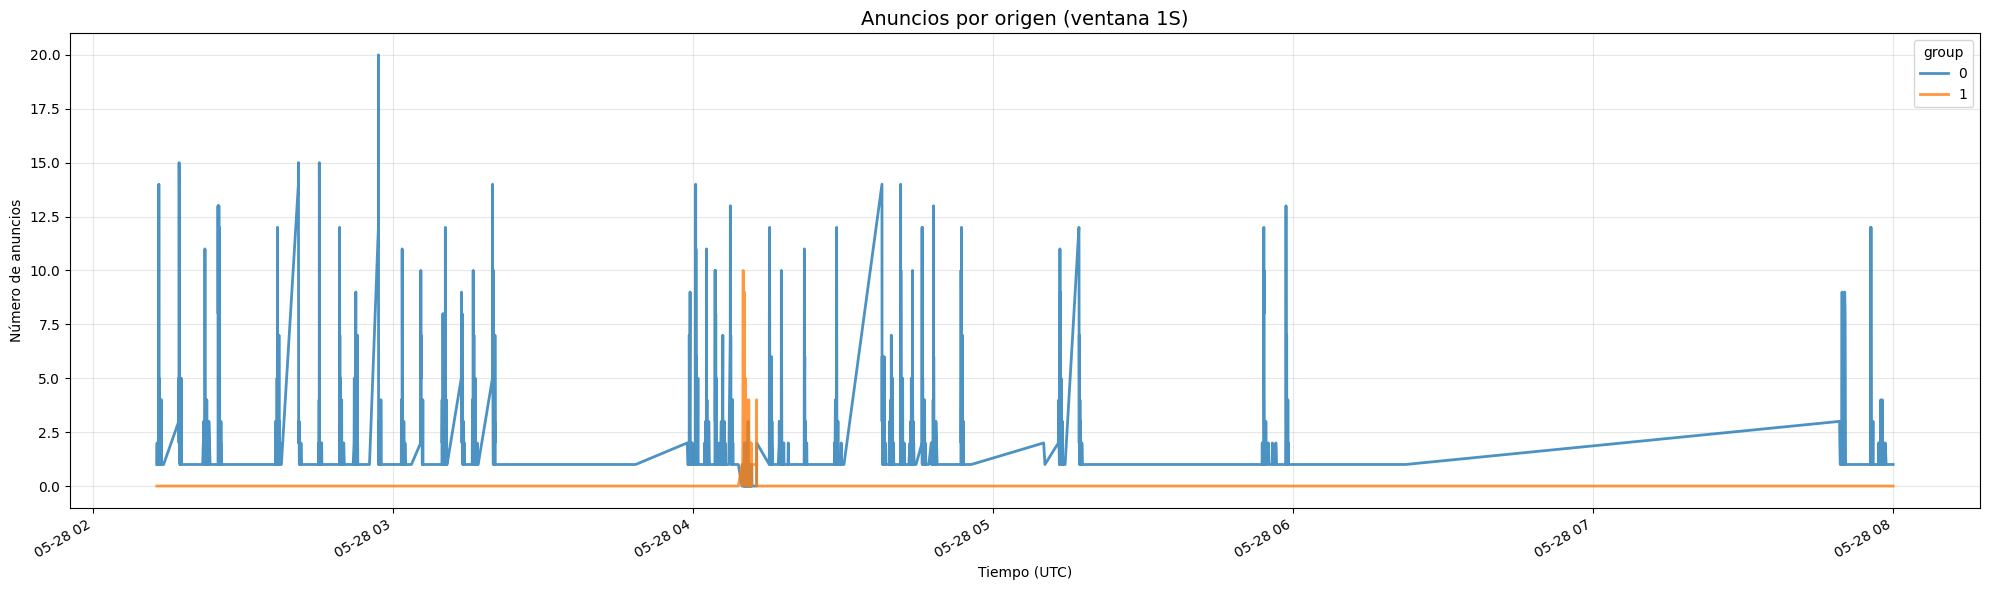

In [161]:
# convertir a datetime UTC
df_event['time_dt'] = pd.to_datetime(df_event['time'], unit='s', utc=True)

# definir frecuencia
freq = '1S'  # ejemplo: 30 segundos

# crear columna de ventana de tiempo
df_event['time_window'] = df_event['time_dt'].dt.floor(freq)

# contar ocurrencias por ventana y origen
df_event = (
    df_event.groupby(['time_window', 'group'])
      .size()
      .rename('count')
      .reset_index()
)

import matplotlib.pyplot as plt

df_pivot = df_event.pivot(index='time_window', columns='group', values='count').fillna(0)

ax = df_pivot.plot(
    kind='line',
    figsize=(20,6),
    linewidth=2,
    alpha=0.8
)

ax.set_title(f'Anuncios por origen (ventana {freq})', fontsize=14)
ax.set_xlabel('Tiempo (UTC)')
ax.set_ylabel('Número de anuncios')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [162]:
df_event[df_event['group']==1]

,time_window,group,count
770,2025-05-28 04:09:49+00:00,1,1
773,2025-05-28 04:10:03+00:00,1,4
774,2025-05-28 04:10:04+00:00,1,10
775,2025-05-28 04:10:05+00:00,1,1
776,2025-05-28 04:10:07+00:00,1,2
...,...,...,...
851,2025-05-28 04:12:11+00:00,1,1
852,2025-05-28 04:12:14+00:00,1,1
853,2025-05-28 04:12:28+00:00,1,1
854,2025-05-28 04:12:41+00:00,1,1


In [163]:
df[(df['prefix']=='156.227.32.0/21')&(df['origin']=='53013')]

,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin
5335414,1.748405e+09,route-views2.saopaulo,271253,187.16.209.34,A,156.227.32.0/21,187.16.209.34,271253 3356 52468 53013,53013
5381281,1.748405e+09,route-views.ny,54309,206.82.105.116,A,156.227.32.0/21,206.82.105.116,54309 1299 3356 52468 53013,53013
5382268,1.748405e+09,route-views.ny,209823,206.82.105.109,A,156.227.32.0/21,206.82.105.109,209823 5511 3356 52468 53013,53013
5382372,1.748405e+09,route-views.eqix,6057,206.126.236.189,A,156.227.32.0/21,206.126.236.189,6057 12956 3356 52468 53013,53013
5382693,1.748405e+09,route-views.eqix,6830,206.126.236.117,A,156.227.32.0/21,206.126.236.117,6830 3356 52468 53013,53013
...,...,...,...,...,...,...,...,...,...
6684165,1.748406e+09,route-views2.saopaulo,263541,187.16.219.247,A,156.227.32.0/21,187.16.219.247,263541 28329 22381 37468 2914 3356 52468 53013,53013
6697678,1.748406e+09,route-views.ny,398465,206.82.104.185,A,156.227.32.0/21,206.82.104.185,398465 7029 6461 3356 52468 53013,53013
6698800,1.748406e+09,route-views.eqix,17350,206.126.238.209,A,156.227.32.0/21,206.126.238.209,17350 2914 3356 52468 53013,53013
6699258,1.748406e+09,route-views.eqix,17350,206.126.238.208,A,156.227.32.0/21,206.126.238.208,17350 2914 3356 52468 53013,53013


In [166]:
df[(df['prefix']=='156.227.32.0/21')&(df['origin']=='133522')]['as_path'].value_counts()

as_path
17350 2914 3491 150684 138195 133522                       196
209823 2914 3491 150684 138195 133522                      187
49544 3356 3491 150684 138195 133522                       141
49544 2914 3491 150684 138195 133522                       133
3257 3491 150684 138195 133522                             118
                                                          ... 
263541 28329 22381 37468 3257 3491 150684 138195 133522      1
11399 11178 27552 3356 3491 150684 138195 133522             1
268976 7738 52320 12956 3491 150684 138195 133522            1
268976 7738 52320 1299 3491 150684 138195 133522             1
398465 54004 6128 174 3491 150684 138195 133522              1
Name: count, Length: 152, dtype: int64

In [164]:
df[(df['prefix']=='156.227.32.0/21')]['origin'].value_counts()

origin
133522    3515
None       985
53013      131
Name: count, dtype: int64

## Prueba dos grupos antes del evento

In [187]:
df_event = df_train[(df_train['prefix']=='156.227.32.0/21') & (df_train['type']=='A')]

EMBEDDINGS_MODEL = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(EMBEDDINGS_MODEL)

# Filtramos filas válidas
mask_valid = (
    df_event['prefix'].notna()
)

def count_unique_as(path: str) -> int:
  if path:
    toks = [t for t in path.split()]
  else:
    toks = []
  return len(set(toks))

# Combinamos prefix + as_path
df_event['state_embedding'] = df_event['prefix'].astype(str) + "|" + df_event['origin'].astype(str) + "|" + str(len(df_event['as_path']))

# Generamos embeddings solo para filas válidas
valid_texts = df_event.loc[mask_valid, 'state_embedding'].tolist()
embeddings = model.encode(valid_texts, show_progress_bar=True, convert_to_numpy=True)

for i, idx in enumerate(df_event.index[mask_valid]):
  df_event.at[idx, 'state_embedding'] = embeddings[i]

# display(df_event.head(5))

df_event.drop(columns=['collector','peer_asn','peer_ip','type','next_hop'], inplace=True)
# display(df_event.head(5))

n_clusters = 3

# Convertimos la lista de embeddings en una matriz (n_samples, embedding_dim)
X = np.vstack(df_event['state_embedding'].values)
print("Shape:", X.shape)

mbk = MiniBatchKMeans(n_clusters=n_clusters, batch_size=64, random_state=42)
df_event.loc[:,'group'] = mbk.fit_predict(X)

display(df_event.head(5))

Batches: 100%|██████████| 62/62 [00:00<00:00, 79.86it/s]


Shape: (1963, 384)


,time,prefix,as_path,origin,state_embedding,group
393768,1.748398e+09,156.227.32.0/21,6830 3491 150684 138195 133522,133522,"[0.038826745, 0.00924288, -0.07178604, 0.03482...",1
395288,1.748398e+09,156.227.32.0/21,52873 12956 3491 150684 138195 133522,133522,"[0.038826745, 0.009242841, -0.07178603, 0.0348...",2
395929,1.748398e+09,156.227.32.0/21,3257 3491 150684 138195 133522,133522,"[0.038826745, 0.009242841, -0.07178603, 0.0348...",2
396338,1.748398e+09,156.227.32.0/21,2914 3491 150684 138195 133522,133522,"[0.038826745, 0.009242841, -0.07178603, 0.0348...",2
396692,1.748398e+09,156.227.32.0/21,398465 2914 3491 150684 138195 133522,133522,"[0.038826745, 0.009242841, -0.07178603, 0.0348...",2


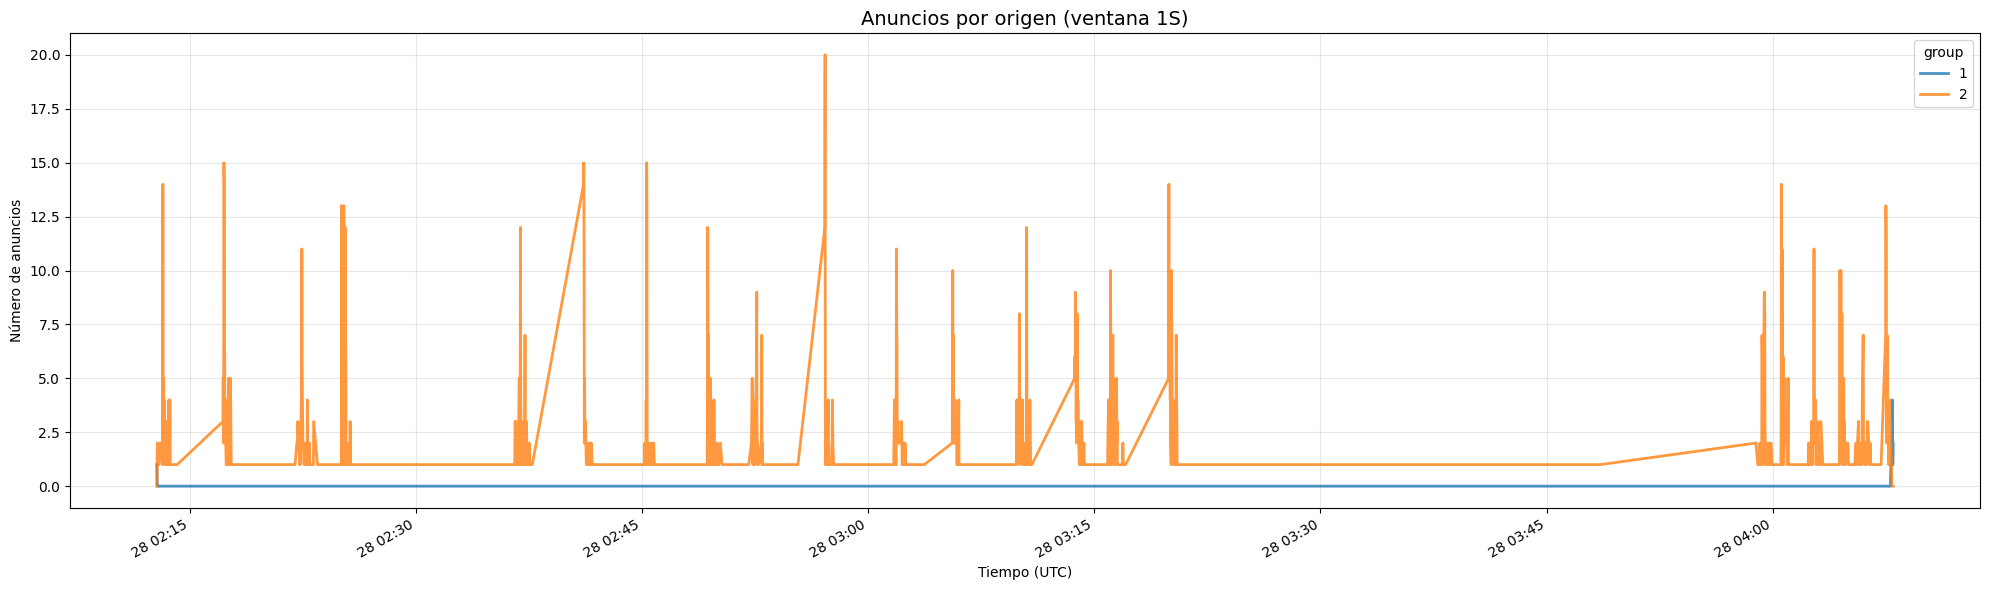

In [188]:
# convertir a datetime UTC
df_event['time_dt'] = pd.to_datetime(df_event['time'], unit='s', utc=True)

# definir frecuencia
freq = '1S'  # ejemplo: 30 segundos

# crear columna de ventana de tiempo
df_event['time_window'] = df_event['time_dt'].dt.floor(freq)

# contar ocurrencias por ventana y origen
df_event = (
    df_event.groupby(['time_window', 'group'])
      .size()
      .rename('count')
      .reset_index()
)

import matplotlib.pyplot as plt

df_pivot = df_event.pivot(index='time_window', columns='group', values='count').fillna(0)

ax = df_pivot.plot(
    kind='line',
    figsize=(20,6),
    linewidth=2,
    alpha=0.8
)

ax.set_title(f'Anuncios por origen (ventana {freq})', fontsize=14)
ax.set_xlabel('Tiempo (UTC)')
ax.set_ylabel('Número de anuncios')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [189]:
df_full = df[(df['prefix']=='156.227.32.0/21') & (df['type']=='A')]

EMBEDDINGS_MODEL = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(EMBEDDINGS_MODEL)

# Filtramos filas válidas
mask_valid = (
    df_full['prefix'].notna()
)

# Combinamos prefix + as_path
df_full['state_embedding'] = df_full['prefix'].astype(str) + "|" + df_full['origin'].astype(str) + "|" + str(len(df_full['as_path']))

# Generamos embeddings solo para filas válidas
valid_texts = df_full.loc[mask_valid, 'state_embedding'].tolist()
embeddings = model.encode(valid_texts, show_progress_bar=True, convert_to_numpy=True)

for i, idx in enumerate(df_full.index[mask_valid]):
  df_full.at[idx, 'state_embedding'] = embeddings[i]

# display(df_event.head(5))

df_full.drop(columns=['collector','peer_asn','peer_ip','type','next_hop'], inplace=True)

Batches: 100%|██████████| 114/114 [00:01<00:00, 112.59it/s]


In [190]:
# Convertimos la lista de embeddings en una matriz (n_samples, embedding_dim)
X = np.vstack(df_full['state_embedding'].values)
print("Shape:", X.shape)

df_full.loc[:,'group'] = mbk.predict(X)

display(df_full.head(5))

Shape: (3646, 384)


,time,prefix,as_path,origin,state_embedding,group
393768,1.748398e+09,156.227.32.0/21,6830 3491 150684 138195 133522,133522,"[0.05416131, -0.0016229104, -0.07827915, 0.014...",2
395288,1.748398e+09,156.227.32.0/21,52873 12956 3491 150684 138195 133522,133522,"[0.05416131, -0.0016229104, -0.07827915, 0.014...",2
395929,1.748398e+09,156.227.32.0/21,3257 3491 150684 138195 133522,133522,"[0.05416131, -0.0016229104, -0.07827915, 0.014...",2
396338,1.748398e+09,156.227.32.0/21,2914 3491 150684 138195 133522,133522,"[0.05416131, -0.0016229104, -0.07827915, 0.014...",2
396692,1.748398e+09,156.227.32.0/21,398465 2914 3491 150684 138195 133522,133522,"[0.05416131, -0.0016229104, -0.07827915, 0.014...",2


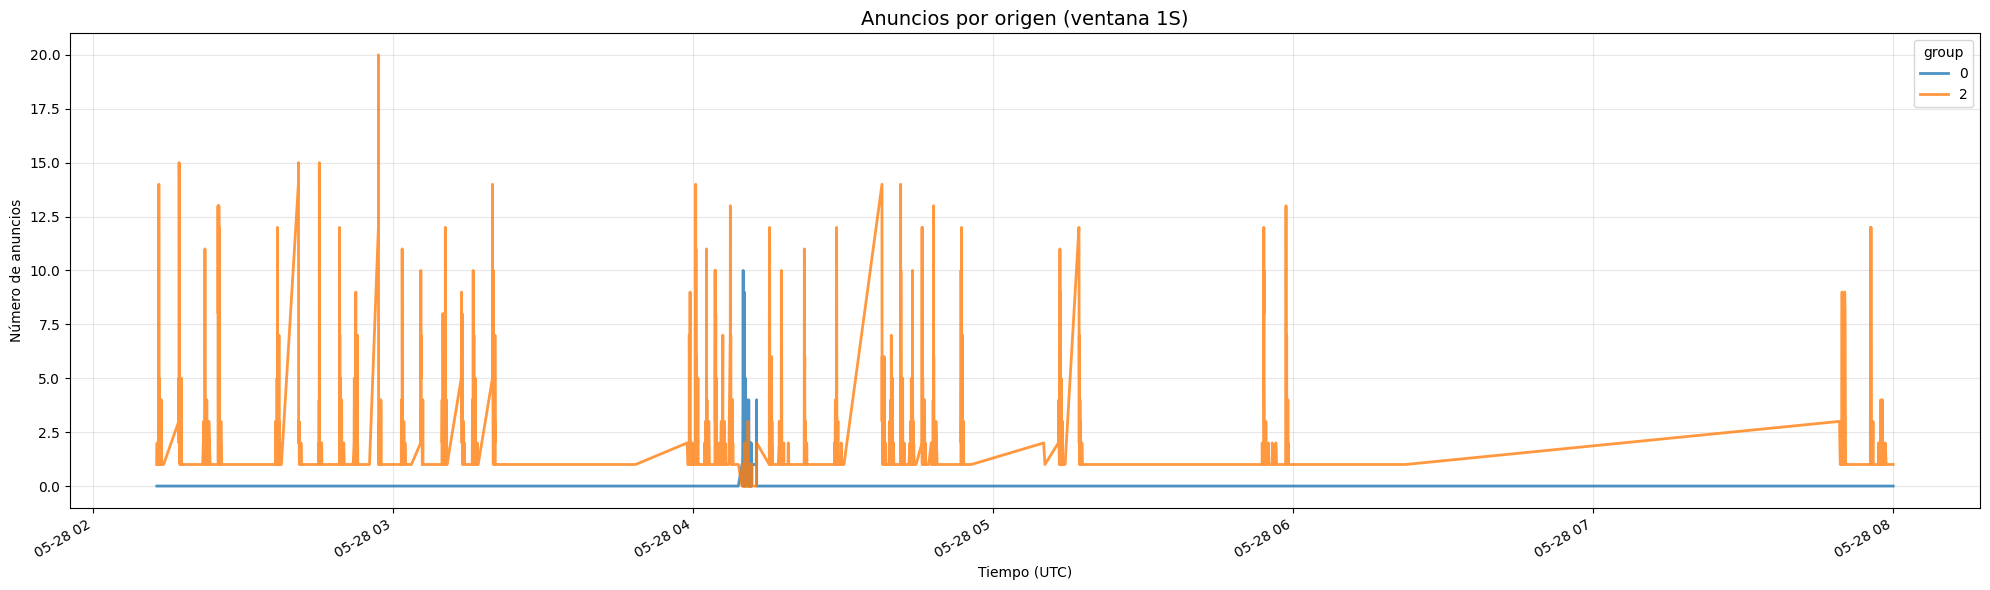

In [191]:
# convertir a datetime UTC
df_full['time_dt'] = pd.to_datetime(df_full['time'], unit='s', utc=True)

# definir frecuencia
freq = '1S'  # ejemplo: 30 segundos

# crear columna de ventana de tiempo
df_full['time_window'] = df_full['time_dt'].dt.floor(freq)

# contar ocurrencias por ventana y origen
df_full = (
    df_full.groupby(['time_window', 'group'])
      .size()
      .rename('count')
      .reset_index()
)

import matplotlib.pyplot as plt

df_pivot = df_full.pivot(index='time_window', columns='group', values='count').fillna(0)

ax = df_pivot.plot(
    kind='line',
    figsize=(20,6),
    linewidth=2,
    alpha=0.8
)

ax.set_title(f'Anuncios por origen (ventana {freq})', fontsize=14)
ax.set_xlabel('Tiempo (UTC)')
ax.set_ylabel('Número de anuncios')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [192]:
df_full['group'].value_counts()

group
2    1446
0      64
Name: count, dtype: int64

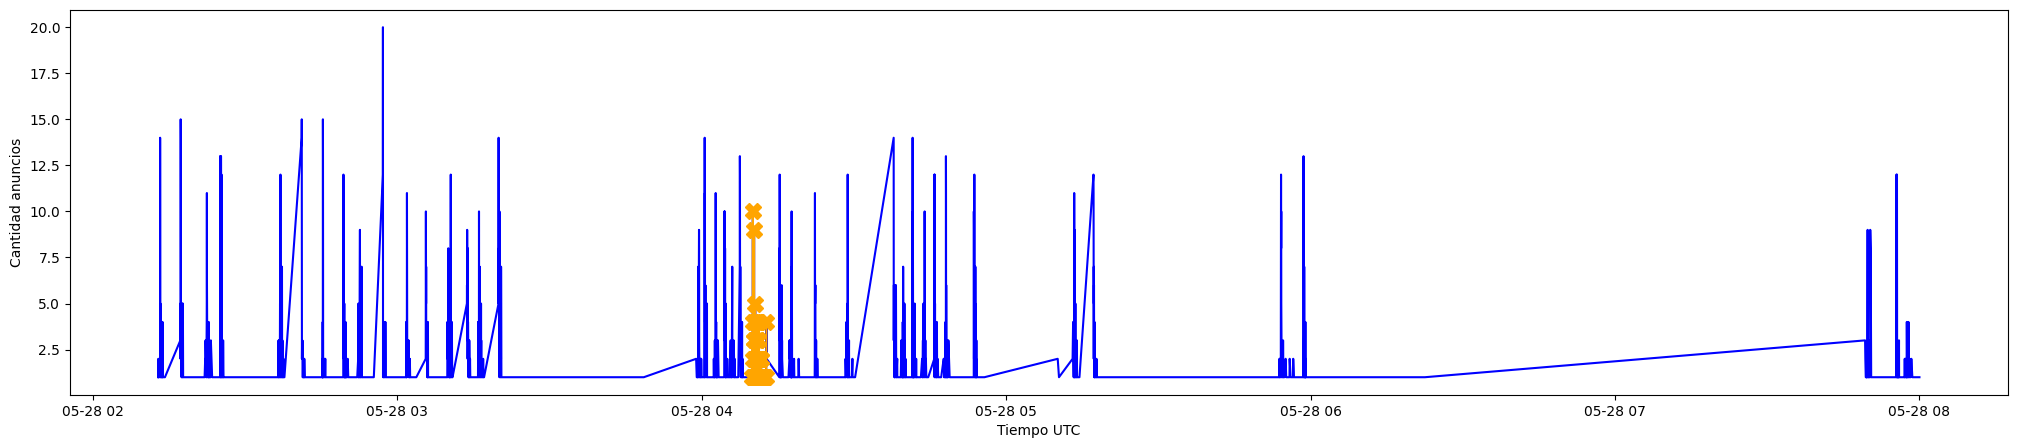

In [212]:
q1, q3 = df_full['group'].quantile([0.25,0.75])

iqr = q3 - q1

# Lower bound
lower_q = q1 - (1.5 * iqr)
# Upper bound
upper_q = q3 + (1.5 * iqr)

df_full['anomaly'] = ((df_full['group'] > upper_q) | (df_full['group'] < lower_q)).astype('int')

anomaly = df_full[(df_full['group'] > upper_q) | (df_full['group'] < lower_q)]

plt.figure(figsize=(25,5))
plt.plot(df_full['time_window'], df_full['count'], color='blue', label='Anuncios')
plt.plot(anomaly['time_window'], anomaly['count'], linestyle=None, marker='X', color='orange', markersize=12, label='Anomalia')
plt.xlabel("Tiempo UTC")
plt.ylabel("Cantidad anuncios")
plt.show()

In [206]:
df_full[df_full['group'] < lower_q].value_counts()

time_window                group  count  anomaly
2025-05-28 04:09:49+00:00  0      1      1          1
2025-05-28 04:10:03+00:00  0      4      1          1
2025-05-28 04:10:04+00:00  0      10     1          1
2025-05-28 04:10:05+00:00  0      1      1          1
2025-05-28 04:10:07+00:00  0      2      1          1
                                                   ..
2025-05-28 04:12:11+00:00  0      1      1          1
2025-05-28 04:12:14+00:00  0      1      1          1
2025-05-28 04:12:28+00:00  0      1      1          1
2025-05-28 04:12:41+00:00  0      1      1          1
2025-05-28 04:12:45+00:00  0      4      1          1
Name: count, Length: 64, dtype: int64

## Todos contra todos

In [8]:
df_prev_event_all = filter_by_utc_window(df=df,
                                start_str="2025-05-28 03:00",
                                end_str="2025-05-28 04:08")

print(f"Datos previo al evento: {df_prev_event_all.shape[0]:,} de {df.shape[0]:,}")
display(df_prev_event_all.head(5))

Datos previo al evento: 2,690,000 de 17,565,303


,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin
2113322,1.748401e+09,route-views.ny,49544,206.82.104.63,A,45.188.134.0/23,206.82.104.63,49544 12956 10429 263629 269631,269631
2113323,1.748401e+09,route-views.ny,49544,206.82.104.63,A,45.188.134.0/24,206.82.104.63,49544 12956 10429 263629 269631,269631
2113324,1.748401e+09,route-views.ny,49544,206.82.104.63,A,87.229.112.0/24,206.82.104.63,49544 9002 152672 215304 215304 214024,214024
2113325,1.748401e+09,route-views.ny,49544,206.82.104.63,A,151.242.15.0/24,206.82.104.63,49544 9002 152672 215304 215304 214654,214654
2113326,1.748401e+09,route-views2.saopaulo,52873,187.16.220.216,A,151.244.4.0/24,187.16.220.216,52873 12956 9002 152672 215304 215304 214025,214025


In [ ]:
df_event = df_prev_event_all[df_prev_event_all['type']=='A']

EMBEDDINGS_MODEL = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(EMBEDDINGS_MODEL)

# Filtramos filas válidas
mask_valid = (
    df_event['prefix'].notna()
)

def count_unique_as(path: str) -> int:
  if path:
    toks = [t for t in path.split()]
  else:
    toks = []
  return len(set(toks))

# Combinamos prefix + as_path
df_event['state_embedding'] = df_event['prefix'].astype(str) + "|" + df_event['origin'].astype(str) + "|" + str(len(df_event['as_path']))

# Generamos embeddings solo para filas válidas
valid_texts = df_event.loc[mask_valid, 'state_embedding'].tolist()
embeddings = model.encode(valid_texts, show_progress_bar=True, convert_to_numpy=True)

for i, idx in enumerate(df_event.index[mask_valid]):
  df_event.at[idx, 'state_embedding'] = embeddings[i]

# display(df_event.head(5))

df_event.drop(columns=['collector','peer_asn','peer_ip','type','next_hop'], inplace=True)
# display(df_event.head(5))

n_clusters = df['prefix'].nunique() * 2

# Convertimos la lista de embeddings en una matriz (n_samples, embedding_dim)
X = np.vstack(df_event['state_embedding'].values)
print("Shape:", X.shape)

mbk = MiniBatchKMeans(n_clusters=n_clusters, batch_size=8192, random_state=42)
df_event.loc[:,'group'] = mbk.fit_predict(X)

display(df_event.head(5))

Batches: 100%|██████████| 75035/75035 [12:27<00:00, 100.36it/s]


Shape: (2401091, 384)


,time,prefix,as_path,origin,state_embedding,group
2113322,1.748401e+09,45.188.134.0/23,49544 12956 10429 263629 269631,269631,"[0.03184762, 0.024896773, -0.022928882, 0.0069...",85
2113323,1.748401e+09,45.188.134.0/24,49544 12956 10429 263629 269631,269631,"[0.036379807, 0.027027791, -0.032723803, 0.009...",85
2113324,1.748401e+09,87.229.112.0/24,49544 9002 152672 215304 215304 214024,214024,"[-0.004650656, 0.010725304, -0.059446637, 0.01...",678
2113325,1.748401e+09,151.242.15.0/24,49544 9002 152672 215304 215304 214654,214654,"[-0.0008814428, 0.043861542, -0.041304786, -0....",4561
2113326,1.748401e+09,151.244.4.0/24,52873 12956 9002 152672 215304 215304 214025,214025,"[0.026143495, 0.014201651, -0.053882312, -0.07...",642


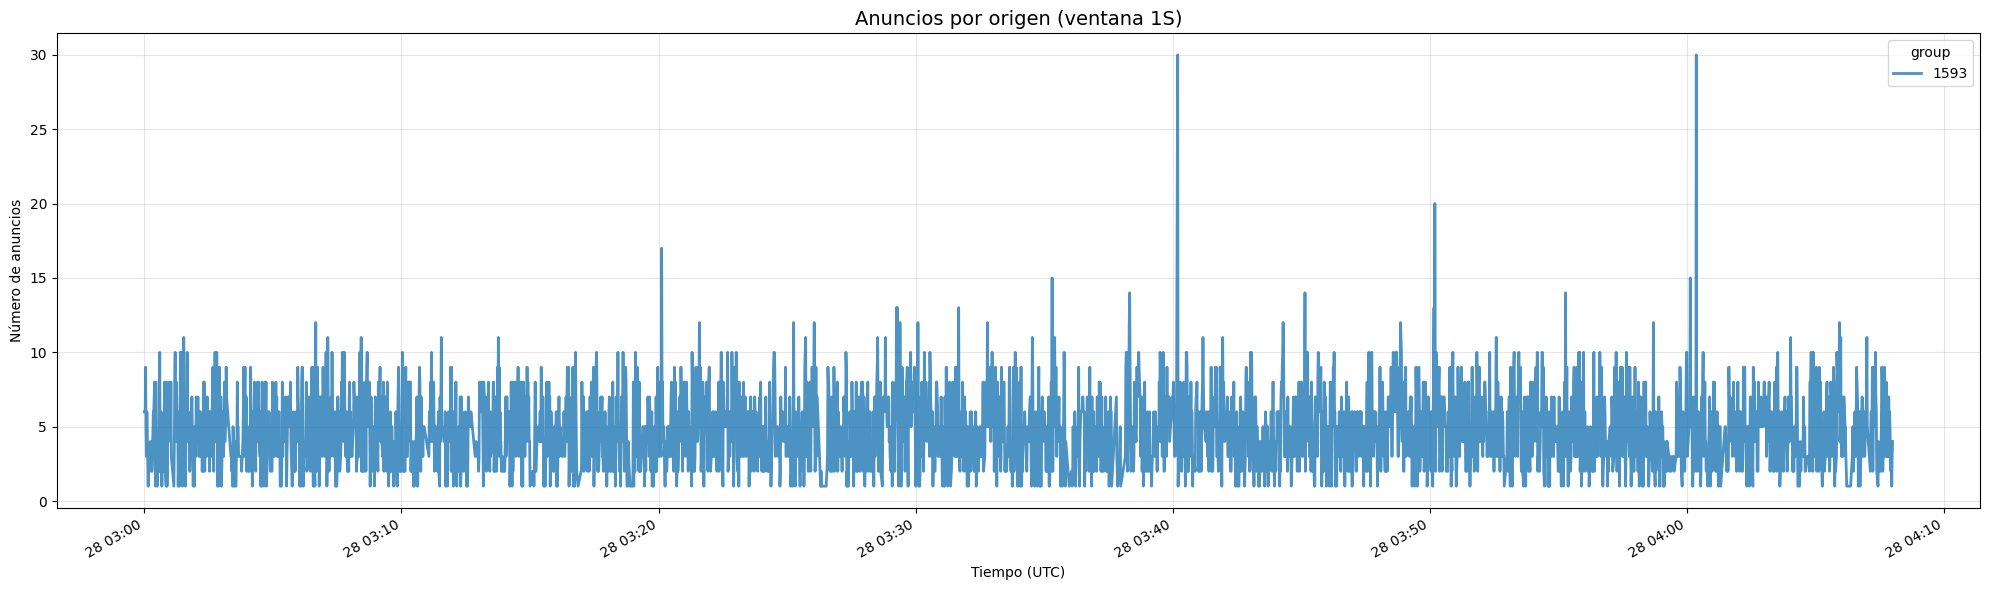

In [13]:
df_prefix = df_event[df_event['prefix']=='206.168.161.0/24']

# convertir a datetime UTC
df_prefix['time_dt'] = pd.to_datetime(df_prefix['time'], unit='s', utc=True)

# definir frecuencia
freq = '1S'  # ejemplo: 30 segundos

# crear columna de ventana de tiempo
df_prefix['time_window'] = df_prefix['time_dt'].dt.floor(freq)

# contar ocurrencias por ventana y origen
df_prefix = (
    df_prefix.groupby(['time_window', 'group'])
      .size()
      .rename('count')
      .reset_index()
)

import matplotlib.pyplot as plt

df_pivot = df_prefix.pivot(index='time_window', columns='group', values='count').fillna(0)

ax = df_pivot.plot(
    kind='line',
    figsize=(20,6),
    linewidth=2,
    alpha=0.8
)

ax.set_title(f'Anuncios por origen (ventana {freq})', fontsize=14)
ax.set_xlabel('Tiempo (UTC)')
ax.set_ylabel('Número de anuncios')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
df_all = df[(df['prefix']=='206.168.161.0/24') & (df['type']=='A')]

EMBEDDINGS_MODEL = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(EMBEDDINGS_MODEL)

# Filtramos filas válidas
mask_valid = (
    df_all['prefix'].notna()
)

# Combinamos prefix + as_path
df_all['state_embedding'] = df_all['prefix'].astype(str) + "|" + df_all['origin'].astype(str) + "|" + str(len(df_all['as_path']))

# Generamos embeddings solo para filas válidas
valid_texts = df_all.loc[mask_valid, 'state_embedding'].tolist()
embeddings = model.encode(valid_texts, show_progress_bar=True, convert_to_numpy=True)

for i, idx in enumerate(df_all.index[mask_valid]):
  df_all.at[idx, 'state_embedding'] = embeddings[i]

# display(df_event.head(5))

df_all.drop(columns=['collector','peer_asn','peer_ip','type','next_hop'], inplace=True)

Batches: 100%|██████████| 2866/2866 [00:24<00:00, 116.01it/s]


In [15]:
# Convertimos la lista de embeddings en una matriz (n_samples, embedding_dim)
X = np.vstack(df_all['state_embedding'].values)
print("Shape:", X.shape)

df_all.loc[:,'group'] = mbk.predict(X)

display(df_all.head(5))

Shape: (91711, 384)


,time,prefix,as_path,origin,state_embedding,group
13,1.748398e+09,206.168.161.0/24,49544 174 399240,399240,"[0.02245614, 0.012352483, -0.08756646, -0.0142...",1593
15,1.748398e+09,206.168.161.0/24,49544 399240,399240,"[0.02245614, 0.012352483, -0.08756646, -0.0142...",1593
211,1.748398e+09,206.168.161.0/24,49544 2914 174 399240,399240,"[0.02245614, 0.012352483, -0.08756646, -0.0142...",1593
217,1.748398e+09,206.168.161.0/24,49544 174 399240,399240,"[0.02245614, 0.012352483, -0.08756646, -0.0142...",1593
218,1.748398e+09,206.168.161.0/24,49544 1299 174 399240,399240,"[0.02245614, 0.012352483, -0.08756646, -0.0142...",1593


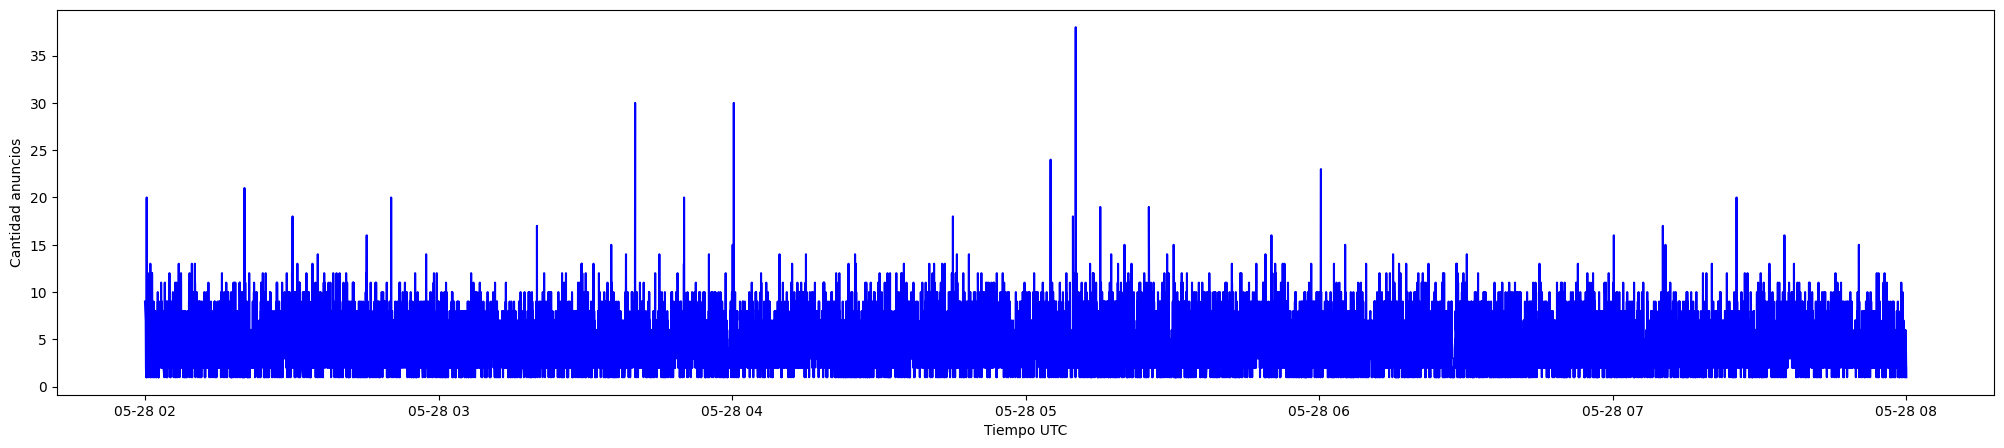

In [20]:
df_prefix = df_all[df_all['prefix']=='206.168.161.0/24']

q1, q3 = df_prefix['group'].quantile([0.25,0.75])

iqr = q3 - q1

# Lower bound
lower_q = q1 - (1.5 * iqr)
# Upper bound
upper_q = q3 + (1.5 * iqr)

# convertir a datetime UTC
df_prefix['time_dt'] = pd.to_datetime(df_prefix['time'], unit='s', utc=True)

# definir frecuencia
freq = '1S'  # ejemplo: 30 segundos

# crear columna de ventana de tiempo
df_prefix['time_window'] = df_prefix['time_dt'].dt.floor(freq)

# contar ocurrencias por ventana y origen
df_prefix = (
    df_prefix.groupby(['time_window', 'group'])
      .size()
      .rename('count')
      .reset_index()
)

#df_a['anomaly'] = ((df_prefix['group'] > upper_q) | (df_prefix['group'] < lower_q)).astype('int')

anomaly = df_prefix[(df_prefix['group'] > upper_q) | (df_prefix['group'] < lower_q)]

plt.figure(figsize=(25,5))
plt.plot(df_prefix['time_window'], df_prefix['count'], color='blue', label='Anuncios')
plt.plot(anomaly['time_window'], anomaly['count'], linestyle=None, marker='X', color='orange', markersize=12, label='Anomalia')
plt.xlabel("Tiempo UTC")
plt.ylabel("Cantidad anuncios")
plt.show()

Batches: 100%|██████████| 2009/2009 [00:21<00:00, 93.45it/s]


Shape: (64270, 384)


,time,prefix,as_path,origin,state_embedding,group
700,1.748398e+09,164.163.52.0/22,20253 174 52468 52840 265953 265953 265953,265953,"[0.07677167, 0.004599676, -0.05705646, -0.0115...",645
1185,1.748398e+09,164.163.52.0/22,209823 5511 12956 10429 265953,265953,"[0.07677171, 0.0045996946, -0.05705645, -0.011...",645
1250,1.748398e+09,164.163.52.0/22,49544 12956 10429 265953,265953,"[0.07677171, 0.0045996946, -0.05705645, -0.011...",645
2249,1.748398e+09,164.163.52.0/22,49544 1031 265953,265953,"[0.07677171, 0.0045996946, -0.05705645, -0.011...",645
2523,1.748398e+09,164.163.52.0/22,6079 3356 12956 10429 265953,265953,"[0.07677171, 0.0045996946, -0.05705645, -0.011...",645


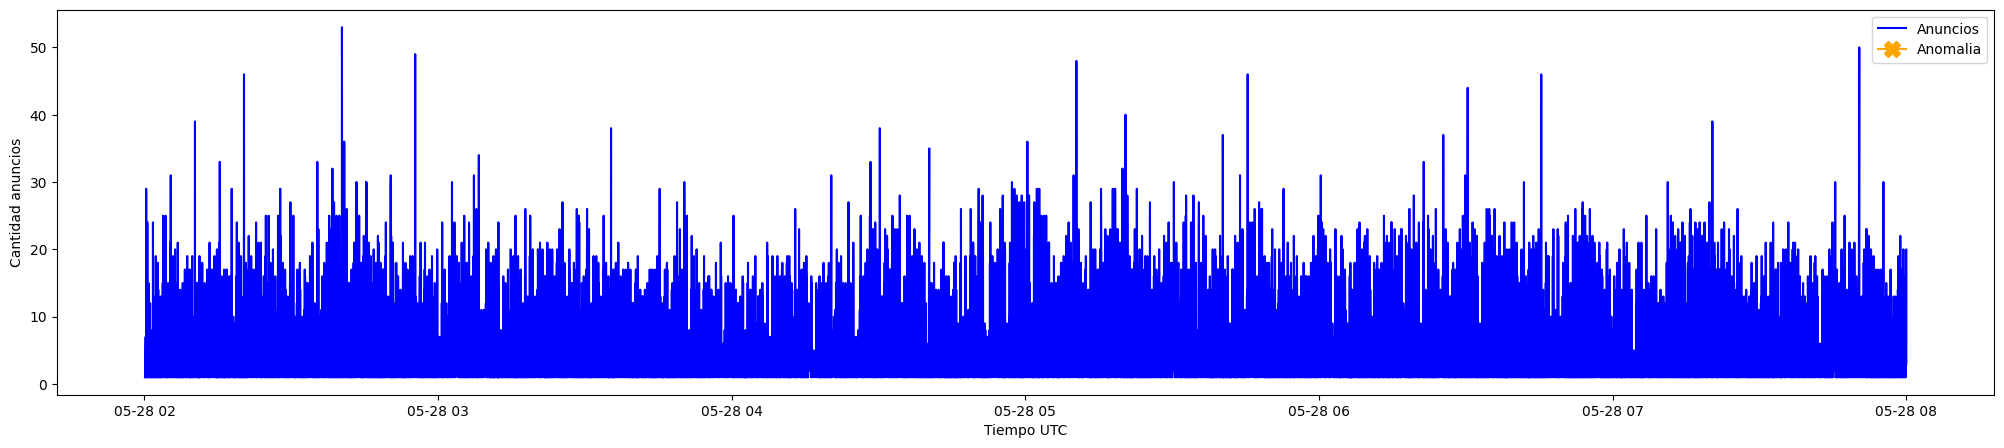

In [22]:
prefix  ='164.163.52.0/22'

df_all = df[(df['prefix']==prefix) & (df['type']=='A')]

EMBEDDINGS_MODEL = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(EMBEDDINGS_MODEL)

# Filtramos filas válidas
mask_valid = (
    df_all['prefix'].notna()
)

# Combinamos prefix + as_path
df_all['state_embedding'] = df_all['prefix'].astype(str) + "|" + df_all['origin'].astype(str) + "|" + str(len(df_all['as_path']))

# Generamos embeddings solo para filas válidas
valid_texts = df_all.loc[mask_valid, 'state_embedding'].tolist()
embeddings = model.encode(valid_texts, show_progress_bar=True, convert_to_numpy=True)

for i, idx in enumerate(df_all.index[mask_valid]):
  df_all.at[idx, 'state_embedding'] = embeddings[i]

# display(df_event.head(5))

df_all.drop(columns=['collector','peer_asn','peer_ip','type','next_hop'], inplace=True)

# Convertimos la lista de embeddings en una matriz (n_samples, embedding_dim)
X = np.vstack(df_all['state_embedding'].values)
print("Shape:", X.shape)

df_all.loc[:,'group'] = mbk.predict(X)

display(df_all.head(5))

df_prefix = df_all[df_all['prefix']==prefix]

q1, q3 = df_prefix['group'].quantile([0.25,0.75])

iqr = q3 - q1

# Lower bound
lower_q = q1 - (1.5 * iqr)
# Upper bound
upper_q = q3 + (1.5 * iqr)

# convertir a datetime UTC
df_prefix['time_dt'] = pd.to_datetime(df_prefix['time'], unit='s', utc=True)

# definir frecuencia
freq = '1S'  # ejemplo: 30 segundos

# crear columna de ventana de tiempo
df_prefix['time_window'] = df_prefix['time_dt'].dt.floor(freq)

# contar ocurrencias por ventana y origen
df_prefix = (
    df_prefix.groupby(['time_window', 'group'])
      .size()
      .rename('count')
      .reset_index()
)

#df_a['anomaly'] = ((df_prefix['group'] > upper_q) | (df_prefix['group'] < lower_q)).astype('int')

anomaly = df_prefix[(df_prefix['group'] > upper_q) | (df_prefix['group'] < lower_q)]

plt.figure(figsize=(25,5))
plt.plot(df_prefix['time_window'], df_prefix['count'], color='blue', label='Anuncios')
plt.plot(anomaly['time_window'], anomaly['count'], linestyle=None, marker='X', color='orange', markersize=12, label='Anomalia')
plt.legend(loc='best')
plt.xlabel("Tiempo UTC")
plt.ylabel("Cantidad anuncios")
plt.show()

Batches: 100%|██████████| 1662/1662 [00:13<00:00, 121.39it/s]


Shape: (53153, 384)


,time,prefix,as_path,origin,state_embedding,group
380,1.748398e+09,168.0.128.0/22,209823 2914 3356 267613 263069,263069,"[0.024215082, 0.032086443, -0.08602403, -0.008...",3589
450,1.748398e+09,168.0.128.0/22,49544 2914 3356 267613 263069,263069,"[0.02421505, 0.03208645, -0.08602407, -0.00801...",3589
532,1.748398e+09,168.0.128.0/22,398465 3257 174 14840 262342 61621 61621 61621...,263069,"[0.02421505, 0.03208645, -0.08602407, -0.00801...",3589
535,1.748398e+09,168.0.128.0/22,398465 3257 3356 61621 61621 61621 61621 263069,263069,"[0.02421505, 0.03208645, -0.08602407, -0.00801...",3589
561,1.748398e+09,168.0.128.0/22,209823 2914 3356 267613 263069,263069,"[0.02421505, 0.03208645, -0.08602407, -0.00801...",3589


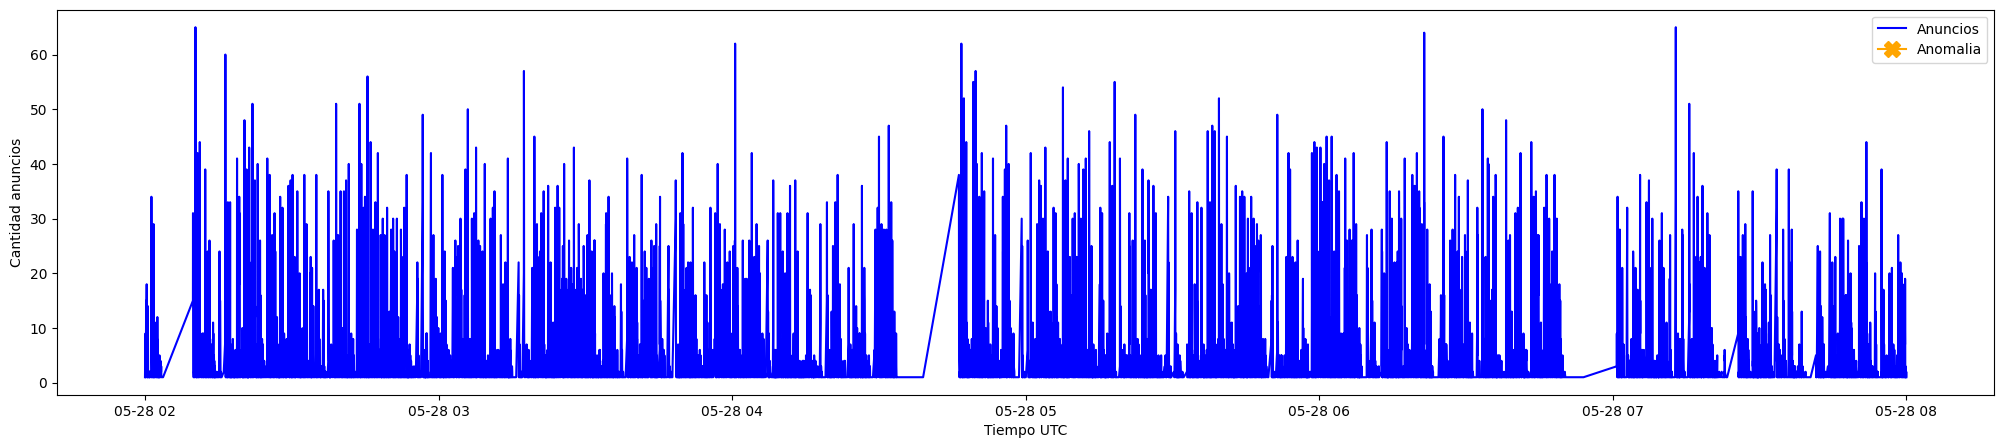

In [23]:
prefix  ='168.0.128.0/22'

df_all = df[(df['prefix']==prefix) & (df['type']=='A')]

EMBEDDINGS_MODEL = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(EMBEDDINGS_MODEL)

# Filtramos filas válidas
mask_valid = (
    df_all['prefix'].notna()
)

# Combinamos prefix + as_path
df_all['state_embedding'] = df_all['prefix'].astype(str) + "|" + df_all['origin'].astype(str) + "|" + str(len(df_all['as_path']))

# Generamos embeddings solo para filas válidas
valid_texts = df_all.loc[mask_valid, 'state_embedding'].tolist()
embeddings = model.encode(valid_texts, show_progress_bar=True, convert_to_numpy=True)

for i, idx in enumerate(df_all.index[mask_valid]):
  df_all.at[idx, 'state_embedding'] = embeddings[i]

# display(df_event.head(5))

df_all.drop(columns=['collector','peer_asn','peer_ip','type','next_hop'], inplace=True)

# Convertimos la lista de embeddings en una matriz (n_samples, embedding_dim)
X = np.vstack(df_all['state_embedding'].values)
print("Shape:", X.shape)

df_all.loc[:,'group'] = mbk.predict(X)

display(df_all.head(5))

df_prefix = df_all[df_all['prefix']==prefix]

q1, q3 = df_prefix['group'].quantile([0.25,0.75])

iqr = q3 - q1

# Lower bound
lower_q = q1 - (1.5 * iqr)
# Upper bound
upper_q = q3 + (1.5 * iqr)

# convertir a datetime UTC
df_prefix['time_dt'] = pd.to_datetime(df_prefix['time'], unit='s', utc=True)

# definir frecuencia
freq = '1S'  # ejemplo: 30 segundos

# crear columna de ventana de tiempo
df_prefix['time_window'] = df_prefix['time_dt'].dt.floor(freq)

# contar ocurrencias por ventana y origen
df_prefix = (
    df_prefix.groupby(['time_window', 'group'])
      .size()
      .rename('count')
      .reset_index()
)

#df_a['anomaly'] = ((df_prefix['group'] > upper_q) | (df_prefix['group'] < lower_q)).astype('int')

anomaly = df_prefix[(df_prefix['group'] > upper_q) | (df_prefix['group'] < lower_q)]

plt.figure(figsize=(25,5))
plt.plot(df_prefix['time_window'], df_prefix['count'], color='blue', label='Anuncios')
plt.plot(anomaly['time_window'], anomaly['count'], linestyle=None, marker='X', color='orange', markersize=12, label='Anomalia')
plt.legend(loc='best')
plt.xlabel("Tiempo UTC")
plt.ylabel("Cantidad anuncios")
plt.show()

Batches: 100%|██████████| 3/3 [00:00<00:00, 30.88it/s]

Shape: (88, 384)


,time,prefix,as_path,origin,state_embedding,group
5382668,1.748405e+09,170.251.90.0/24,209823 5511 3356 52468 53013,53013,"[0.0076527917, 0.013831139, -0.07574631, -0.01...",3966
5385636,1.748405e+09,170.251.90.0/24,49544 3356 52468 53013,53013,"[0.0076527917, 0.013831139, -0.07574631, -0.01...",3966
5388274,1.748405e+09,170.251.90.0/24,17350 3356 52468 53013,53013,"[0.0076527917, 0.013831139, -0.07574631, -0.01...",3966
5388618,1.748405e+09,170.251.90.0/24,49544 3356 52468 53013,53013,"[0.0076527917, 0.013831139, -0.07574631, -0.01...",3966
5389201,1.748405e+09,170.251.90.0/24,17350 3356 52468 53013,53013,"[0.0076527917, 0.013831139, -0.07574631, -0.01...",3966


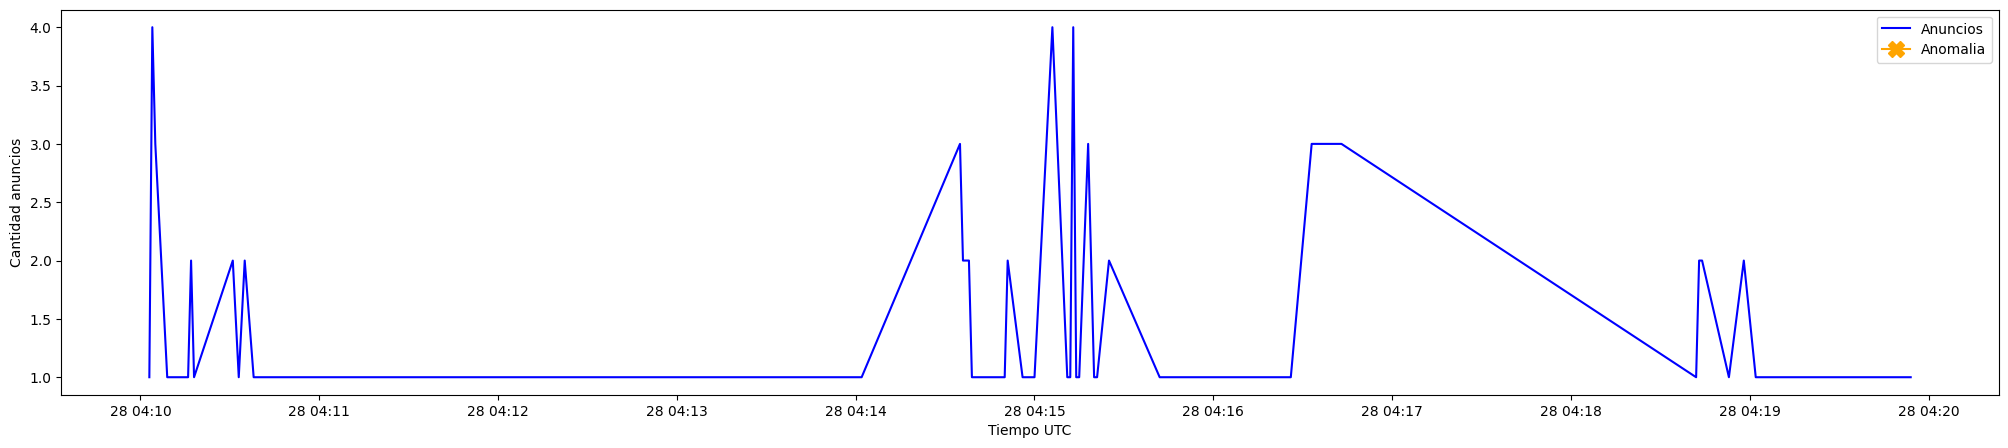

In [24]:
prefix = '170.251.90.0/24'

df_all = df[(df['prefix']==prefix) & (df['type']=='A')]

EMBEDDINGS_MODEL = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(EMBEDDINGS_MODEL)

# Filtramos filas válidas
mask_valid = (
    df_all['prefix'].notna()
)

# Combinamos prefix + as_path
df_all['state_embedding'] = df_all['prefix'].astype(str) + "|" + df_all['origin'].astype(str) + "|" + str(len(df_all['as_path']))

# Generamos embeddings solo para filas válidas
valid_texts = df_all.loc[mask_valid, 'state_embedding'].tolist()
embeddings = model.encode(valid_texts, show_progress_bar=True, convert_to_numpy=True)

for i, idx in enumerate(df_all.index[mask_valid]):
  df_all.at[idx, 'state_embedding'] = embeddings[i]

# display(df_event.head(5))

df_all.drop(columns=['collector','peer_asn','peer_ip','type','next_hop'], inplace=True)

# Convertimos la lista de embeddings en una matriz (n_samples, embedding_dim)
X = np.vstack(df_all['state_embedding'].values)
print("Shape:", X.shape)

df_all.loc[:,'group'] = mbk.predict(X)

display(df_all.head(5))

df_prefix = df_all[df_all['prefix']==prefix]

q1, q3 = df_prefix['group'].quantile([0.25,0.75])

iqr = q3 - q1

# Lower bound
lower_q = q1 - (1.5 * iqr)
# Upper bound
upper_q = q3 + (1.5 * iqr)

# convertir a datetime UTC
df_prefix['time_dt'] = pd.to_datetime(df_prefix['time'], unit='s', utc=True)

# definir frecuencia
freq = '1S'  # ejemplo: 30 segundos

# crear columna de ventana de tiempo
df_prefix['time_window'] = df_prefix['time_dt'].dt.floor(freq)

# contar ocurrencias por ventana y origen
df_prefix = (
    df_prefix.groupby(['time_window', 'group'])
      .size()
      .rename('count')
      .reset_index()
)

#df_a['anomaly'] = ((df_prefix['group'] > upper_q) | (df_prefix['group'] < lower_q)).astype('int')

anomaly = df_prefix[(df_prefix['group'] > upper_q) | (df_prefix['group'] < lower_q)]

plt.figure(figsize=(25,5))
plt.plot(df_prefix['time_window'], df_prefix['count'], color='blue', label='Anuncios')
plt.plot(anomaly['time_window'], anomaly['count'], linestyle=None, marker='X', color='orange', markersize=12, label='Anomalia')
plt.legend(loc='best')
plt.xlabel("Tiempo UTC")
plt.ylabel("Cantidad anuncios")
plt.show()

In [27]:
df_all[['origin','group']].value_counts()

origin  group
53013   3966     66
3573    3966     22
Name: count, dtype: int64

In [28]:
df_all.head(88)

,time,prefix,as_path,origin,state_embedding,group
5382668,1.748405e+09,170.251.90.0/24,209823 5511 3356 52468 53013,53013,"[0.0076527917, 0.013831139, -0.07574631, -0.01...",3966
5385636,1.748405e+09,170.251.90.0/24,49544 3356 52468 53013,53013,"[0.0076527917, 0.013831139, -0.07574631, -0.01...",3966
5388274,1.748405e+09,170.251.90.0/24,17350 3356 52468 53013,53013,"[0.0076527917, 0.013831139, -0.07574631, -0.01...",3966
5388618,1.748405e+09,170.251.90.0/24,49544 3356 52468 53013,53013,"[0.0076527917, 0.013831139, -0.07574631, -0.01...",3966
5389201,1.748405e+09,170.251.90.0/24,17350 3356 52468 53013,53013,"[0.0076527917, 0.013831139, -0.07574631, -0.01...",3966
...,...,...,...,...,...,...
7800434,1.748406e+09,170.251.90.0/24,19151 2914 3356 52468 53013,53013,"[0.0076527824, 0.013831151, -0.07574626, -0.01...",3966
7806022,1.748406e+09,170.251.90.0/24,17350 3356 52965 52965 52965 3573,3573,"[-0.0147421695, 0.03984898, -0.085423864, -0.0...",3966
7806489,1.748406e+09,170.251.90.0/24,17350 6453 6762 26615 52965 3573,3573,"[-0.0147421695, 0.03984898, -0.085423864, -0.0...",3966
7810434,1.748406e+09,170.251.90.0/24,40934 7018 6762 26615 52965 3573,3573,"[-0.0147421695, 0.03984898, -0.085423864, -0.0...",3966


Batches: 100%|██████████| 44/44 [00:00<00:00, 84.48it/s]

Shape: (1392, 384)


,time,prefix,as_path,origin,state_embedding,group
393087,1.748398e+09,137.59.18.0/24,6830 174 3786 138195 138195,138195,"[-0.015898777, 0.031954773, -0.018096158, 0.03...",4193
393419,1.748398e+09,137.59.18.0/24,6830 3491 150684 138195,138195,"[-0.015898777, 0.031954773, -0.018096158, 0.03...",4193
395083,1.748398e+09,137.59.18.0/24,52873 12956 3491 150684 138195,138195,"[-0.015898777, 0.031954773, -0.018096158, 0.03...",4193
395667,1.748398e+09,137.59.18.0/24,3257 3491 150684 138195,138195,"[-0.015898777, 0.031954773, -0.018096158, 0.03...",4193
397358,1.748398e+09,137.59.18.0/24,11039 4901 11164 3786 138195 138195,138195,"[-0.015898777, 0.031954773, -0.018096158, 0.03...",4193


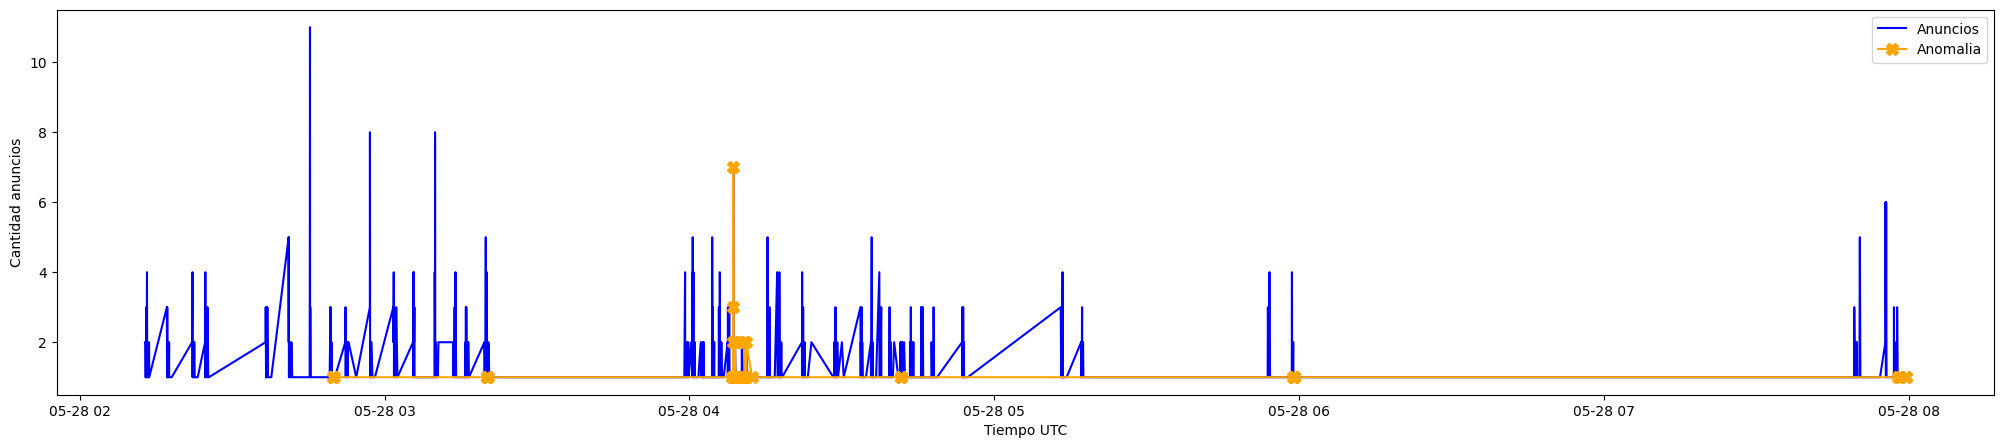

In [32]:
prefix = '137.59.18.0/24'

df_all = df[(df['prefix']==prefix) & (df['type']=='A')]

EMBEDDINGS_MODEL = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(EMBEDDINGS_MODEL)

# Filtramos filas válidas
mask_valid = (
    df_all['prefix'].notna()
)

# Combinamos prefix + as_path
df_all['state_embedding'] = df_all['prefix'].astype(str) + "|" + df_all['origin'].astype(str) + "|" + str(len(df_all['as_path']))

# Generamos embeddings solo para filas válidas
valid_texts = df_all.loc[mask_valid, 'state_embedding'].tolist()
embeddings = model.encode(valid_texts, show_progress_bar=True, convert_to_numpy=True)

for i, idx in enumerate(df_all.index[mask_valid]):
  df_all.at[idx, 'state_embedding'] = embeddings[i]

# display(df_event.head(5))

df_all.drop(columns=['collector','peer_asn','peer_ip','type','next_hop'], inplace=True)

# Convertimos la lista de embeddings en una matriz (n_samples, embedding_dim)
X = np.vstack(df_all['state_embedding'].values)
print("Shape:", X.shape)

df_all.loc[:,'group'] = mbk.predict(X)

display(df_all.head(5))

df_prefix = df_all[df_all['prefix']==prefix]

q1, q3 = df_prefix['group'].quantile([0.25,0.75])

iqr = q3 - q1

# Lower bound
lower_q = q1 - (1.5 * iqr)
# Upper bound
upper_q = q3 + (1.5 * iqr)

# convertir a datetime UTC
df_prefix['time_dt'] = pd.to_datetime(df_prefix['time'], unit='s', utc=True)

# definir frecuencia
freq = '1S'  # ejemplo: 30 segundos

# crear columna de ventana de tiempo
df_prefix['time_window'] = df_prefix['time_dt'].dt.floor(freq)

# contar ocurrencias por ventana y origen
df_prefix = (
    df_prefix.groupby(['time_window', 'group'])
      .size()
      .rename('count')
      .reset_index()
)

#df_a['anomaly'] = ((df_prefix['group'] > upper_q) | (df_prefix['group'] < lower_q)).astype('int')

anomaly = df_prefix[(df_prefix['group'] > upper_q) | (df_prefix['group'] < lower_q)]

plt.figure(figsize=(25,5))
plt.plot(df_prefix['time_window'], df_prefix['count'], color='blue', label='Anuncios')
plt.plot(anomaly['time_window'], anomaly['count'], linestyle=None, marker='X', color='orange', markersize=8, label='Anomalia')
plt.legend(loc='best')
plt.xlabel("Tiempo UTC")
plt.ylabel("Cantidad anuncios")
plt.show()

## Lo otro

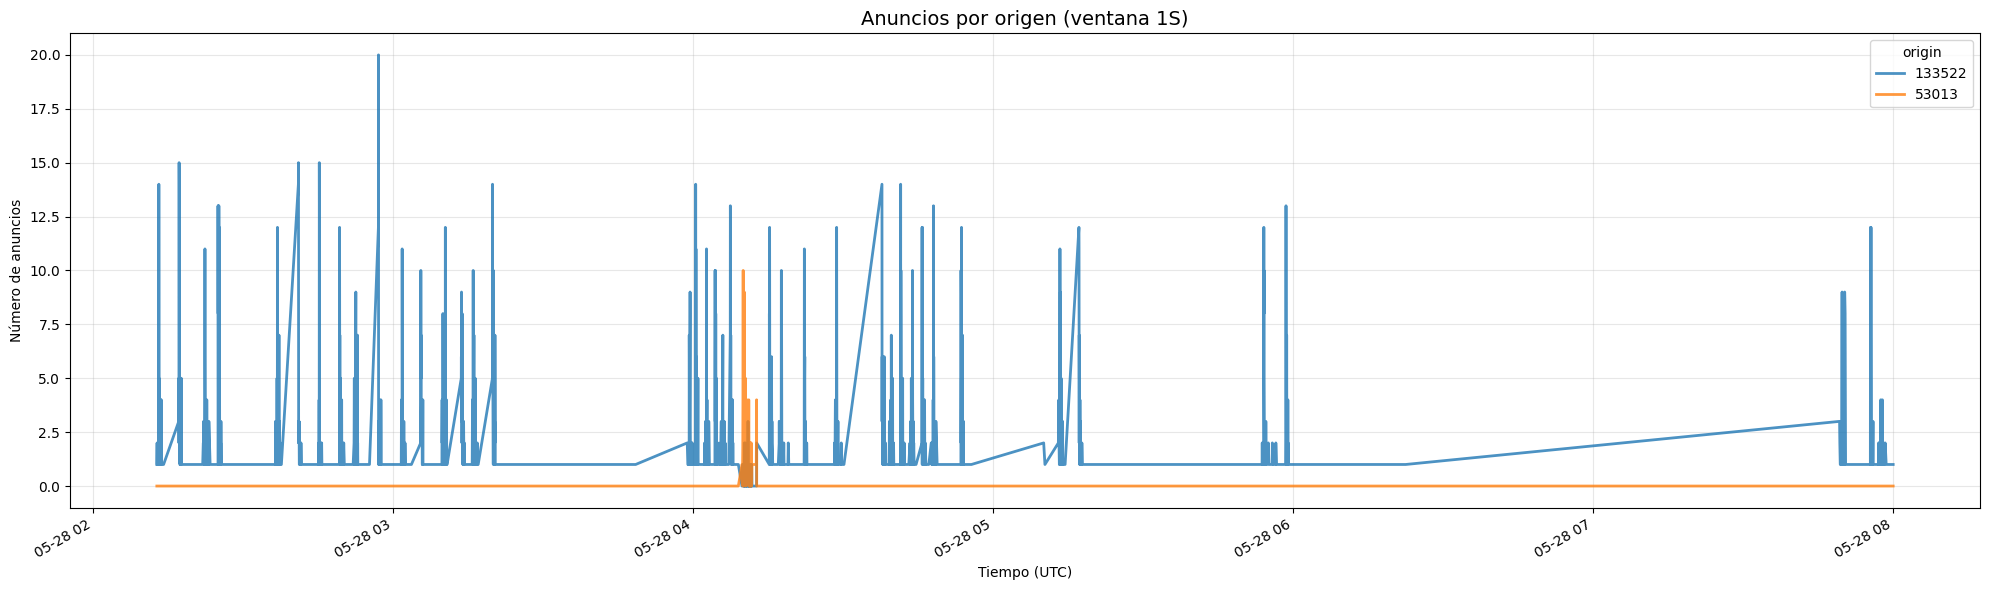

In [111]:
# convertir a datetime UTC
df_testing['time_dt'] = pd.to_datetime(df_testing['time'], unit='s', utc=True)

# definir frecuencia
freq = '1S'  # ejemplo: 30 segundos

# crear columna de ventana de tiempo
df_testing['time_window'] = df_testing['time_dt'].dt.floor(freq)

# contar ocurrencias por ventana y origen
df_testing_counts = (
    df_testing.groupby(['time_window', 'origin'])
      .size()
      .rename('count')
      .reset_index()
)

import matplotlib.pyplot as plt

df_pivot = df_testing_counts.pivot(index='time_window', columns='origin', values='count').fillna(0)

ax = df_pivot.plot(
    kind='line',
    figsize=(20,6),
    linewidth=2,
    alpha=0.8
)

ax.set_title(f'Anuncios por origen (ventana {freq})', fontsize=14)
ax.set_xlabel('Tiempo (UTC)')
ax.set_ylabel('Número de anuncios')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [112]:
df_testing_counts

,time_window,origin,count
0,2025-05-28 02:12:50+00:00,133522,1
1,2025-05-28 02:12:52+00:00,133522,2
2,2025-05-28 02:12:53+00:00,133522,2
3,2025-05-28 02:12:54+00:00,133522,1
4,2025-05-28 02:12:58+00:00,133522,1
...,...,...,...
1505,2025-05-28 07:59:26+00:00,133522,1
1506,2025-05-28 07:59:32+00:00,133522,1
1507,2025-05-28 07:59:38+00:00,133522,1
1508,2025-05-28 07:59:47+00:00,133522,1


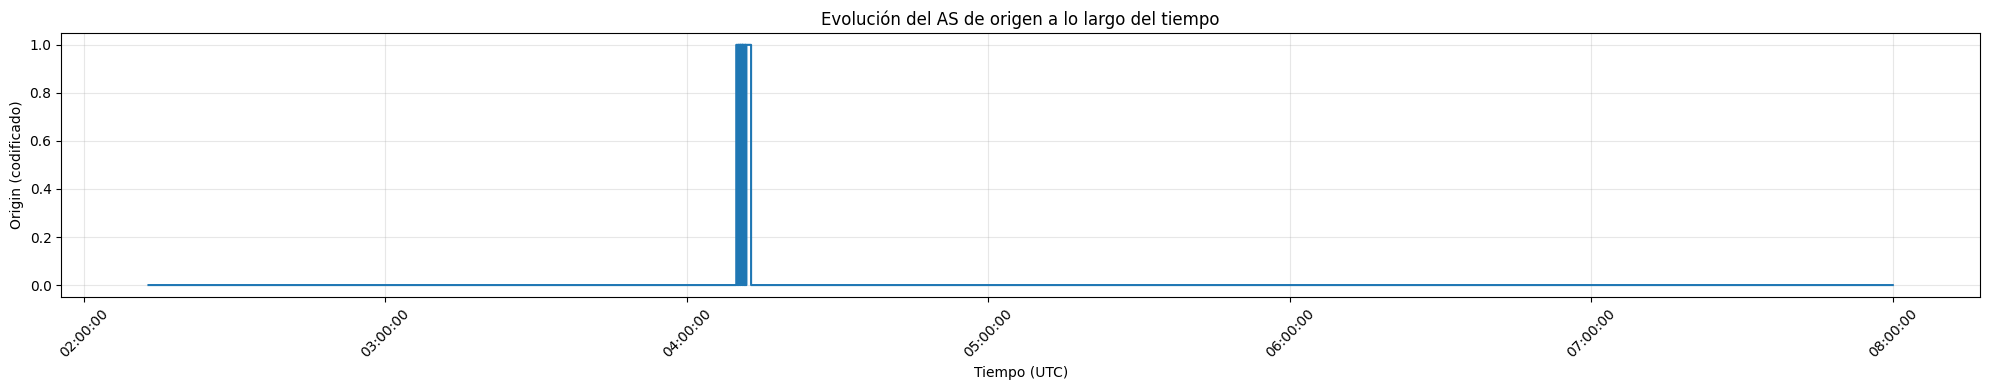

In [ ]:
from sklearn.preprocessing import LabelEncoder

import matplotlib.dates as mdates

le = LabelEncoder()
df_testing_counts['origin_encoded'] = le.fit_transform(df_testing_counts['origin'])

fig, ax = plt.subplots(figsize=(20,4))

ax.step(df_testing_counts['time_window'], df_testing_counts['origin_encoded'], where='post', color='tab:blue')

ax.set_title('Evolución del AS de origen a lo largo del tiempo')
ax.set_xlabel('Tiempo (UTC)')
ax.set_ylabel('Origin (codificado)')

# 👉 Formato personalizado del eje X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S', tz=df_testing_counts['time_window'].dt.tz))

# Espaciado automático de ticks
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

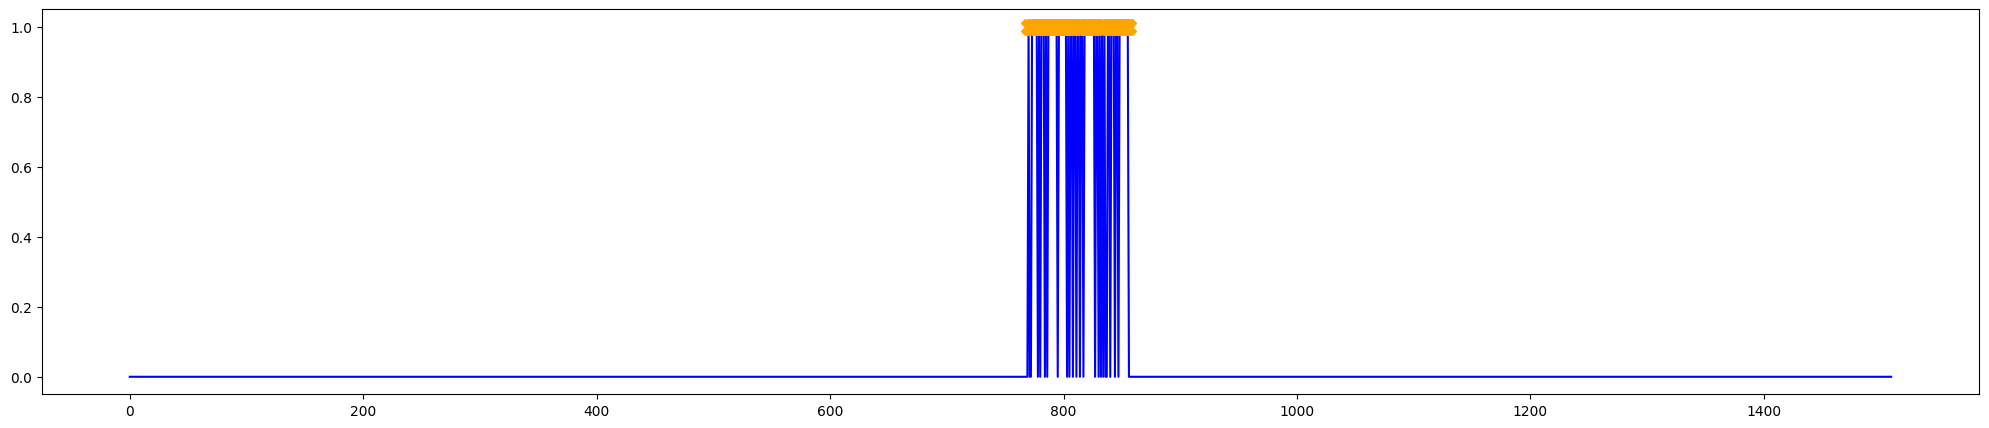

In [ ]:
q1, q3 = df_testing_counts['origin_encoded'].quantile([0.25,0.75])

iqr = q3 - q1

# Lower bound
lower_q = q1 - (1.5 * iqr)
# Upper bound
upper_q = q3 + (1.5 * iqr)

df_testing_counts['anomaly'] = ((df_testing_counts['origin_encoded'] > upper_q) | (df_testing_counts['origin_encoded'] < lower_q)).astype('int')

anomaly = df_testing_counts[df_testing_counts['origin_encoded']==1]

plt.figure(figsize=(25,5))
plt.plot(df_testing_counts['origin_encoded'], color='blue', label='Anuncios')
plt.plot(anomaly['anomaly'], linestyle=None, marker='X', color='orange', markersize=12, label='Anomalia')
plt.show()

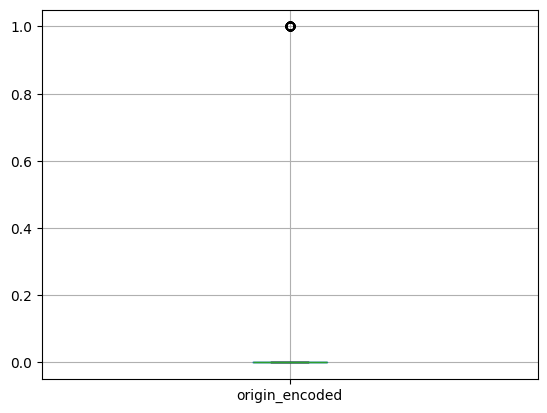

In [124]:
boxplot = df_testing_counts.boxplot(column=['origin_encoded'])
plt.show()

In [122]:
q1

0.0

In [123]:
q3

0.0

In [115]:
df_testing_counts

,time_window,origin,count,origin_encoded
0,2025-05-28 02:12:50+00:00,133522,1,0
1,2025-05-28 02:12:52+00:00,133522,2,0
2,2025-05-28 02:12:53+00:00,133522,2,0
3,2025-05-28 02:12:54+00:00,133522,1,0
4,2025-05-28 02:12:58+00:00,133522,1,0
...,...,...,...,...
1505,2025-05-28 07:59:26+00:00,133522,1,0
1506,2025-05-28 07:59:32+00:00,133522,1,0
1507,2025-05-28 07:59:38+00:00,133522,1,0
1508,2025-05-28 07:59:47+00:00,133522,1,0


# Pruebas

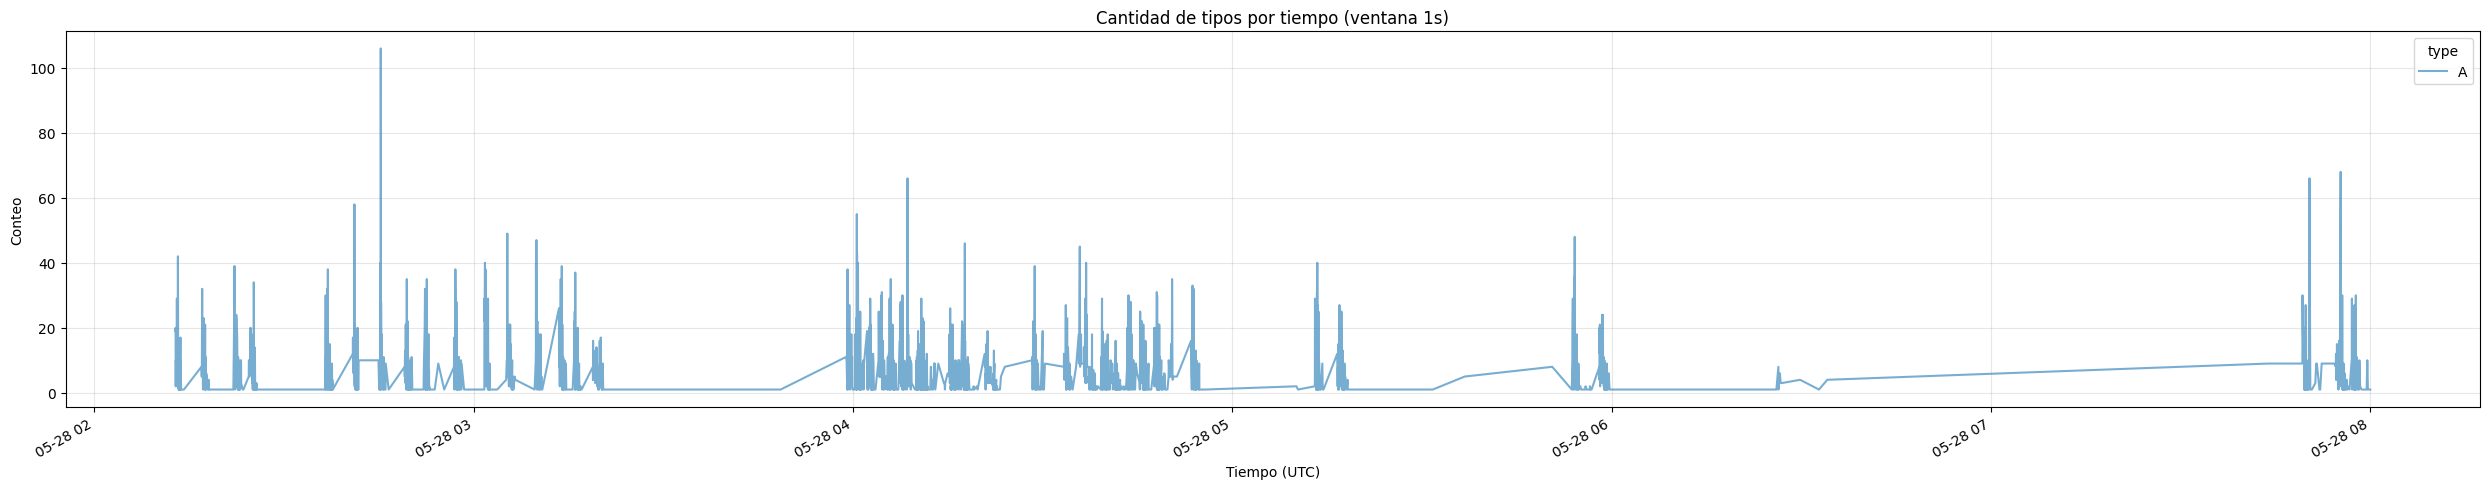

In [77]:
df_test = df_top_10_prefixes.copy()

df_test['time_dt'] = pd.to_datetime(df_test['time'], unit='s', utc=True, errors='coerce')
df_test = df_test.sort_values('time_dt')

freq = '1s'

df_counts_a = (
    df_test[(df_test['type'] == 'A')]
    .set_index('time_dt')
    .groupby([pd.Grouper(freq=freq), 'type'])
    .size()                             # cuenta ocurrencias
    .unstack(fill_value=0)              # columnas = cada tipo
)

import matplotlib.pyplot as plt

ax = df_counts_a.plot(kind='line', stacked=False, figsize=(25,5), alpha=0.6)
ax.set_title(f'Cantidad de tipos por tiempo (ventana {freq})')
ax.set_xlabel('Tiempo (UTC)')
ax.set_ylabel('Conteo')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [78]:
df_counts_a

type,A
time_dt,
2025-05-28 02:12:50+00:00,19
2025-05-28 02:12:52+00:00,20
2025-05-28 02:12:53+00:00,2
2025-05-28 02:12:54+00:00,10
2025-05-28 02:12:58+00:00,9
...,...
2025-05-28 07:59:31+00:00,9
2025-05-28 07:59:32+00:00,10
2025-05-28 07:59:38+00:00,1


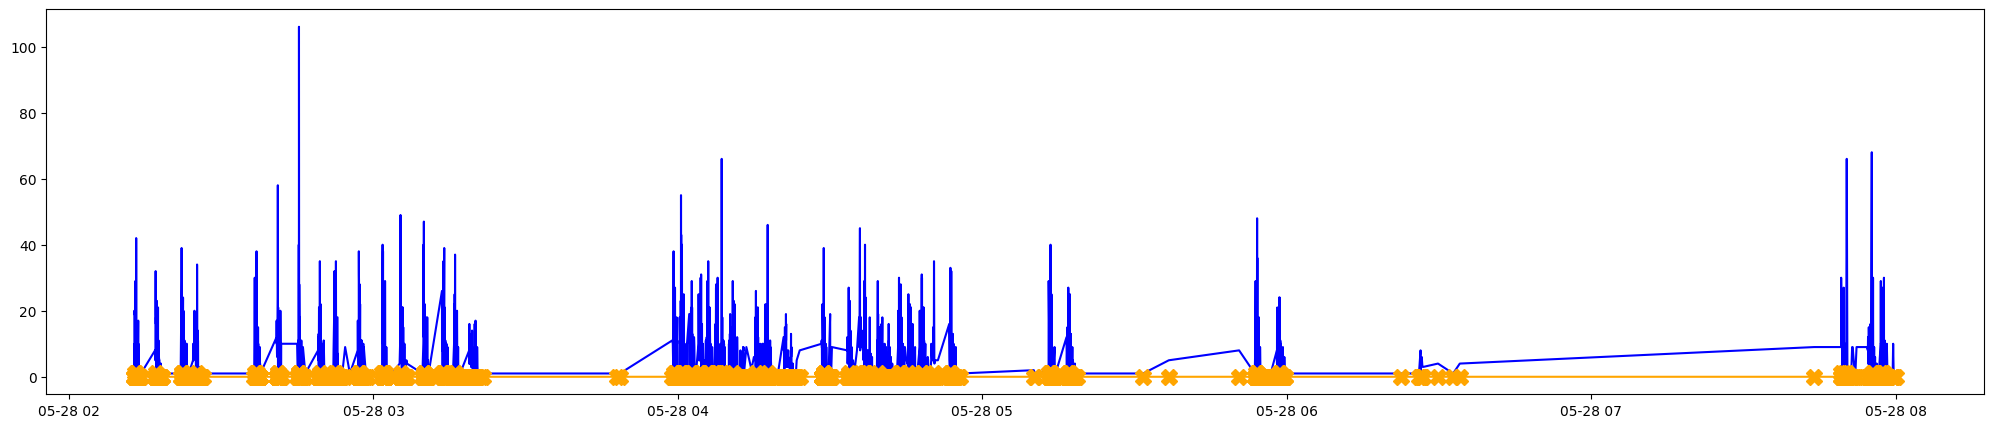

In [ ]:
q1, q3 = df_counts_a['A'].quantile([0.25,0.75])

iqr = q3 - q1

# Lower bound
lower_q = q1 - (1.5 * iqr)
# Upper bound
upper_q = q3 + (1.5 * iqr)

df_counts_a['anomaly'] = ((df_counts_a['A'] > upper_q) | (df_counts_a['A'] < lower_q)).astype('int')

anomaly = df_counts_a[df_counts_a['A']==1]

plt.figure(figsize=(25,5))
plt.plot(df_counts_a['A'], color='blue', label='Anuncios')
plt.plot(anomaly['anomaly'], linestyle=None, marker='X', color='orange', markersize=12, label='Anomalia')
plt.show()

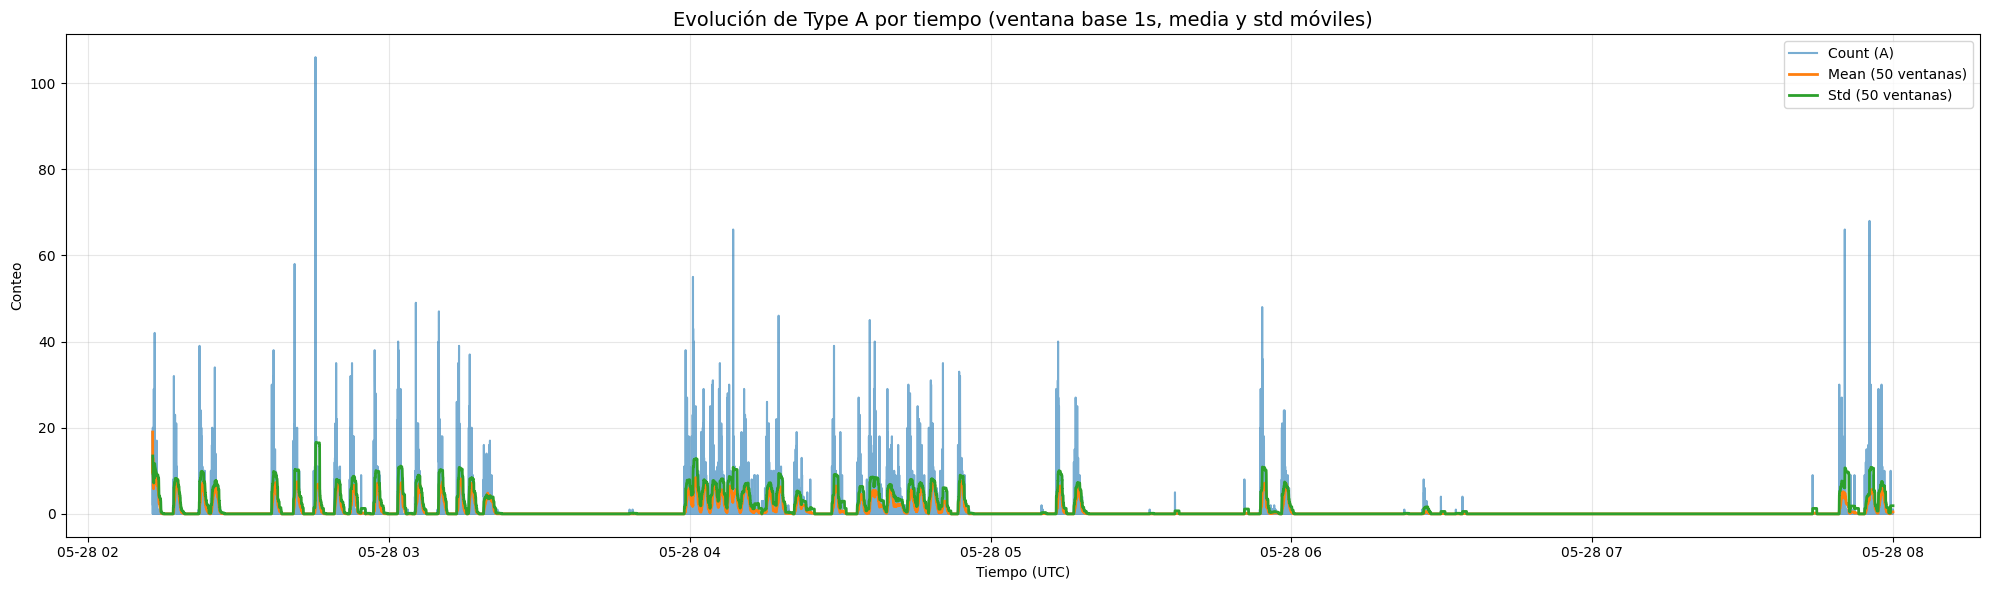

In [50]:
df_test = df_top_10_prefixes.copy()

df_test['time_dt'] = pd.to_datetime(df_test['time'], unit='s', utc=True, errors='coerce')
df_test = df_test.sort_values('time_dt')

freq = '1s'

# --- Agrupar solo los eventos tipo A por frecuencia ---
df_A = (
    df_test[df_test['type'] == 'A']
    .set_index('time_dt')
    .groupby(pd.Grouper(freq=freq))
    .size()
    .rename('count')
    .to_frame()
)

# --- Calcular la media y desviación estándar móviles ---
# por ejemplo, una ventana de 10 periodos (10*30s = 5 minutos)
window = 50  

df_A['mean'] = df_A['count'].rolling(window=window, min_periods=1).mean()
df_A['std']  = df_A['count'].rolling(window=window, min_periods=1).std()

# --- Graficar ---
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(df_A.index, df_A['count'], label='Count (A)', color='tab:blue', alpha=0.6)
ax.plot(df_A.index, df_A['mean'], label=f'Mean ({window} ventanas)', color='tab:orange', linewidth=2)
ax.plot(df_A.index, df_A['std'], label=f'Std ({window} ventanas)', color='tab:green', linewidth=2)

ax.set_title(f'Evolución de Type A por tiempo (ventana base {freq}, media y std móviles)', fontsize=14)
ax.set_xlabel('Tiempo (UTC)')
ax.set_ylabel('Conteo')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

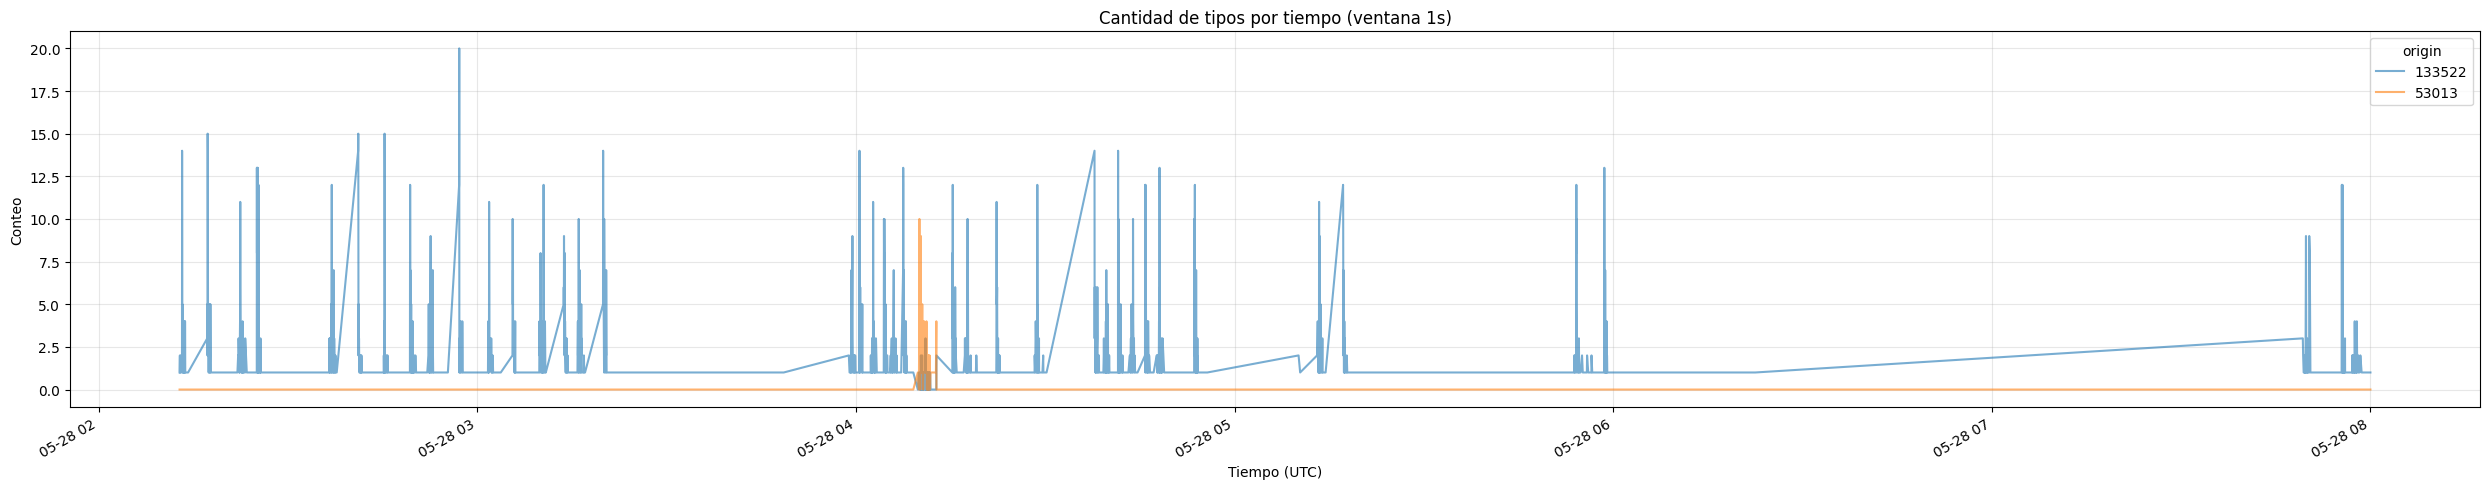

In [61]:
df_test = df_top_10_prefixes.copy()

df_test['time_dt'] = pd.to_datetime(df_test['time'], unit='s', utc=True, errors='coerce')
df_test['time_str'] = df_test['time_dt'].dt.strftime('%Y-%m-%d %H:%M:%S')
df_test = df_test.sort_values('time_dt')

freq = '1s'

df_counts_origins = (
    df_test[(df_test['prefix'] == '156.227.32.0/21')&(df_test['type'] == 'A')]
    .set_index('time_dt')
    .groupby([pd.Grouper(freq=freq), 'origin'])
    .size()                             # cuenta ocurrencias
    .unstack(fill_value=0)              # columnas = cada tipo
)

import matplotlib.pyplot as plt

ax = df_counts_origins.plot(kind='line', stacked=False, figsize=(25,5), alpha=0.6)
ax.set_title(f'Cantidad de tipos por tiempo (ventana {freq})')
ax.set_xlabel('Tiempo (UTC)')
ax.set_ylabel('Conteo')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [62]:
df_counts_origins

origin,133522,53013
time_dt,,
2025-05-28 02:12:50+00:00,1,0
2025-05-28 02:12:52+00:00,2,0
2025-05-28 02:12:53+00:00,2,0
2025-05-28 02:12:54+00:00,1,0
2025-05-28 02:12:58+00:00,1,0
...,...,...
2025-05-28 07:59:26+00:00,1,0
2025-05-28 07:59:32+00:00,1,0
2025-05-28 07:59:38+00:00,1,0


In [ ]:
q1, q3 = df_counts_a['A'].quantile([0.25,0.75])

iqr = q3 - q1

# Lower bound
lower_q = q1 - (1.5 * iqr)
# Upper bound
upper_q = q3 + (1.5 * iqr)

df_counts_a['anomaly'] = ((df_counts_a['A'] > upper_q) | (df_counts_a['A'] < lower_q)).astype('int')

anomaly = df_counts_a[df_counts_a['A']==1]

plt.figure(figsize=(25,5))
plt.plot(df_counts_a['A'], color='blue', label='Anuncios')
plt.plot(df_counts_a['anomaly'], linestyle=None, marker='X', color='orange', markersize=12, label='Anomalia')
plt.show()

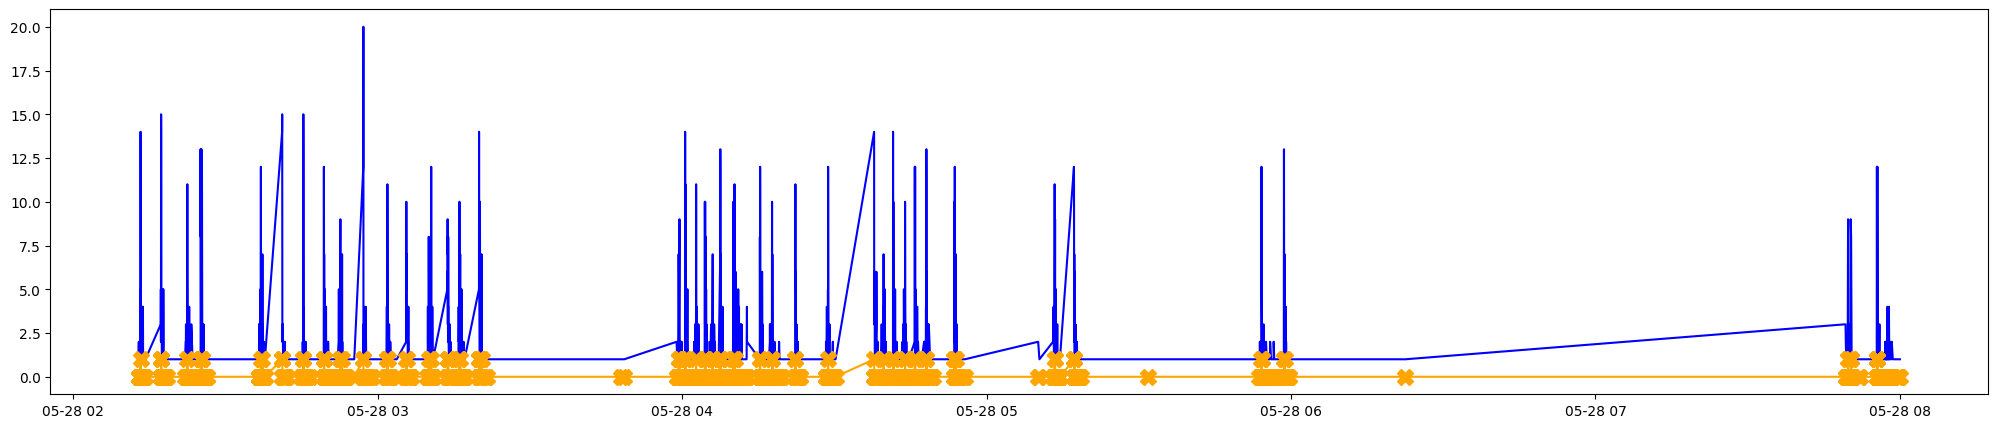

In [43]:
# Orden clave para todos los cálculos
df_test = df_test.sort_values(['prefix', 'time']).reset_index(drop=True)

df_test['secs_between_announcements'] = np.nan

maskA = df_test['type'].eq('A')
df_test.loc[maskA, 'secs_between_announcements'] = (
    df_test[maskA]
      .groupby('prefix')['time']
      .diff()     # como 'time' está en segundos, el diff queda en segundos
)

df_test['secs_between_announcements'].fillna(0,inplace=True)

display(df_test.head(5))

,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,time_dt,secs_between_announcements
0,1.748398e+09,route-views.eqix,6830,206.126.236.117,A,103.199.103.0/24,206.126.236.117,6830 174 3786 138195 138195,138195,2025-05-28 02:12:50.433680058+00:00,0.000000
1,1.748398e+09,route-views.eqix,6830,206.126.236.117,A,103.199.103.0/24,206.126.236.117,6830 3491 150684 138195,138195,2025-05-28 02:12:50.899292946+00:00,0.465613
2,1.748398e+09,route-views2.saopaulo,52873,187.16.220.216,A,103.199.103.0/24,187.16.220.216,52873 12956 3491 150684 138195,138195,2025-05-28 02:12:52.200567007+00:00,1.301274
3,1.748398e+09,route-views.eqix,3257,206.126.236.19,A,103.199.103.0/24,206.126.236.19,3257 3491 150684 138195,138195,2025-05-28 02:12:52.483165979+00:00,0.282599
4,1.748398e+09,route-views.eqix,11039,206.126.236.172,A,103.199.103.0/24,206.126.236.172,11039 4901 11164 3786 138195 138195,138195,2025-05-28 02:12:54.518917084+00:00,2.035751


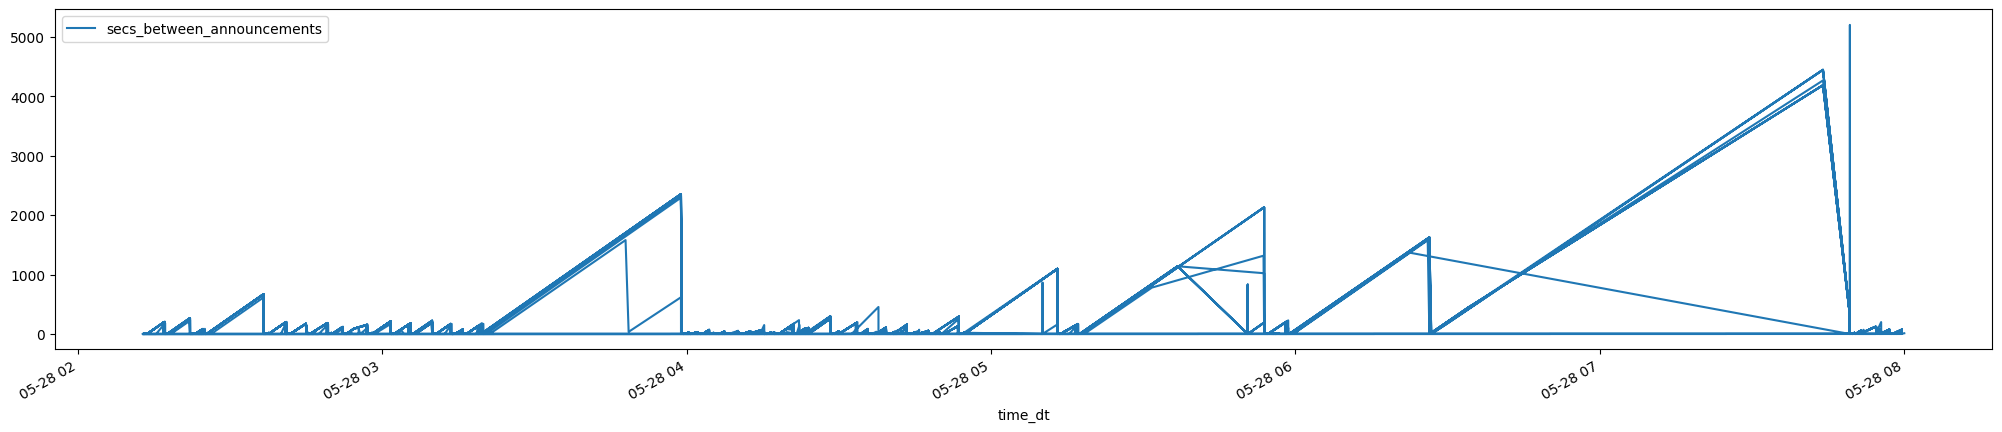

In [32]:
df_test.plot(x='time_dt', y='secs_between_announcements', kind='line', figsize=(25,5))
plt.show()

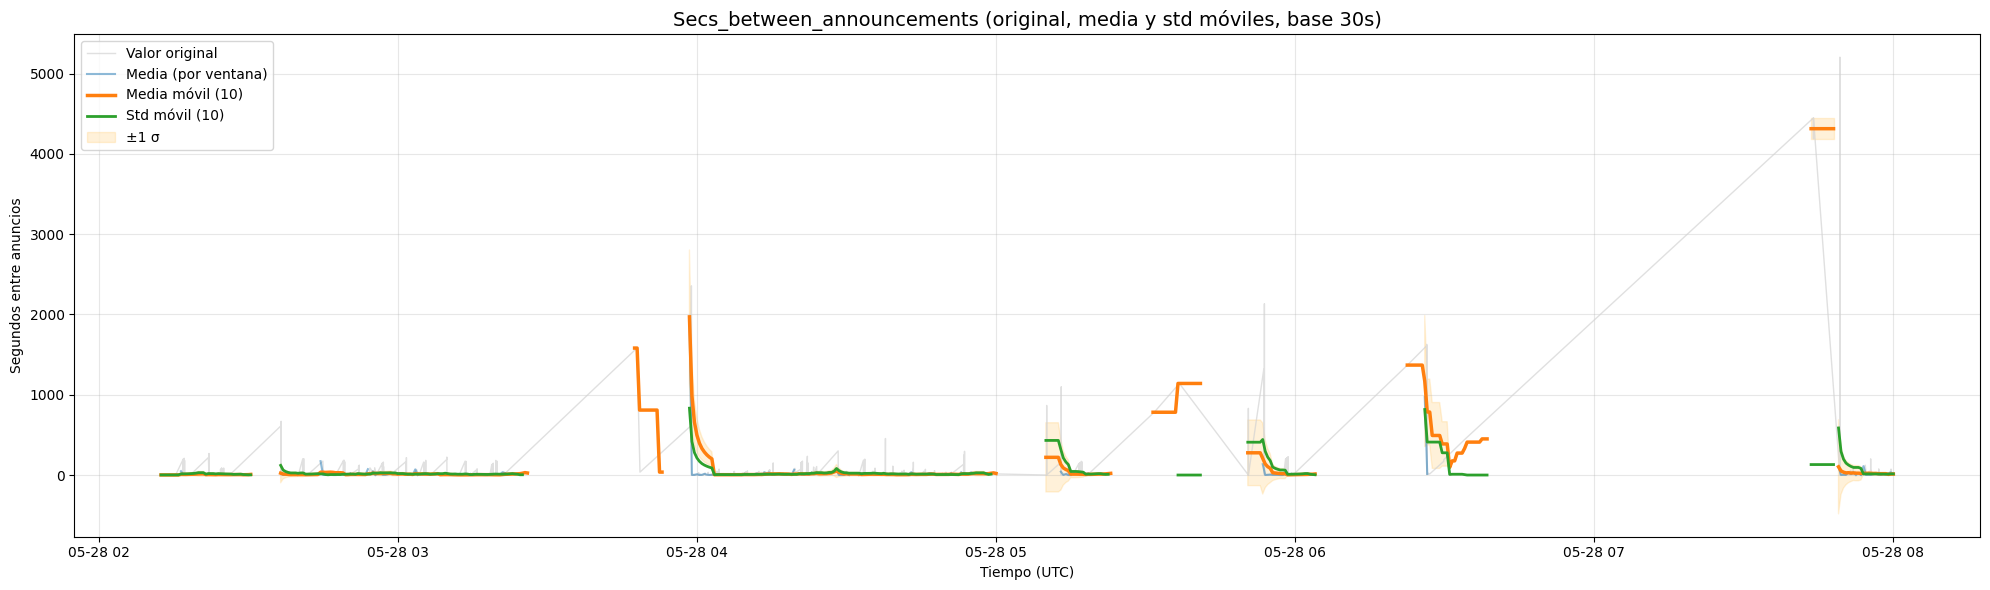

In [45]:
df_test['time_dt'] = pd.to_datetime(df_test['time'], unit='s', utc=True, errors='coerce')
df_test = df_test.sort_values('time_dt')

freq = '30s'   # frecuencia de agrupación
window = 10    # tamaño de la ventana móvil (en número de grupos)

# --- Agrupar por tiempo base y calcular mean/std ---
df_grouped = (
    df_test
    .set_index('time_dt')
    .groupby(pd.Grouper(freq=freq))['secs_between_announcements']
    .agg(['mean', 'std'])
)

# --- Calcular rolling mean/std (para suavizar) ---
df_grouped['mean_roll'] = df_grouped['mean'].rolling(window=window, min_periods=1).mean()
df_grouped['std_roll']  = df_grouped['std'].rolling(window=window, min_periods=1).mean()

# --- Graficar ---
fig, ax = plt.subplots(figsize=(20,6))

# 1️⃣ valores originales
ax.plot(
    df_test['time_dt'],
    df_test['secs_between_announcements'],
    color='lightgray',
    alpha=0.7,
    linewidth=1,
    label='Valor original'
)

# 2️⃣ media base por ventana
ax.plot(
    df_grouped.index,
    df_grouped['mean'],
    color='tab:blue',
    alpha=0.5,
    linewidth=1.5,
    label='Media (por ventana)'
)

# 3️⃣ media móvil suavizada
ax.plot(
    df_grouped.index,
    df_grouped['mean_roll'],
    color='tab:orange',
    linewidth=2.5,
    label=f'Media móvil ({window})'
)

# 4️⃣ desviación estándar móvil
ax.plot(
    df_grouped.index,
    df_grouped['std_roll'],
    color='tab:green',
    linewidth=2,
    label=f'Std móvil ({window})'
)

# 5️⃣ banda ±1σ alrededor de la media móvil
ax.fill_between(
    df_grouped.index,
    df_grouped['mean_roll'] - df_grouped['std_roll'],
    df_grouped['mean_roll'] + df_grouped['std_roll'],
    color='orange',
    alpha=0.15,
    label='±1 σ'
)

ax.set_title(f'Secs_between_announcements (original, media y std móviles, base {freq})', fontsize=14)
ax.set_xlabel('Tiempo (UTC)')
ax.set_ylabel('Segundos entre anuncios')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

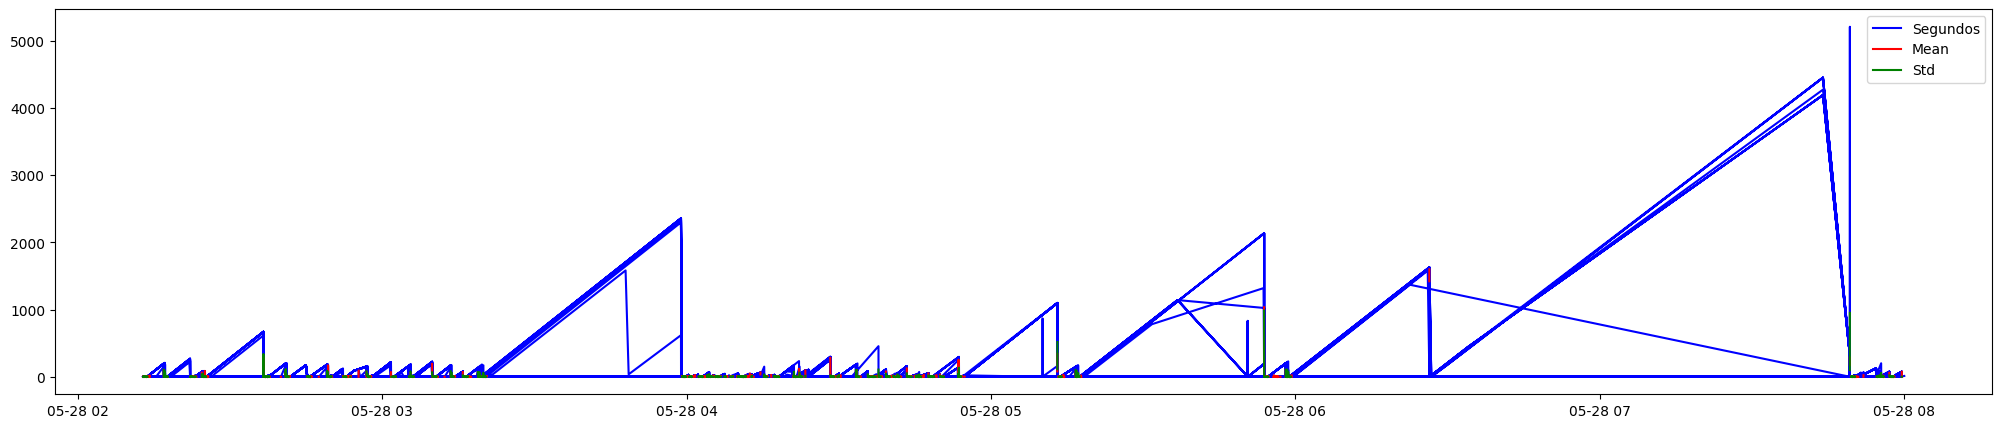

In [39]:
df_roll = df_test.copy()

df_roll['time_dt'] = pd.to_datetime(df_roll['time'], unit='s', utc=True)
df_roll.set_index('time_dt', inplace=True)

df_roll = df_roll[['secs_between_announcements']]

freq = '1S'

roll_mean = df_roll.resample(freq).mean()
roll_std = df_roll.resample(freq).std()

plt.figure(figsize=(25,5))
plt.plot(df_roll['secs_between_announcements'], color='blue', label='Segundos')
plt.plot(roll_mean['secs_between_announcements'], color='red', label='Mean')
plt.plot(roll_std['secs_between_announcements'], color='green', label='Std')
plt.legend(loc='best')
plt.show()

In [ ]:
df_test = df_test.sort_values('time_dt')

freq = '30s'

df_secs = (
    df_test.set_index('time_dt')
    .groupby([pd.Grouper(freq=freq), 'type'])
    .size()                             # cuenta ocurrencias
    .unstack(fill_value=0)              # columnas = cada tipo
)

import matplotlib.pyplot as plt

ax = df_counts.plot(kind='line', stacked=False, figsize=(25,5), alpha=0.6)
ax.set_title(f'Cantidad de tipos por tiempo (ventana {freq})')
ax.set_xlabel('Tiempo (UTC)')
ax.set_ylabel('Conteo')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()